## KAN RL

In [1]:
!pip install gymnasium pykan~=0.0.2

## Models

100%|██████████| 26421880/26421880 [00:01<00:00, 14777695.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265606.95it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4899774.35it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8791643.73it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(7)
Feedback shape: torch.Size([1, 8, 8])


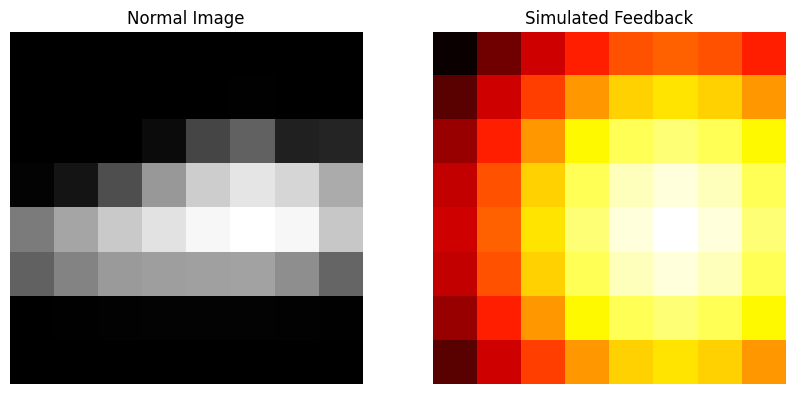

tensor(0.4404) tensor(1.)


In [4]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")

        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'hot' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()

# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())

In [5]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
torch.Size([1, 64])


In [6]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):


    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

2024-11-03 15:40:32.965229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 15:40:32.965379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 15:40:33.118304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
              for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,), (0.5,)),
                  transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent

# All distributions

https://pytorch.org/docs/stable/distributions.html#laplace

## MLP

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730648515:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.0472337696026129
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730648515:   1%|          | 1/100 [00:04<07:36,  4.61s/it]

 Test accuracy:  0.2731

correct: 40 total: 469
loss: 0.05616164141531184
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730648515:   2%|▏         | 2/100 [00:09<07:42,  4.72s/it]

 Test accuracy:  0.3144

correct: 160 total: 469
loss: 0.06780202404014084
 Train accuracy:  0.3411513859275053 | 


MLP_MNIST_0_1730648515:   3%|▎         | 3/100 [00:14<07:43,  4.78s/it]

 Test accuracy:  0.3753

correct: 188 total: 469
loss: 0.08075590014680108
 Train accuracy:  0.40085287846481876 | 


MLP_MNIST_0_1730648515:   4%|▍         | 4/100 [00:19<07:42,  4.82s/it]

 Test accuracy:  0.4191

correct: 212 total: 469
loss: 0.08783254802608287
 Train accuracy:  0.4520255863539446 | 


MLP_MNIST_0_1730648515:   5%|▌         | 5/100 [00:23<07:37,  4.82s/it]

 Test accuracy:  0.4421

correct: 207 total: 469
loss: 0.09334097820113717
 Train accuracy:  0.44136460554371004 | 


MLP_MNIST_0_1730648515:   6%|▌         | 6/100 [00:28<07:39,  4.89s/it]

 Test accuracy:  0.4647

correct: 239 total: 469
loss: 0.09747340897125985
 Train accuracy:  0.509594882729211 | 


MLP_MNIST_0_1730648515:   7%|▋         | 7/100 [00:33<07:34,  4.89s/it]

 Test accuracy:  0.4748

correct: 223 total: 469
loss: 0.10179122731184909
 Train accuracy:  0.47547974413646055 | 


MLP_MNIST_0_1730648515:   8%|▊         | 8/100 [00:38<07:29,  4.89s/it]

 Test accuracy:  0.4838

correct: 216 total: 469
loss: 0.10519133883117358
 Train accuracy:  0.4605543710021322 | 


MLP_MNIST_0_1730648515:   9%|▉         | 9/100 [00:43<07:32,  4.97s/it]

 Test accuracy:  0.4951

correct: 239 total: 469
loss: 0.10738705440180134
 Train accuracy:  0.509594882729211 | 


MLP_MNIST_0_1730648515:  10%|█         | 10/100 [00:48<07:23,  4.93s/it]

 Test accuracy:  0.506

correct: 245 total: 469
loss: 0.11001835124833244
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1730648515:  11%|█         | 11/100 [00:53<07:15,  4.90s/it]

 Test accuracy:  0.5216

correct: 229 total: 469
loss: 0.11196670160174116
 Train accuracy:  0.488272921108742 | 


MLP_MNIST_0_1730648515:  12%|█▏        | 12/100 [00:58<07:10,  4.89s/it]

 Test accuracy:  0.5089

correct: 224 total: 469
loss: 0.11424227907205187
 Train accuracy:  0.47761194029850745 | 


MLP_MNIST_0_1730648515:  13%|█▎        | 13/100 [01:03<07:04,  4.88s/it]

 Test accuracy:  0.5176

correct: 255 total: 469
loss: 0.11601063888718578
 Train accuracy:  0.5437100213219617 | 


MLP_MNIST_0_1730648515:  14%|█▍        | 14/100 [01:08<06:57,  4.86s/it]

 Test accuracy:  0.5207

correct: 248 total: 469
loss: 0.11639016542607533
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730648515:  15%|█▌        | 15/100 [01:13<06:54,  4.88s/it]

 Test accuracy:  0.5302

correct: 254 total: 469
loss: 0.1189590508241389
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730648515:  16%|█▌        | 16/100 [01:18<06:55,  4.94s/it]

 Test accuracy:  0.529

correct: 259 total: 469
loss: 0.12078913417198002
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1730648515:  17%|█▋        | 17/100 [01:22<06:47,  4.91s/it]

 Test accuracy:  0.5322

correct: 259 total: 469
loss: 0.12168452664733187
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1730648515:  18%|█▊        | 18/100 [01:27<06:45,  4.94s/it]

 Test accuracy:  0.5254

correct: 248 total: 469
loss: 0.12160140488828931
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730648515:  19%|█▉        | 19/100 [01:33<06:43,  4.98s/it]

 Test accuracy:  0.5276

correct: 248 total: 469
loss: 0.12391624439245602
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730648515:  20%|██        | 20/100 [01:37<06:37,  4.97s/it]

 Test accuracy:  0.5368

correct: 251 total: 469
loss: 0.12472920164243499
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1730648515:  21%|██        | 21/100 [01:42<06:32,  4.97s/it]

 Test accuracy:  0.5207

correct: 239 total: 469
loss: 0.1249722480011393
 Train accuracy:  0.509594882729211 | 


MLP_MNIST_0_1730648515:  22%|██▏       | 22/100 [01:48<06:34,  5.06s/it]

 Test accuracy:  0.5336

correct: 263 total: 469
loss: 0.12628489785166438
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1730648515:  23%|██▎       | 23/100 [01:53<06:29,  5.06s/it]

 Test accuracy:  0.5271

correct: 249 total: 469
loss: 0.1274399980267228
 Train accuracy:  0.5309168443496801 | 


MLP_MNIST_0_1730648515:  24%|██▍       | 24/100 [01:58<06:26,  5.08s/it]

 Test accuracy:  0.5363

correct: 259 total: 469
loss: 0.1283141216044741
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1730648515:  25%|██▌       | 25/100 [02:03<06:21,  5.09s/it]

 Test accuracy:  0.5359

correct: 251 total: 469
loss: 0.1288450284362602
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1730648515:  26%|██▌       | 26/100 [02:08<06:16,  5.09s/it]

 Test accuracy:  0.5346

correct: 241 total: 469
loss: 0.1296242440719086
 Train accuracy:  0.5138592750533049 | 


MLP_MNIST_0_1730648515:  27%|██▋       | 27/100 [02:13<06:09,  5.06s/it]

 Test accuracy:  0.5426

correct: 247 total: 469
loss: 0.13028237693853725
 Train accuracy:  0.5266524520255863 | 


MLP_MNIST_0_1730648515:  28%|██▊       | 28/100 [02:18<06:05,  5.08s/it]

 Test accuracy:  0.5334

correct: 266 total: 469
loss: 0.1295626261976482
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730648515:  29%|██▉       | 29/100 [02:23<05:58,  5.04s/it]

 Test accuracy:  0.5392

correct: 246 total: 469
loss: 0.13054470595583986
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1730648515:  30%|███       | 30/100 [02:28<05:52,  5.04s/it]

 Test accuracy:  0.531

correct: 253 total: 469
loss: 0.13112758185817744
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730648515:  31%|███       | 31/100 [02:33<05:49,  5.06s/it]

 Test accuracy:  0.5391

correct: 242 total: 469
loss: 0.13264323391322133
 Train accuracy:  0.5159914712153518 | 


MLP_MNIST_0_1730648515:  32%|███▏      | 32/100 [02:38<05:41,  5.03s/it]

 Test accuracy:  0.5386

correct: 256 total: 469
loss: 0.13210306453234605
 Train accuracy:  0.5458422174840085 | 


MLP_MNIST_0_1730648515:  33%|███▎      | 33/100 [02:43<05:37,  5.03s/it]

 Test accuracy:  0.5403

correct: 241 total: 469
loss: 0.13223180713366345
 Train accuracy:  0.5138592750533049 | 


MLP_MNIST_0_1730648515:  34%|███▍      | 34/100 [02:49<05:36,  5.09s/it]

 Test accuracy:  0.5324

correct: 247 total: 469
loss: 0.13364371643074033
 Train accuracy:  0.5266524520255863 | 


MLP_MNIST_0_1730648515:  35%|███▌      | 35/100 [02:54<05:30,  5.08s/it]

 Test accuracy:  0.533

correct: 234 total: 469
loss: 0.1333767138818688
 Train accuracy:  0.4989339019189765 | 


MLP_MNIST_0_1730648515:  36%|███▌      | 36/100 [02:59<05:25,  5.08s/it]

 Test accuracy:  0.5357

correct: 246 total: 469
loss: 0.13322493308452146
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1730648515:  37%|███▋      | 37/100 [03:04<05:19,  5.08s/it]

 Test accuracy:  0.5357

correct: 261 total: 469
loss: 0.1347330618165195
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730648515:  38%|███▊      | 38/100 [03:09<05:13,  5.05s/it]

 Test accuracy:  0.5415

correct: 249 total: 469
loss: 0.1340793009950662
 Train accuracy:  0.5309168443496801 | 


MLP_MNIST_0_1730648515:  39%|███▉      | 39/100 [03:14<05:06,  5.02s/it]

 Test accuracy:  0.5321

correct: 243 total: 469
loss: 0.13419223599024674
 Train accuracy:  0.5181236673773987 | 


MLP_MNIST_0_1730648515:  40%|████      | 40/100 [03:19<05:03,  5.05s/it]

 Test accuracy:  0.535

correct: 245 total: 469
loss: 0.13389297215732684
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1730648515:  41%|████      | 41/100 [03:24<05:03,  5.14s/it]

 Test accuracy:  0.5403

correct: 257 total: 469
loss: 0.1346387511282079
 Train accuracy:  0.5479744136460555 | 


MLP_MNIST_0_1730648515:  42%|████▏     | 42/100 [03:29<04:56,  5.12s/it]

 Test accuracy:  0.5295

correct: 250 total: 469
loss: 0.13519246992208303
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1730648515:  43%|████▎     | 43/100 [03:34<04:51,  5.11s/it]

 Test accuracy:  0.5395

correct: 254 total: 469
loss: 0.13536894825031
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730648515:  44%|████▍     | 44/100 [03:39<04:46,  5.12s/it]

 Test accuracy:  0.5407

correct: 246 total: 469
loss: 0.1359541858913802
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1730648515:  45%|████▌     | 45/100 [03:45<04:42,  5.14s/it]

 Test accuracy:  0.5362

correct: 247 total: 469
loss: 0.13510060353256237
 Train accuracy:  0.5266524520255863 | 


MLP_MNIST_0_1730648515:  46%|████▌     | 46/100 [03:50<04:36,  5.13s/it]

 Test accuracy:  0.535

correct: 264 total: 469
loss: 0.13561434395658944
 Train accuracy:  0.5628997867803838 | 


MLP_MNIST_0_1730648515:  47%|████▋     | 47/100 [03:55<04:35,  5.19s/it]

 Test accuracy:  0.5302

correct: 246 total: 469
loss: 0.13662297065768922
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1730648515:  48%|████▊     | 48/100 [04:00<04:30,  5.21s/it]

 Test accuracy:  0.5345

correct: 240 total: 469
loss: 0.13670145437470885
 Train accuracy:  0.511727078891258 | 


MLP_MNIST_0_1730648515:  49%|████▉     | 49/100 [04:05<04:24,  5.18s/it]

 Test accuracy:  0.5368

correct: 266 total: 469
loss: 0.13637488097079528
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730648515:  50%|█████     | 50/100 [04:11<04:18,  5.16s/it]

 Test accuracy:  0.5335

correct: 263 total: 469
loss: 0.13780906774214843
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1730648515:  51%|█████     | 51/100 [04:16<04:14,  5.20s/it]

 Test accuracy:  0.5411

correct: 254 total: 469
loss: 0.13655462646598754
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730648515:  52%|█████▏    | 52/100 [04:21<04:07,  5.16s/it]

 Test accuracy:  0.5389

correct: 249 total: 469
loss: 0.13768177660607073
 Train accuracy:  0.5309168443496801 | 


MLP_MNIST_0_1730648515:  53%|█████▎    | 53/100 [04:26<04:03,  5.19s/it]

 Test accuracy:  0.5374

correct: 248 total: 469
loss: 0.1373976836326534
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730648515:  54%|█████▍    | 54/100 [04:31<04:00,  5.22s/it]

 Test accuracy:  0.5363

correct: 252 total: 469
loss: 0.13788692445071268
 Train accuracy:  0.5373134328358209 | 


MLP_MNIST_0_1730648515:  55%|█████▌    | 55/100 [04:37<03:54,  5.22s/it]

 Test accuracy:  0.5336

correct: 250 total: 469
loss: 0.13728725184192028
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1730648515:  56%|█████▌    | 56/100 [04:42<03:47,  5.18s/it]

 Test accuracy:  0.5361

correct: 247 total: 469
loss: 0.13801609742234766
 Train accuracy:  0.5266524520255863 | 


MLP_MNIST_0_1730648515:  57%|█████▋    | 57/100 [04:47<03:42,  5.17s/it]

 Test accuracy:  0.5315

correct: 264 total: 469
loss: 0.1378894192196413
 Train accuracy:  0.5628997867803838 | 


MLP_MNIST_0_1730648515:  58%|█████▊    | 58/100 [04:52<03:37,  5.19s/it]

 Test accuracy:  0.5405

correct: 248 total: 469
loss: 0.1387276494426768
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730648515:  59%|█████▉    | 59/100 [04:58<03:35,  5.25s/it]

 Test accuracy:  0.5292

correct: 241 total: 469
loss: 0.1383807309972706
 Train accuracy:  0.5138592750533049 | 


MLP_MNIST_0_1730648515:  60%|██████    | 60/100 [05:03<03:29,  5.25s/it]

 Test accuracy:  0.5323

correct: 245 total: 469
loss: 0.13851386289606724
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1730648515:  61%|██████    | 61/100 [05:08<03:26,  5.28s/it]

 Test accuracy:  0.5465

correct: 251 total: 469
loss: 0.13920805396746472
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1730648515:  62%|██████▏   | 62/100 [05:13<03:19,  5.25s/it]

 Test accuracy:  0.5328

correct: 246 total: 469
loss: 0.1384101743255851
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1730648515:  63%|██████▎   | 63/100 [05:19<03:14,  5.26s/it]

 Test accuracy:  0.544

correct: 251 total: 469
loss: 0.13887277234401277
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1730648515:  64%|██████▍   | 64/100 [05:24<03:09,  5.27s/it]

 Test accuracy:  0.5325

correct: 243 total: 469
loss: 0.13909665895486945
 Train accuracy:  0.5181236673773987 | 


MLP_MNIST_0_1730648515:  65%|██████▌   | 65/100 [05:30<03:10,  5.44s/it]

 Test accuracy:  0.5349

correct: 250 total: 469
loss: 0.13900853750675218
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1730648515:  66%|██████▌   | 66/100 [05:35<03:04,  5.41s/it]

 Test accuracy:  0.5339

correct: 257 total: 469
loss: 0.13907398162747242
 Train accuracy:  0.5479744136460555 | 


MLP_MNIST_0_1730648515:  67%|██████▋   | 67/100 [05:40<02:56,  5.36s/it]

 Test accuracy:  0.54

correct: 253 total: 469
loss: 0.14017796046189915
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730648515:  68%|██████▊   | 68/100 [05:46<02:51,  5.35s/it]

 Test accuracy:  0.5402

correct: 239 total: 469
loss: 0.13940597039613642
 Train accuracy:  0.509594882729211 | 


MLP_MNIST_0_1730648515:  69%|██████▉   | 69/100 [05:51<02:45,  5.35s/it]

 Test accuracy:  0.5354

correct: 248 total: 469
loss: 0.14021154186491774
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730648515:  70%|███████   | 70/100 [05:56<02:39,  5.33s/it]

 Test accuracy:  0.5335

correct: 251 total: 469
loss: 0.139745221812842
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1730648515:  71%|███████   | 71/100 [06:02<02:33,  5.30s/it]

 Test accuracy:  0.5335

correct: 242 total: 469
loss: 0.14015772150777805
 Train accuracy:  0.5159914712153518 | 


MLP_MNIST_0_1730648515:  72%|███████▏  | 72/100 [06:07<02:28,  5.30s/it]

 Test accuracy:  0.5379

correct: 218 total: 469
loss: 0.14025352415499656
 Train accuracy:  0.464818763326226 | 


MLP_MNIST_0_1730648515:  73%|███████▎  | 73/100 [06:12<02:22,  5.28s/it]

 Test accuracy:  0.5397

correct: 260 total: 469
loss: 0.14010433563545568
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1730648515:  74%|███████▍  | 74/100 [06:17<02:17,  5.30s/it]

 Test accuracy:  0.5303

correct: 252 total: 469
loss: 0.1404353062640121
 Train accuracy:  0.5373134328358209 | 


MLP_MNIST_0_1730648515:  75%|███████▌  | 75/100 [06:23<02:11,  5.28s/it]

 Test accuracy:  0.5366

correct: 249 total: 469
loss: 0.13993920342945088
 Train accuracy:  0.5309168443496801 | 


MLP_MNIST_0_1730648515:  76%|███████▌  | 76/100 [06:28<02:06,  5.29s/it]

 Test accuracy:  0.5294

correct: 256 total: 469
loss: 0.13978957610407364
 Train accuracy:  0.5458422174840085 | 


MLP_MNIST_0_1730648515:  77%|███████▋  | 77/100 [06:33<02:03,  5.37s/it]

 Test accuracy:  0.5309

correct: 253 total: 469
loss: 0.14013480290230404
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730648515:  78%|███████▊  | 78/100 [06:39<01:57,  5.34s/it]

 Test accuracy:  0.5332

correct: 259 total: 469
loss: 0.13979430164673182
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1730648515:  79%|███████▉  | 79/100 [06:44<01:52,  5.36s/it]

 Test accuracy:  0.5402

correct: 240 total: 469
loss: 0.1404337209107271
 Train accuracy:  0.511727078891258 | 


MLP_MNIST_0_1730648515:  80%|████████  | 80/100 [06:50<01:47,  5.37s/it]

 Test accuracy:  0.5403

correct: 242 total: 469
loss: 0.13971167715437122
 Train accuracy:  0.5159914712153518 | 


MLP_MNIST_0_1730648515:  81%|████████  | 81/100 [06:55<01:41,  5.35s/it]

 Test accuracy:  0.5345

correct: 255 total: 469
loss: 0.1403068345206887
 Train accuracy:  0.5437100213219617 | 


MLP_MNIST_0_1730648515:  82%|████████▏ | 82/100 [07:00<01:36,  5.36s/it]

 Test accuracy:  0.5355

correct: 229 total: 469
loss: 0.1403828116971801
 Train accuracy:  0.488272921108742 | 


MLP_MNIST_0_1730648515:  83%|████████▎ | 83/100 [07:06<01:31,  5.36s/it]

 Test accuracy:  0.5409

correct: 253 total: 469
loss: 0.14085358818139093
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730648515:  84%|████████▍ | 84/100 [07:11<01:25,  5.35s/it]

 Test accuracy:  0.5333

correct: 261 total: 469
loss: 0.1409083581618917
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730648515:  85%|████████▌ | 85/100 [07:16<01:20,  5.34s/it]

 Test accuracy:  0.5355

correct: 258 total: 469
loss: 0.14063489138444604
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1730648515:  86%|████████▌ | 86/100 [07:22<01:14,  5.33s/it]

 Test accuracy:  0.5359

correct: 245 total: 469
loss: 0.14069127097630552
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1730648515:  87%|████████▋ | 87/100 [07:27<01:09,  5.33s/it]

 Test accuracy:  0.527

correct: 253 total: 469
loss: 0.14072305628104503
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730648515:  88%|████████▊ | 88/100 [07:32<01:03,  5.33s/it]

 Test accuracy:  0.5446

correct: 259 total: 469
loss: 0.1407468269851162
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1730648515:  89%|████████▉ | 89/100 [07:38<00:59,  5.39s/it]

 Test accuracy:  0.5434

correct: 250 total: 469
loss: 0.1410975584279754
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1730648515:  90%|█████████ | 90/100 [07:43<00:53,  5.35s/it]

 Test accuracy:  0.5299

correct: 275 total: 469
loss: 0.14146785244250348
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1730648515:  91%|█████████ | 91/100 [07:48<00:48,  5.38s/it]

 Test accuracy:  0.5368

correct: 246 total: 469
loss: 0.14080765590802438
 Train accuracy:  0.5245202558635395 | 


MLP_MNIST_0_1730648515:  92%|█████████▏| 92/100 [07:54<00:43,  5.40s/it]

 Test accuracy:  0.5311

correct: 262 total: 469
loss: 0.14138560297329034
 Train accuracy:  0.55863539445629 | 


MLP_MNIST_0_1730648515:  93%|█████████▎| 93/100 [07:59<00:37,  5.40s/it]

 Test accuracy:  0.5377

correct: 257 total: 469
loss: 0.1408460740405105
 Train accuracy:  0.5479744136460555 | 


MLP_MNIST_0_1730648515:  94%|█████████▍| 94/100 [08:05<00:32,  5.43s/it]

 Test accuracy:  0.5354

correct: 253 total: 469
loss: 0.14138993241194722
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730648515:  95%|█████████▌| 95/100 [08:10<00:27,  5.47s/it]

 Test accuracy:  0.5279

correct: 254 total: 469
loss: 0.14197899210554704
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730648515:  96%|█████████▌| 96/100 [08:16<00:21,  5.48s/it]

 Test accuracy:  0.5365

correct: 263 total: 469
loss: 0.1414452672068244
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1730648515:  97%|█████████▋| 97/100 [08:21<00:16,  5.43s/it]

 Test accuracy:  0.534

correct: 273 total: 469
loss: 0.14091431060388906
 Train accuracy:  0.582089552238806 | 


MLP_MNIST_0_1730648515:  98%|█████████▊| 98/100 [08:27<00:10,  5.43s/it]

 Test accuracy:  0.5359

correct: 254 total: 469
loss: 0.14170376662570022
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730648515:  99%|█████████▉| 99/100 [08:32<00:05,  5.44s/it]

 Test accuracy:  0.5389

correct: 260 total: 469
loss: 0.14116662046484857
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1730648515: 100%|██████████| 100/100 [08:38<00:00,  5.18s/it]

 Test accuracy:  0.5394


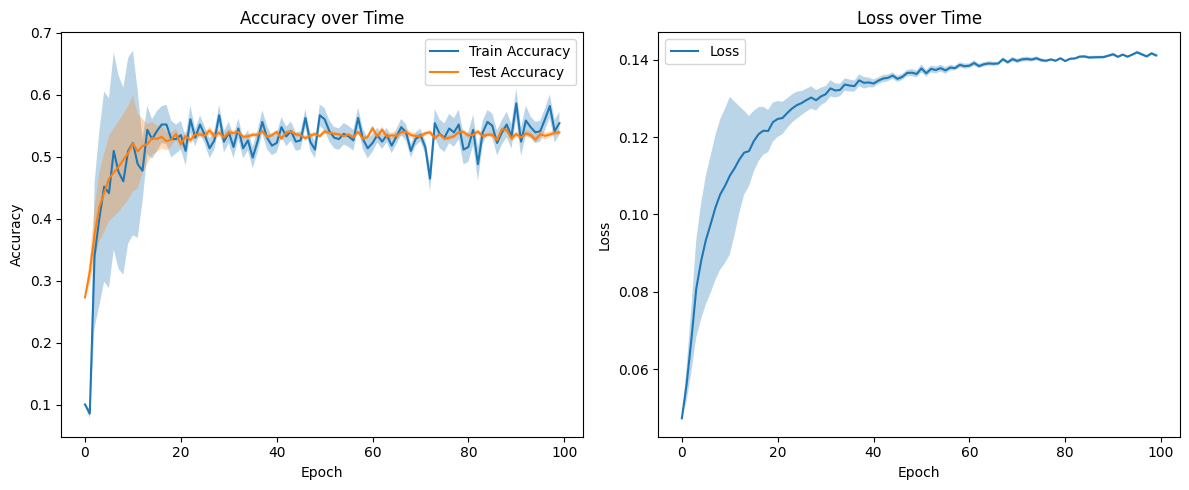

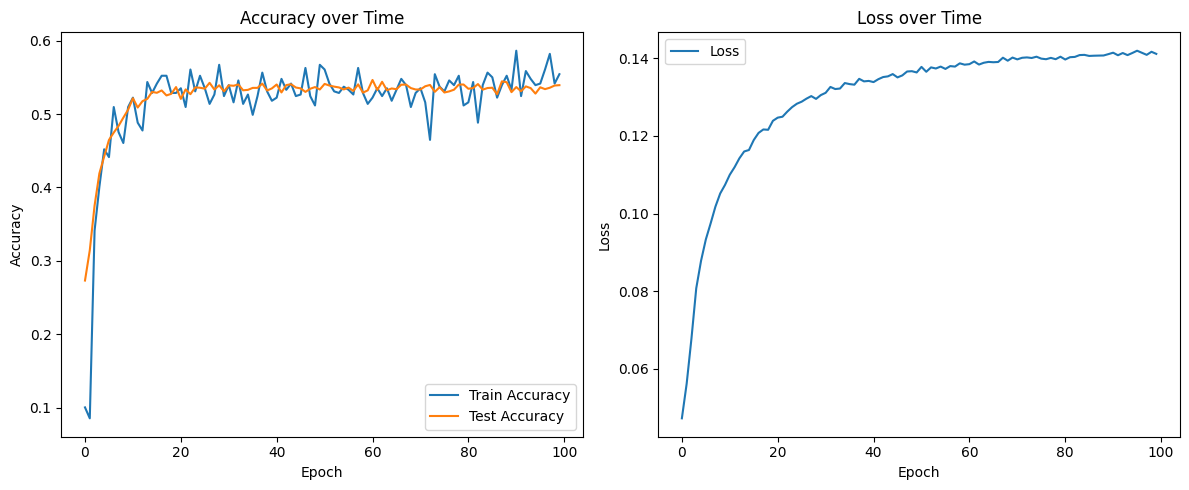

Final Train Accuracy: 0.55 ± 0.02
Final Test Accuracy: 0.54 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730649036:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.06498372054366923
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730649036:   1%|          | 1/100 [00:04<07:20,  4.45s/it]

 Test accuracy:  0.1048

correct: 40 total: 469
loss: 0.08300917516194427
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730649036:   2%|▏         | 2/100 [00:09<07:30,  4.60s/it]

 Test accuracy:  0.1405

correct: 63 total: 469
loss: 0.08460813618576857
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649036:   3%|▎         | 3/100 [00:13<07:29,  4.64s/it]

 Test accuracy:  0.1769

correct: 73 total: 469
loss: 0.08932883184411124
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730649036:   4%|▍         | 4/100 [00:18<07:36,  4.76s/it]

 Test accuracy:  0.1922

correct: 87 total: 469
loss: 0.09461045165909633
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649036:   5%|▌         | 5/100 [00:24<07:51,  4.96s/it]

 Test accuracy:  0.1825

correct: 78 total: 469
loss: 0.0968975611904791
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730649036:   6%|▌         | 6/100 [00:29<08:01,  5.12s/it]

 Test accuracy:  0.2065

correct: 87 total: 469
loss: 0.09853534908818283
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649036:   7%|▋         | 7/100 [00:34<08:02,  5.19s/it]

 Test accuracy:  0.2078

correct: 79 total: 469
loss: 0.10109813349333399
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730649036:   8%|▊         | 8/100 [00:40<08:03,  5.25s/it]

 Test accuracy:  0.2032

correct: 74 total: 469
loss: 0.10129561195813262
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:   9%|▉         | 9/100 [00:45<08:03,  5.31s/it]

 Test accuracy:  0.2121

correct: 101 total: 469
loss: 0.10109691321849823
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730649036:  10%|█         | 10/100 [00:51<08:01,  5.35s/it]

 Test accuracy:  0.212

correct: 74 total: 469
loss: 0.10455520988019036
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:  11%|█         | 11/100 [00:56<07:59,  5.38s/it]

 Test accuracy:  0.222

correct: 74 total: 469
loss: 0.10418721542620202
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:  12%|█▏        | 12/100 [01:02<08:01,  5.48s/it]

 Test accuracy:  0.2276

correct: 83 total: 469
loss: 0.10458467554436056
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730649036:  13%|█▎        | 13/100 [01:08<08:04,  5.57s/it]

 Test accuracy:  0.231

correct: 78 total: 469
loss: 0.10501380733398995
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730649036:  14%|█▍        | 14/100 [01:13<08:00,  5.59s/it]

 Test accuracy:  0.2301

correct: 83 total: 469
loss: 0.10577437726419363
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730649036:  15%|█▌        | 15/100 [01:19<08:05,  5.71s/it]

 Test accuracy:  0.2398

correct: 85 total: 469
loss: 0.10542695826368291
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730649036:  16%|█▌        | 16/100 [01:25<08:00,  5.72s/it]

 Test accuracy:  0.2374

correct: 86 total: 469
loss: 0.1072570962438197
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730649036:  17%|█▋        | 17/100 [01:30<07:49,  5.66s/it]

 Test accuracy:  0.2418

correct: 80 total: 469
loss: 0.1076390871774159
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730649036:  18%|█▊        | 18/100 [01:36<07:46,  5.69s/it]

 Test accuracy:  0.2395

correct: 78 total: 469
loss: 0.10678842414353194
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730649036:  19%|█▉        | 19/100 [01:42<07:38,  5.66s/it]

 Test accuracy:  0.2362

correct: 74 total: 469
loss: 0.10773495052542005
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:  20%|██        | 20/100 [01:47<07:33,  5.67s/it]

 Test accuracy:  0.2373

correct: 70 total: 469
loss: 0.10729376131346993
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649036:  21%|██        | 21/100 [01:53<07:28,  5.67s/it]

 Test accuracy:  0.2404

correct: 71 total: 469
loss: 0.10721347164878967
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649036:  22%|██▏       | 22/100 [01:59<07:22,  5.68s/it]

 Test accuracy:  0.236

correct: 71 total: 469
loss: 0.10787615221319423
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649036:  23%|██▎       | 23/100 [02:05<07:21,  5.74s/it]

 Test accuracy:  0.2393

correct: 73 total: 469
loss: 0.1080219336092345
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730649036:  24%|██▍       | 24/100 [02:10<07:14,  5.72s/it]

 Test accuracy:  0.2433

correct: 66 total: 469
loss: 0.10729348880332162
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649036:  25%|██▌       | 25/100 [02:16<07:07,  5.70s/it]

 Test accuracy:  0.245

correct: 62 total: 469
loss: 0.10665861771368523
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649036:  26%|██▌       | 26/100 [02:22<07:00,  5.68s/it]

 Test accuracy:  0.2391

correct: 65 total: 469
loss: 0.1064457524019772
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649036:  27%|██▋       | 27/100 [02:27<06:55,  5.69s/it]

 Test accuracy:  0.2349

correct: 75 total: 469
loss: 0.10744388520654076
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730649036:  28%|██▊       | 28/100 [02:33<06:49,  5.69s/it]

 Test accuracy:  0.2349

correct: 68 total: 469
loss: 0.10804734653882635
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730649036:  29%|██▉       | 29/100 [02:39<06:48,  5.75s/it]

 Test accuracy:  0.2343

correct: 76 total: 469
loss: 0.10681111373499766
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730649036:  30%|███       | 30/100 [02:45<06:41,  5.74s/it]

 Test accuracy:  0.2388

correct: 67 total: 469
loss: 0.10651343245940931
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649036:  31%|███       | 31/100 [02:50<06:34,  5.72s/it]

 Test accuracy:  0.235

correct: 66 total: 469
loss: 0.1071870564969618
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649036:  32%|███▏      | 32/100 [02:56<06:30,  5.75s/it]

 Test accuracy:  0.2384

correct: 72 total: 469
loss: 0.10697935178462885
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730649036:  33%|███▎      | 33/100 [03:02<06:26,  5.76s/it]

 Test accuracy:  0.2412

correct: 76 total: 469
loss: 0.10663300172797144
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730649036:  34%|███▍      | 34/100 [03:08<06:22,  5.79s/it]

 Test accuracy:  0.2373

correct: 64 total: 469
loss: 0.10726770296343353
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649036:  35%|███▌      | 35/100 [03:14<06:15,  5.78s/it]

 Test accuracy:  0.2386

correct: 60 total: 469
loss: 0.10702397823651462
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649036:  36%|███▌      | 36/100 [03:19<06:11,  5.80s/it]

 Test accuracy:  0.2335

correct: 65 total: 469
loss: 0.10602367761483325
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649036:  37%|███▋      | 37/100 [03:25<06:06,  5.82s/it]

 Test accuracy:  0.234

correct: 69 total: 469
loss: 0.10687842706182618
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649036:  38%|███▊      | 38/100 [03:31<05:58,  5.79s/it]

 Test accuracy:  0.2374

correct: 64 total: 469
loss: 0.10607000548384592
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649036:  39%|███▉      | 39/100 [03:37<05:53,  5.79s/it]

 Test accuracy:  0.2365

correct: 59 total: 469
loss: 0.10515526669429563
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649036:  40%|████      | 40/100 [03:43<05:51,  5.87s/it]

 Test accuracy:  0.2359

correct: 76 total: 469
loss: 0.1060691795337683
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730649036:  41%|████      | 41/100 [03:49<05:44,  5.84s/it]

 Test accuracy:  0.2365

correct: 56 total: 469
loss: 0.10579080120332714
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649036:  42%|████▏     | 42/100 [03:55<05:39,  5.85s/it]

 Test accuracy:  0.2409

correct: 74 total: 469
loss: 0.10591811708994765
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:  43%|████▎     | 43/100 [04:00<05:32,  5.83s/it]

 Test accuracy:  0.2373

correct: 68 total: 469
loss: 0.10582043668989942
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730649036:  44%|████▍     | 44/100 [04:06<05:24,  5.80s/it]

 Test accuracy:  0.2412

correct: 64 total: 469
loss: 0.10553952695718452
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649036:  45%|████▌     | 45/100 [04:12<05:20,  5.83s/it]

 Test accuracy:  0.2377

correct: 71 total: 469
loss: 0.10540714094252475
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649036:  46%|████▌     | 46/100 [04:18<05:17,  5.87s/it]

 Test accuracy:  0.2389

correct: 62 total: 469
loss: 0.10574937583223334
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649036:  47%|████▋     | 47/100 [04:24<05:09,  5.84s/it]

 Test accuracy:  0.2389

correct: 80 total: 469
loss: 0.10599067556197202
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730649036:  48%|████▊     | 48/100 [04:30<05:09,  5.95s/it]

 Test accuracy:  0.2388

correct: 50 total: 469
loss: 0.10512857563269418
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730649036:  49%|████▉     | 49/100 [04:36<05:01,  5.91s/it]

 Test accuracy:  0.2356

correct: 65 total: 469
loss: 0.10480946176913755
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649036:  50%|█████     | 50/100 [04:41<04:53,  5.87s/it]

 Test accuracy:  0.241

correct: 81 total: 469
loss: 0.10609355143138341
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730649036:  51%|█████     | 51/100 [04:48<04:50,  5.92s/it]

 Test accuracy:  0.2354

correct: 72 total: 469
loss: 0.10529546009134381
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730649036:  52%|█████▏    | 52/100 [04:53<04:45,  5.94s/it]

 Test accuracy:  0.2393

correct: 76 total: 469
loss: 0.10570949182581546
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730649036:  53%|█████▎    | 53/100 [05:00<04:40,  5.98s/it]

 Test accuracy:  0.2366

correct: 75 total: 469
loss: 0.10635654553612157
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730649036:  54%|█████▍    | 54/100 [05:05<04:32,  5.92s/it]

 Test accuracy:  0.2392

correct: 58 total: 469
loss: 0.10601635197840774
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649036:  55%|█████▌    | 55/100 [05:11<04:25,  5.91s/it]

 Test accuracy:  0.2381

correct: 59 total: 469
loss: 0.10444543483669061
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649036:  56%|█████▌    | 56/100 [05:17<04:21,  5.95s/it]

 Test accuracy:  0.2417

correct: 70 total: 469
loss: 0.10597142073581976
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649036:  57%|█████▋    | 57/100 [05:23<04:13,  5.90s/it]

 Test accuracy:  0.233

correct: 60 total: 469
loss: 0.10537633248992058
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649036:  58%|█████▊    | 58/100 [05:29<04:09,  5.94s/it]

 Test accuracy:  0.2357

correct: 75 total: 469
loss: 0.1062921221449431
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730649036:  59%|█████▉    | 59/100 [05:35<04:03,  5.94s/it]

 Test accuracy:  0.2353

correct: 53 total: 469
loss: 0.10529433089151566
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730649036:  60%|██████    | 60/100 [05:41<03:56,  5.92s/it]

 Test accuracy:  0.2378

correct: 61 total: 469
loss: 0.10557470437306077
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649036:  61%|██████    | 61/100 [05:47<03:52,  5.96s/it]

 Test accuracy:  0.2391

correct: 69 total: 469
loss: 0.10568313133805546
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649036:  62%|██████▏   | 62/100 [05:53<03:46,  5.96s/it]

 Test accuracy:  0.2359

correct: 62 total: 469
loss: 0.10487940073458117
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649036:  63%|██████▎   | 63/100 [05:59<03:40,  5.97s/it]

 Test accuracy:  0.2326

correct: 69 total: 469
loss: 0.10593646953799832
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649036:  64%|██████▍   | 64/100 [06:05<03:34,  5.97s/it]

 Test accuracy:  0.2381

correct: 64 total: 469
loss: 0.10501899619473577
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649036:  65%|██████▌   | 65/100 [06:11<03:26,  5.91s/it]

 Test accuracy:  0.2339

correct: 67 total: 469
loss: 0.10437300399358847
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649036:  66%|██████▌   | 66/100 [06:16<03:19,  5.88s/it]

 Test accuracy:  0.2356

correct: 74 total: 469
loss: 0.10513270967232902
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:  67%|██████▋   | 67/100 [06:23<03:15,  5.94s/it]

 Test accuracy:  0.2343

correct: 64 total: 469
loss: 0.10484174675524616
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649036:  68%|██████▊   | 68/100 [06:28<03:09,  5.91s/it]

 Test accuracy:  0.2332

correct: 54 total: 469
loss: 0.10540455654422358
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730649036:  69%|██████▉   | 69/100 [06:34<03:02,  5.89s/it]

 Test accuracy:  0.2341

correct: 63 total: 469
loss: 0.10521030637310512
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649036:  70%|███████   | 70/100 [06:40<02:56,  5.88s/it]

 Test accuracy:  0.2387

correct: 54 total: 469
loss: 0.10498430835666941
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730649036:  71%|███████   | 71/100 [06:46<02:50,  5.89s/it]

 Test accuracy:  0.2353

correct: 61 total: 469
loss: 0.1052186306256221
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649036:  72%|███████▏  | 72/100 [06:52<02:44,  5.89s/it]

 Test accuracy:  0.239

correct: 63 total: 469
loss: 0.10376358403961287
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649036:  73%|███████▎  | 73/100 [06:58<02:40,  5.94s/it]

 Test accuracy:  0.2303

correct: 52 total: 469
loss: 0.10507040080040503
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730649036:  74%|███████▍  | 74/100 [07:04<02:34,  5.94s/it]

 Test accuracy:  0.2354

correct: 65 total: 469
loss: 0.10440301461451089
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649036:  75%|███████▌  | 75/100 [07:10<02:28,  5.94s/it]

 Test accuracy:  0.2334

correct: 62 total: 469
loss: 0.10421339161932341
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649036:  76%|███████▌  | 76/100 [07:16<02:22,  5.96s/it]

 Test accuracy:  0.2358

correct: 56 total: 469
loss: 0.10461516452750672
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649036:  77%|███████▋  | 77/100 [07:22<02:16,  5.94s/it]

 Test accuracy:  0.2368

correct: 69 total: 469
loss: 0.10487432074127422
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649036:  78%|███████▊  | 78/100 [07:28<02:11,  5.97s/it]

 Test accuracy:  0.2324

correct: 70 total: 469
loss: 0.10468557141800679
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649036:  79%|███████▉  | 79/100 [07:34<02:05,  5.96s/it]

 Test accuracy:  0.2377

correct: 73 total: 469
loss: 0.10464522592040268
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730649036:  80%|████████  | 80/100 [07:40<01:58,  5.93s/it]

 Test accuracy:  0.2376

correct: 58 total: 469
loss: 0.10434211781030016
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649036:  81%|████████  | 81/100 [07:46<01:53,  5.96s/it]

 Test accuracy:  0.2367

correct: 60 total: 469
loss: 0.10329571919146377
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649036:  82%|████████▏ | 82/100 [07:52<01:47,  5.97s/it]

 Test accuracy:  0.2351

correct: 74 total: 469
loss: 0.10471350068985018
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649036:  83%|████████▎ | 83/100 [07:58<01:41,  6.00s/it]

 Test accuracy:  0.2354

correct: 65 total: 469
loss: 0.10405400219057669
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649036:  84%|████████▍ | 84/100 [08:04<01:36,  6.00s/it]

 Test accuracy:  0.2387

correct: 63 total: 469
loss: 0.1045137937389203
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649036:  85%|████████▌ | 85/100 [08:10<01:30,  6.03s/it]

 Test accuracy:  0.2409

correct: 59 total: 469
loss: 0.10446737740022033
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649036:  86%|████████▌ | 86/100 [08:16<01:24,  6.03s/it]

 Test accuracy:  0.2405

correct: 73 total: 469
loss: 0.10550856606157095
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730649036:  87%|████████▋ | 87/100 [08:22<01:18,  6.01s/it]

 Test accuracy:  0.2362

correct: 62 total: 469
loss: 0.104069420364874
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649036:  88%|████████▊ | 88/100 [08:28<01:14,  6.19s/it]

 Test accuracy:  0.2393

correct: 64 total: 469
loss: 0.10383759045016283
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649036:  89%|████████▉ | 89/100 [08:34<01:07,  6.16s/it]

 Test accuracy:  0.2349

correct: 60 total: 469
loss: 0.10461401261055647
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649036:  90%|█████████ | 90/100 [08:40<01:01,  6.11s/it]

 Test accuracy:  0.2319

correct: 59 total: 469
loss: 0.10431531427511528
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649036:  91%|█████████ | 91/100 [08:46<00:54,  6.08s/it]

 Test accuracy:  0.2365

correct: 70 total: 469
loss: 0.10411032511671978
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649036:  92%|█████████▏| 92/100 [08:52<00:48,  6.05s/it]

 Test accuracy:  0.2375

correct: 69 total: 469
loss: 0.10379197661365781
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649036:  93%|█████████▎| 93/100 [08:59<00:43,  6.15s/it]

 Test accuracy:  0.2369

correct: 62 total: 469
loss: 0.10402461970602271
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649036:  94%|█████████▍| 94/100 [09:05<00:36,  6.12s/it]

 Test accuracy:  0.2403

correct: 73 total: 469
loss: 0.10312177631646585
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730649036:  95%|█████████▌| 95/100 [09:11<00:30,  6.06s/it]

 Test accuracy:  0.244

correct: 59 total: 469
loss: 0.1046876532118966
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649036:  96%|█████████▌| 96/100 [09:17<00:24,  6.03s/it]

 Test accuracy:  0.2394

correct: 48 total: 469
loss: 0.10330047085086928
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730649036:  97%|█████████▋| 97/100 [09:23<00:18,  6.01s/it]

 Test accuracy:  0.236

correct: 72 total: 469
loss: 0.10450001818729616
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730649036:  98%|█████████▊| 98/100 [09:29<00:12,  6.02s/it]

 Test accuracy:  0.2424

correct: 61 total: 469
loss: 0.10362297035992019
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649036:  99%|█████████▉| 99/100 [09:35<00:06,  6.04s/it]

 Test accuracy:  0.2357

correct: 47 total: 469
loss: 0.10316152521160873
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730649036: 100%|██████████| 100/100 [09:41<00:00,  5.81s/it]

 Test accuracy:  0.2388


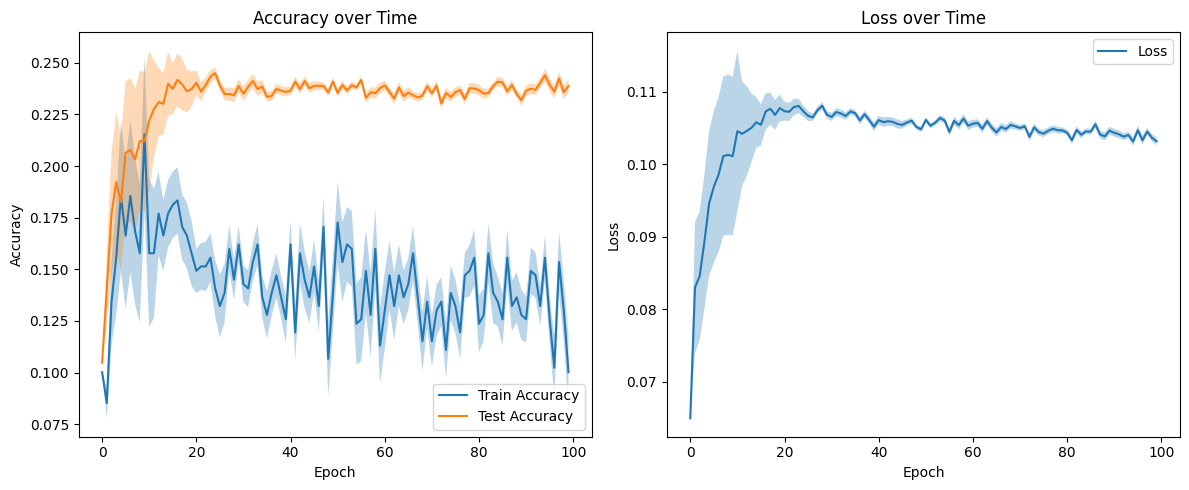

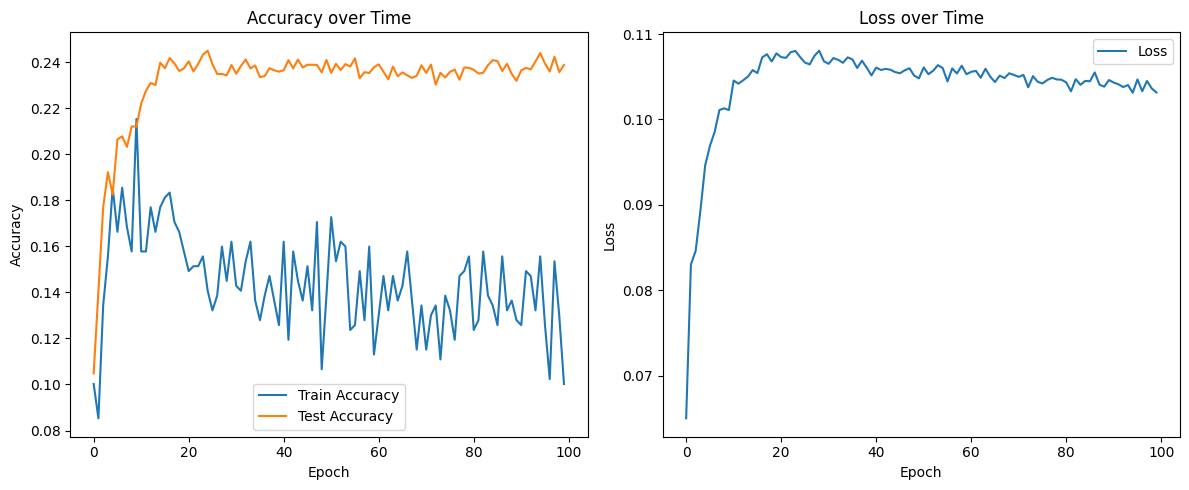

Final Train Accuracy: 0.10 ± 0.02
Final Test Accuracy: 0.24 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730649622:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.0440785189204887
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730649622:   1%|          | 1/100 [00:04<07:02,  4.27s/it]

 Test accuracy:  0.1291

correct: 40 total: 469
loss: 0.05313859706017763
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730649622:   2%|▏         | 2/100 [00:08<07:21,  4.51s/it]

 Test accuracy:  0.1363

correct: 70 total: 469
loss: 0.060450513765756
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649622:   3%|▎         | 3/100 [00:13<07:23,  4.58s/it]

 Test accuracy:  0.1479

correct: 78 total: 469
loss: 0.06724667838260309
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730649622:   4%|▍         | 4/100 [00:18<07:28,  4.67s/it]

 Test accuracy:  0.1618

correct: 63 total: 469
loss: 0.07013375643315091
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649622:   5%|▌         | 5/100 [00:22<07:20,  4.64s/it]

 Test accuracy:  0.1699

correct: 81 total: 469
loss: 0.0732393667562557
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730649622:   6%|▌         | 6/100 [00:27<07:15,  4.63s/it]

 Test accuracy:  0.1778

correct: 87 total: 469
loss: 0.07638959305436373
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649622:   7%|▋         | 7/100 [00:32<07:15,  4.68s/it]

 Test accuracy:  0.1861

correct: 88 total: 469
loss: 0.08009757985597227
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730649622:   8%|▊         | 8/100 [00:37<07:08,  4.66s/it]

 Test accuracy:  0.1814

correct: 80 total: 469
loss: 0.08326768652716679
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730649622:   9%|▉         | 9/100 [00:41<07:05,  4.68s/it]

 Test accuracy:  0.187

correct: 85 total: 469
loss: 0.08436509704729642
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730649622:  10%|█         | 10/100 [00:46<07:02,  4.70s/it]

 Test accuracy:  0.1904

correct: 77 total: 469
loss: 0.08694438990562964
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730649622:  11%|█         | 11/100 [00:51<07:00,  4.73s/it]

 Test accuracy:  0.197

correct: 80 total: 469
loss: 0.08834494860060434
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730649622:  12%|█▏        | 12/100 [00:55<06:55,  4.73s/it]

 Test accuracy:  0.1911

correct: 79 total: 469
loss: 0.08929348155570183
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730649622:  13%|█▎        | 13/100 [01:00<06:54,  4.76s/it]

 Test accuracy:  0.1909

correct: 94 total: 469
loss: 0.0913227856127438
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  14%|█▍        | 14/100 [01:05<06:48,  4.75s/it]

 Test accuracy:  0.1944

correct: 94 total: 469
loss: 0.09314175645933985
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  15%|█▌        | 15/100 [01:10<06:46,  4.78s/it]

 Test accuracy:  0.1952

correct: 91 total: 469
loss: 0.09397701688730387
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730649622:  16%|█▌        | 16/100 [01:15<06:43,  4.81s/it]

 Test accuracy:  0.199

correct: 107 total: 469
loss: 0.09695630145670255
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730649622:  17%|█▋        | 17/100 [01:20<06:41,  4.84s/it]

 Test accuracy:  0.2053

correct: 90 total: 469
loss: 0.0976340045679861
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  18%|█▊        | 18/100 [01:25<06:37,  4.85s/it]

 Test accuracy:  0.2003

correct: 81 total: 469
loss: 0.09768959991077879
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730649622:  19%|█▉        | 19/100 [01:29<06:33,  4.85s/it]

 Test accuracy:  0.1964

correct: 111 total: 469
loss: 0.0984756891438956
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730649622:  20%|██        | 20/100 [01:34<06:28,  4.86s/it]

 Test accuracy:  0.2062

correct: 94 total: 469
loss: 0.10083551182230907
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  21%|██        | 21/100 [01:39<06:26,  4.89s/it]

 Test accuracy:  0.1971

correct: 86 total: 469
loss: 0.10028633457828941
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730649622:  22%|██▏       | 22/100 [01:44<06:22,  4.91s/it]

 Test accuracy:  0.2043

correct: 98 total: 469
loss: 0.10320664475213236
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730649622:  23%|██▎       | 23/100 [01:49<06:20,  4.94s/it]

 Test accuracy:  0.2026

correct: 89 total: 469
loss: 0.10292536369773117
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730649622:  24%|██▍       | 24/100 [01:54<06:20,  5.00s/it]

 Test accuracy:  0.2027

correct: 110 total: 469
loss: 0.10357717564428794
 Train accuracy:  0.2345415778251599 | 


MLP_MNIST_0_1730649622:  25%|██▌       | 25/100 [01:59<06:16,  5.02s/it]

 Test accuracy:  0.1987

correct: 102 total: 469
loss: 0.10440367136174428
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730649622:  26%|██▌       | 26/100 [02:04<06:08,  4.98s/it]

 Test accuracy:  0.2027

correct: 100 total: 469
loss: 0.10577734828249478
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730649622:  27%|██▋       | 27/100 [02:09<06:02,  4.97s/it]

 Test accuracy:  0.2031

correct: 95 total: 469
loss: 0.10661712991022097
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730649622:  28%|██▊       | 28/100 [02:14<05:57,  4.97s/it]

 Test accuracy:  0.2046

correct: 87 total: 469
loss: 0.10621877289466512
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649622:  29%|██▉       | 29/100 [02:19<05:52,  4.96s/it]

 Test accuracy:  0.2033

correct: 79 total: 469
loss: 0.10742265311703245
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730649622:  30%|███       | 30/100 [02:24<05:50,  5.01s/it]

 Test accuracy:  0.1985

correct: 89 total: 469
loss: 0.10745370589784467
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730649622:  31%|███       | 31/100 [02:29<05:46,  5.02s/it]

 Test accuracy:  0.2054

correct: 91 total: 469
loss: 0.10763062703520504
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730649622:  32%|███▏      | 32/100 [02:34<05:42,  5.03s/it]

 Test accuracy:  0.2073

correct: 90 total: 469
loss: 0.10729128211291868
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  33%|███▎      | 33/100 [02:40<05:38,  5.05s/it]

 Test accuracy:  0.2092

correct: 91 total: 469
loss: 0.10852620671235168
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730649622:  34%|███▍      | 34/100 [02:45<05:33,  5.05s/it]

 Test accuracy:  0.2029

correct: 95 total: 469
loss: 0.10845580390457914
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730649622:  35%|███▌      | 35/100 [02:50<05:36,  5.17s/it]

 Test accuracy:  0.2032

correct: 94 total: 469
loss: 0.10813695502115973
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  36%|███▌      | 36/100 [02:55<05:31,  5.17s/it]

 Test accuracy:  0.2067

correct: 83 total: 469
loss: 0.10824699987417091
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730649622:  37%|███▋      | 37/100 [03:00<05:24,  5.16s/it]

 Test accuracy:  0.2043

correct: 90 total: 469
loss: 0.11006417605223687
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  38%|███▊      | 38/100 [03:05<05:18,  5.13s/it]

 Test accuracy:  0.2068

correct: 85 total: 469
loss: 0.10900992458499571
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730649622:  39%|███▉      | 39/100 [03:10<05:11,  5.11s/it]

 Test accuracy:  0.2028

correct: 87 total: 469
loss: 0.10869944114674891
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649622:  40%|████      | 40/100 [03:16<05:07,  5.13s/it]

 Test accuracy:  0.2057

correct: 90 total: 469
loss: 0.10929002215676724
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  41%|████      | 41/100 [03:21<05:02,  5.13s/it]

 Test accuracy:  0.204

correct: 110 total: 469
loss: 0.10965945004527249
 Train accuracy:  0.2345415778251599 | 


MLP_MNIST_0_1730649622:  42%|████▏     | 42/100 [03:26<04:56,  5.11s/it]

 Test accuracy:  0.2073

correct: 101 total: 469
loss: 0.11071205809553548
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730649622:  43%|████▎     | 43/100 [03:31<04:54,  5.17s/it]

 Test accuracy:  0.2092

correct: 97 total: 469
loss: 0.11184079076117798
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730649622:  44%|████▍     | 44/100 [03:36<04:50,  5.18s/it]

 Test accuracy:  0.2094

correct: 86 total: 469
loss: 0.11127820545867054
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730649622:  45%|████▌     | 45/100 [03:42<04:46,  5.21s/it]

 Test accuracy:  0.2056

correct: 100 total: 469
loss: 0.11094864683428299
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730649622:  46%|████▌     | 46/100 [03:47<04:39,  5.17s/it]

 Test accuracy:  0.21

correct: 96 total: 469
loss: 0.11120731315251861
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730649622:  47%|████▋     | 47/100 [03:52<04:34,  5.18s/it]

 Test accuracy:  0.2028

correct: 87 total: 469
loss: 0.11164633138601714
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649622:  48%|████▊     | 48/100 [03:57<04:27,  5.15s/it]

 Test accuracy:  0.211

correct: 93 total: 469
loss: 0.11145707224604925
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730649622:  49%|████▉     | 49/100 [04:02<04:27,  5.25s/it]

 Test accuracy:  0.2062

correct: 90 total: 469
loss: 0.11184004899154086
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  50%|█████     | 50/100 [04:08<04:21,  5.23s/it]

 Test accuracy:  0.2037

correct: 93 total: 469
loss: 0.11194154821924054
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730649622:  51%|█████     | 51/100 [04:13<04:15,  5.21s/it]

 Test accuracy:  0.1973

correct: 111 total: 469
loss: 0.11229765396128331
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730649622:  52%|█████▏    | 52/100 [04:18<04:09,  5.20s/it]

 Test accuracy:  0.2041

correct: 105 total: 469
loss: 0.11310295403194326
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730649622:  53%|█████▎    | 53/100 [04:23<04:02,  5.17s/it]

 Test accuracy:  0.2005

correct: 89 total: 469
loss: 0.11242489653355531
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730649622:  54%|█████▍    | 54/100 [04:28<03:58,  5.18s/it]

 Test accuracy:  0.2037

correct: 94 total: 469
loss: 0.11350957664853728
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  55%|█████▌    | 55/100 [04:34<03:55,  5.23s/it]

 Test accuracy:  0.2058

correct: 87 total: 469
loss: 0.11293881116454789
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649622:  56%|█████▌    | 56/100 [04:39<03:47,  5.18s/it]

 Test accuracy:  0.2052

correct: 98 total: 469
loss: 0.11334043911207459
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730649622:  57%|█████▋    | 57/100 [04:44<03:41,  5.16s/it]

 Test accuracy:  0.2041

correct: 103 total: 469
loss: 0.11424076107582812
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730649622:  58%|█████▊    | 58/100 [04:49<03:36,  5.16s/it]

 Test accuracy:  0.1962

correct: 107 total: 469
loss: 0.11349787264426889
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730649622:  59%|█████▉    | 59/100 [04:54<03:30,  5.13s/it]

 Test accuracy:  0.2077

correct: 97 total: 469
loss: 0.1134376137781499
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730649622:  60%|██████    | 60/100 [04:59<03:25,  5.14s/it]

 Test accuracy:  0.2054

correct: 101 total: 469
loss: 0.11434872322944181
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730649622:  61%|██████    | 61/100 [05:04<03:21,  5.18s/it]

 Test accuracy:  0.2052

correct: 104 total: 469
loss: 0.11448668358104824
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730649622:  62%|██████▏   | 62/100 [05:10<03:16,  5.18s/it]

 Test accuracy:  0.2089

correct: 94 total: 469
loss: 0.11386560642325294
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  63%|██████▎   | 63/100 [05:15<03:11,  5.18s/it]

 Test accuracy:  0.2065

correct: 90 total: 469
loss: 0.11464465296725983
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  64%|██████▍   | 64/100 [05:20<03:07,  5.20s/it]

 Test accuracy:  0.21

correct: 97 total: 469
loss: 0.1157163752516958
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730649622:  65%|██████▌   | 65/100 [05:25<03:01,  5.19s/it]

 Test accuracy:  0.2048

correct: 105 total: 469
loss: 0.11551924555032238
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730649622:  66%|██████▌   | 66/100 [05:30<02:56,  5.19s/it]

 Test accuracy:  0.2039

correct: 97 total: 469
loss: 0.11564042762334921
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730649622:  67%|██████▋   | 67/100 [05:36<02:52,  5.21s/it]

 Test accuracy:  0.2048

correct: 102 total: 469
loss: 0.11520704185403487
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730649622:  68%|██████▊   | 68/100 [05:41<02:46,  5.20s/it]

 Test accuracy:  0.2059

correct: 93 total: 469
loss: 0.1151314772554298
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730649622:  69%|██████▉   | 69/100 [05:46<02:40,  5.17s/it]

 Test accuracy:  0.2061

correct: 90 total: 469
loss: 0.11473950270269472
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730649622:  70%|███████   | 70/100 [05:51<02:36,  5.21s/it]

 Test accuracy:  0.2094

correct: 96 total: 469
loss: 0.11610540561775155
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730649622:  71%|███████   | 71/100 [05:56<02:30,  5.17s/it]

 Test accuracy:  0.2079

correct: 89 total: 469
loss: 0.1149327193718475
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730649622:  72%|███████▏  | 72/100 [06:02<02:29,  5.33s/it]

 Test accuracy:  0.2115

correct: 94 total: 469
loss: 0.11639613885360994
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  73%|███████▎  | 73/100 [06:07<02:23,  5.31s/it]

 Test accuracy:  0.2072

correct: 89 total: 469
loss: 0.11599449826074816
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730649622:  74%|███████▍  | 74/100 [06:12<02:16,  5.26s/it]

 Test accuracy:  0.2061

correct: 101 total: 469
loss: 0.1161190578138142
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730649622:  75%|███████▌  | 75/100 [06:18<02:10,  5.22s/it]

 Test accuracy:  0.2047

correct: 108 total: 469
loss: 0.116060820294977
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730649622:  76%|███████▌  | 76/100 [06:23<02:06,  5.27s/it]

 Test accuracy:  0.2059

correct: 95 total: 469
loss: 0.11556808010283817
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730649622:  77%|███████▋  | 77/100 [06:28<02:00,  5.24s/it]

 Test accuracy:  0.207

correct: 97 total: 469
loss: 0.11605498564840634
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730649622:  78%|███████▊  | 78/100 [06:33<01:54,  5.21s/it]

 Test accuracy:  0.2021

correct: 109 total: 469
loss: 0.11612409335781516
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730649622:  79%|███████▉  | 79/100 [06:39<01:50,  5.26s/it]

 Test accuracy:  0.2115

correct: 94 total: 469
loss: 0.11681027994798954
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730649622:  80%|████████  | 80/100 [06:44<01:45,  5.26s/it]

 Test accuracy:  0.2041

correct: 110 total: 469
loss: 0.1162390678898612
 Train accuracy:  0.2345415778251599 | 


MLP_MNIST_0_1730649622:  81%|████████  | 81/100 [06:49<01:40,  5.28s/it]

 Test accuracy:  0.203

correct: 96 total: 469
loss: 0.11697145738899073
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730649622:  82%|████████▏ | 82/100 [06:55<01:35,  5.31s/it]

 Test accuracy:  0.2047

correct: 105 total: 469
loss: 0.11648702915352799
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730649622:  83%|████████▎ | 83/100 [07:00<01:30,  5.31s/it]

 Test accuracy:  0.1975

correct: 100 total: 469
loss: 0.11636292915354406
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730649622:  84%|████████▍ | 84/100 [07:05<01:24,  5.29s/it]

 Test accuracy:  0.208

correct: 99 total: 469
loss: 0.11742049598617595
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730649622:  85%|████████▌ | 85/100 [07:11<01:20,  5.33s/it]

 Test accuracy:  0.2062

correct: 102 total: 469
loss: 0.11695315966855234
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730649622:  86%|████████▌ | 86/100 [07:16<01:14,  5.32s/it]

 Test accuracy:  0.1974

correct: 93 total: 469
loss: 0.11731477369314064
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730649622:  87%|████████▋ | 87/100 [07:21<01:09,  5.32s/it]

 Test accuracy:  0.2012

correct: 101 total: 469
loss: 0.11702483765352001
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730649622:  88%|████████▊ | 88/100 [07:27<01:04,  5.35s/it]

 Test accuracy:  0.2039

correct: 86 total: 469
loss: 0.11691113674183136
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730649622:  89%|████████▉ | 89/100 [07:32<00:59,  5.39s/it]

 Test accuracy:  0.2048

correct: 102 total: 469
loss: 0.11683457322529893
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730649622:  90%|█████████ | 90/100 [07:38<00:54,  5.41s/it]

 Test accuracy:  0.2098

correct: 98 total: 469
loss: 0.1175263645901863
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730649622:  91%|█████████ | 91/100 [07:43<00:48,  5.43s/it]

 Test accuracy:  0.2053

correct: 96 total: 469
loss: 0.11790811640621503
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730649622:  92%|█████████▏| 92/100 [07:48<00:43,  5.41s/it]

 Test accuracy:  0.1967

correct: 95 total: 469
loss: 0.1177831950631223
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730649622:  93%|█████████▎| 93/100 [07:54<00:37,  5.38s/it]

 Test accuracy:  0.2145

correct: 100 total: 469
loss: 0.1177225654472166
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730649622:  94%|█████████▍| 94/100 [07:59<00:32,  5.38s/it]

 Test accuracy:  0.1961

correct: 93 total: 469
loss: 0.11767607258517605
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730649622:  95%|█████████▌| 95/100 [08:04<00:26,  5.38s/it]

 Test accuracy:  0.2017

correct: 87 total: 469
loss: 0.11783534445678756
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730649622:  96%|█████████▌| 96/100 [08:10<00:21,  5.38s/it]

 Test accuracy:  0.2022

correct: 105 total: 469
loss: 0.11753712596097735
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730649622:  97%|█████████▋| 97/100 [08:15<00:16,  5.40s/it]

 Test accuracy:  0.1978

correct: 96 total: 469
loss: 0.11734720348104485
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730649622:  98%|█████████▊| 98/100 [08:21<00:10,  5.37s/it]

 Test accuracy:  0.1959

correct: 83 total: 469
loss: 0.11701642359688338
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730649622:  99%|█████████▉| 99/100 [08:26<00:05,  5.37s/it]

 Test accuracy:  0.201

correct: 101 total: 469
loss: 0.11820487102974198
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730649622: 100%|██████████| 100/100 [08:31<00:00,  5.12s/it]

 Test accuracy:  0.2077


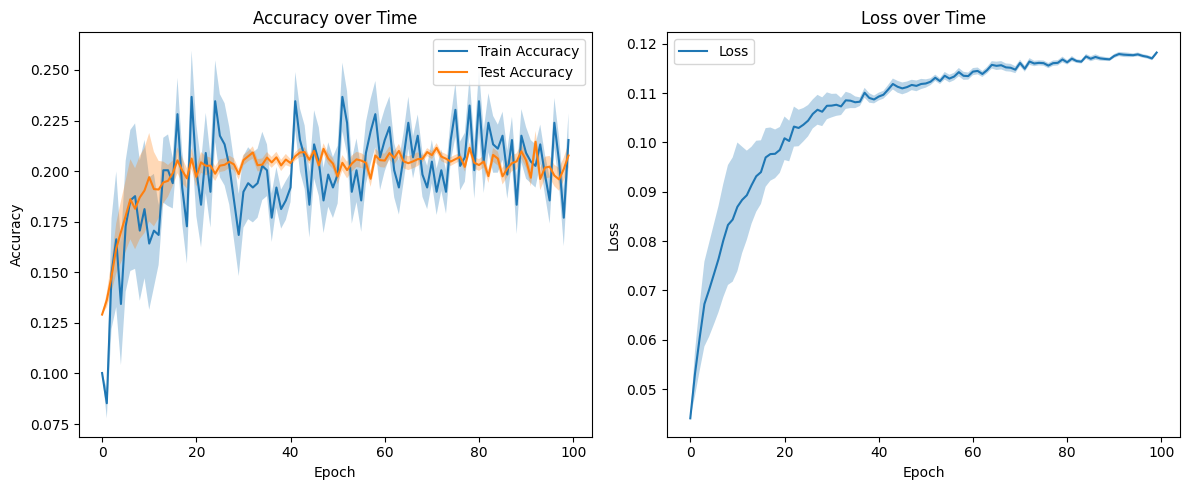

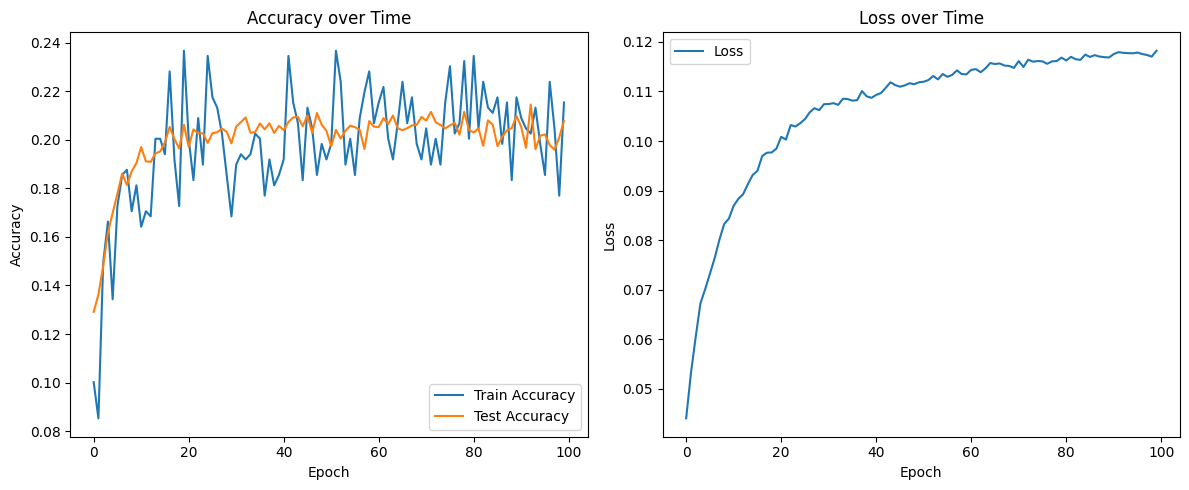

Final Train Accuracy: 0.22 ± 0.01
Final Test Accuracy: 0.21 ± 0.01
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730650138:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.05320608945511806
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730650138:   1%|          | 1/100 [00:04<08:09,  4.94s/it]

 Test accuracy:  0.4568

correct: 40 total: 469
loss: 0.06139463189441258
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730650138:   2%|▏         | 2/100 [00:10<08:18,  5.09s/it]

 Test accuracy:  0.5064

correct: 262 total: 469
loss: 0.07444900488739074
 Train accuracy:  0.55863539445629 | 


MLP_MNIST_0_1730650138:   3%|▎         | 3/100 [00:15<08:17,  5.12s/it]

 Test accuracy:  0.5465

correct: 261 total: 469
loss: 0.08790173372035341
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730650138:   4%|▍         | 4/100 [00:20<08:14,  5.15s/it]

 Test accuracy:  0.5926

correct: 277 total: 469
loss: 0.09666759690750382
 Train accuracy:  0.5906183368869936 | 


MLP_MNIST_0_1730650138:   5%|▌         | 5/100 [00:25<08:17,  5.24s/it]

 Test accuracy:  0.6149

correct: 296 total: 469
loss: 0.10086531838628529
 Train accuracy:  0.6311300639658849 | 


MLP_MNIST_0_1730650138:   6%|▌         | 6/100 [00:31<08:19,  5.31s/it]

 Test accuracy:  0.62

correct: 298 total: 469
loss: 0.1020177486640558
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1730650138:   7%|▋         | 7/100 [00:36<08:20,  5.38s/it]

 Test accuracy:  0.6281

correct: 302 total: 469
loss: 0.1047351110909285
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730650138:   8%|▊         | 8/100 [00:42<08:21,  5.45s/it]

 Test accuracy:  0.6435

correct: 287 total: 469
loss: 0.10778057325814071
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1730650138:   9%|▉         | 9/100 [00:47<08:15,  5.45s/it]

 Test accuracy:  0.6472

correct: 319 total: 469
loss: 0.10887775503432573
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1730650138:  10%|█         | 10/100 [00:53<08:11,  5.46s/it]

 Test accuracy:  0.6505

correct: 302 total: 469
loss: 0.11089211422751453
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730650138:  11%|█         | 11/100 [00:58<08:04,  5.45s/it]

 Test accuracy:  0.6475

correct: 305 total: 469
loss: 0.11235381643782293
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730650138:  12%|█▏        | 12/100 [01:04<08:06,  5.52s/it]

 Test accuracy:  0.6511

correct: 312 total: 469
loss: 0.1140573539141653
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730650138:  13%|█▎        | 13/100 [01:10<08:01,  5.54s/it]

 Test accuracy:  0.6551

correct: 320 total: 469
loss: 0.11505001383041268
 Train accuracy:  0.6823027718550106 | 


MLP_MNIST_0_1730650138:  14%|█▍        | 14/100 [01:15<08:01,  5.60s/it]

 Test accuracy:  0.6582

correct: 306 total: 469
loss: 0.11411047728458193
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  15%|█▌        | 15/100 [01:21<07:55,  5.59s/it]

 Test accuracy:  0.66

correct: 317 total: 469
loss: 0.1157590591036943
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730650138:  16%|█▌        | 16/100 [01:27<07:53,  5.63s/it]

 Test accuracy:  0.6541

correct: 327 total: 469
loss: 0.1171148836390296
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1730650138:  17%|█▋        | 17/100 [01:32<07:46,  5.62s/it]

 Test accuracy:  0.6594

correct: 334 total: 469
loss: 0.11749082514599188
 Train accuracy:  0.7121535181236673 | 


MLP_MNIST_0_1730650138:  18%|█▊        | 18/100 [01:38<07:42,  5.64s/it]

 Test accuracy:  0.6568

correct: 323 total: 469
loss: 0.11723653829174001
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1730650138:  19%|█▉        | 19/100 [01:44<07:38,  5.66s/it]

 Test accuracy:  0.6608

correct: 309 total: 469
loss: 0.11824602918075855
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1730650138:  20%|██        | 20/100 [01:49<07:31,  5.65s/it]

 Test accuracy:  0.6634

correct: 319 total: 469
loss: 0.11851350264127321
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1730650138:  21%|██        | 21/100 [01:55<07:36,  5.77s/it]

 Test accuracy:  0.6603

correct: 314 total: 469
loss: 0.11904272599133855
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730650138:  22%|██▏       | 22/100 [02:01<07:28,  5.75s/it]

 Test accuracy:  0.6591

correct: 302 total: 469
loss: 0.12005555329482946
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730650138:  23%|██▎       | 23/100 [02:07<07:21,  5.73s/it]

 Test accuracy:  0.6587

correct: 318 total: 469
loss: 0.12129490175989391
 Train accuracy:  0.6780383795309168 | 


MLP_MNIST_0_1730650138:  24%|██▍       | 24/100 [02:13<07:18,  5.77s/it]

 Test accuracy:  0.6573

correct: 316 total: 469
loss: 0.12135526164571868
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  25%|██▌       | 25/100 [02:18<07:15,  5.81s/it]

 Test accuracy:  0.659

correct: 312 total: 469
loss: 0.1215660962850046
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730650138:  26%|██▌       | 26/100 [02:24<07:10,  5.82s/it]

 Test accuracy:  0.6614

correct: 306 total: 469
loss: 0.12189748486094891
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  27%|██▋       | 27/100 [02:30<07:03,  5.80s/it]

 Test accuracy:  0.6646

correct: 305 total: 469
loss: 0.12272571657957045
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730650138:  28%|██▊       | 28/100 [02:36<06:58,  5.82s/it]

 Test accuracy:  0.6637

correct: 315 total: 469
loss: 0.12161934668067167
 Train accuracy:  0.6716417910447762 | 


MLP_MNIST_0_1730650138:  29%|██▉       | 29/100 [02:42<06:53,  5.83s/it]

 Test accuracy:  0.6631

correct: 306 total: 469
loss: 0.12287363533907608
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  30%|███       | 30/100 [02:48<06:50,  5.87s/it]

 Test accuracy:  0.6647

correct: 307 total: 469
loss: 0.1231447481302056
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730650138:  31%|███       | 31/100 [02:54<06:48,  5.92s/it]

 Test accuracy:  0.6625

correct: 313 total: 469
loss: 0.1234991025727695
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1730650138:  32%|███▏      | 32/100 [03:00<06:42,  5.91s/it]

 Test accuracy:  0.6645

correct: 306 total: 469
loss: 0.12344900971409609
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  33%|███▎      | 33/100 [03:06<06:35,  5.90s/it]

 Test accuracy:  0.6593

correct: 314 total: 469
loss: 0.1234663626246615
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730650138:  34%|███▍      | 34/100 [03:11<06:28,  5.89s/it]

 Test accuracy:  0.6657

correct: 311 total: 469
loss: 0.12429911943513956
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  35%|███▌      | 35/100 [03:17<06:21,  5.87s/it]

 Test accuracy:  0.654

correct: 314 total: 469
loss: 0.12429771067173497
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730650138:  36%|███▌      | 36/100 [03:23<06:17,  5.90s/it]

 Test accuracy:  0.6683

correct: 324 total: 469
loss: 0.1242453130895395
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1730650138:  37%|███▋      | 37/100 [03:29<06:10,  5.88s/it]

 Test accuracy:  0.6618

correct: 310 total: 469
loss: 0.12529424161735628
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1730650138:  38%|███▊      | 38/100 [03:35<06:04,  5.88s/it]

 Test accuracy:  0.668

correct: 306 total: 469
loss: 0.12421379162113803
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  39%|███▉      | 39/100 [03:41<05:57,  5.85s/it]

 Test accuracy:  0.6647

correct: 320 total: 469
loss: 0.12375192970101005
 Train accuracy:  0.6823027718550106 | 


MLP_MNIST_0_1730650138:  40%|████      | 40/100 [03:47<05:51,  5.86s/it]

 Test accuracy:  0.6642

correct: 307 total: 469
loss: 0.12484268850482094
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730650138:  41%|████      | 41/100 [03:53<05:47,  5.89s/it]

 Test accuracy:  0.6632

correct: 316 total: 469
loss: 0.12450410589289818
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  42%|████▏     | 42/100 [03:58<05:38,  5.84s/it]

 Test accuracy:  0.6649

correct: 311 total: 469
loss: 0.1252236454916407
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  43%|████▎     | 43/100 [04:04<05:31,  5.82s/it]

 Test accuracy:  0.6671

correct: 336 total: 469
loss: 0.12520821243206828
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1730650138:  44%|████▍     | 44/100 [04:10<05:26,  5.83s/it]

 Test accuracy:  0.6595

correct: 310 total: 469
loss: 0.12693678033250227
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1730650138:  45%|████▌     | 45/100 [04:16<05:20,  5.83s/it]

 Test accuracy:  0.6637

correct: 309 total: 469
loss: 0.12562547177711783
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1730650138:  46%|████▌     | 46/100 [04:22<05:14,  5.82s/it]

 Test accuracy:  0.661

correct: 302 total: 469
loss: 0.125537093768496
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730650138:  47%|████▋     | 47/100 [04:28<05:11,  5.88s/it]

 Test accuracy:  0.6639

correct: 305 total: 469
loss: 0.1269233249969828
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730650138:  48%|████▊     | 48/100 [04:33<05:03,  5.85s/it]

 Test accuracy:  0.6679

correct: 316 total: 469
loss: 0.12618114694412838
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  49%|████▉     | 49/100 [04:39<04:57,  5.83s/it]

 Test accuracy:  0.6644

correct: 327 total: 469
loss: 0.12625622715967805
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1730650138:  50%|█████     | 50/100 [04:45<04:51,  5.83s/it]

 Test accuracy:  0.6572

correct: 316 total: 469
loss: 0.1271990923357925
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  51%|█████     | 51/100 [04:51<04:44,  5.81s/it]

 Test accuracy:  0.6636

correct: 296 total: 469
loss: 0.12645548542361779
 Train accuracy:  0.6311300639658849 | 


MLP_MNIST_0_1730650138:  52%|█████▏    | 52/100 [04:57<04:40,  5.85s/it]

 Test accuracy:  0.6554

correct: 305 total: 469
loss: 0.12709171440936864
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730650138:  53%|█████▎    | 53/100 [05:02<04:33,  5.81s/it]

 Test accuracy:  0.6642

correct: 317 total: 469
loss: 0.1267299144379874
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730650138:  54%|█████▍    | 54/100 [05:08<04:27,  5.82s/it]

 Test accuracy:  0.6653

correct: 324 total: 469
loss: 0.12738545099174037
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1730650138:  55%|█████▌    | 55/100 [05:14<04:22,  5.84s/it]

 Test accuracy:  0.658

correct: 311 total: 469
loss: 0.12680802462515292
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  56%|█████▌    | 56/100 [05:20<04:15,  5.81s/it]

 Test accuracy:  0.6632

correct: 296 total: 469
loss: 0.1269144339919853
 Train accuracy:  0.6311300639658849 | 


MLP_MNIST_0_1730650138:  57%|█████▋    | 57/100 [05:26<04:10,  5.82s/it]

 Test accuracy:  0.6669

correct: 326 total: 469
loss: 0.12724729822769856
 Train accuracy:  0.6950959488272921 | 


MLP_MNIST_0_1730650138:  58%|█████▊    | 58/100 [05:32<04:08,  5.91s/it]

 Test accuracy:  0.6641

correct: 324 total: 469
loss: 0.1279757240338366
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1730650138:  59%|█████▉    | 59/100 [05:38<04:02,  5.92s/it]

 Test accuracy:  0.6658

correct: 308 total: 469
loss: 0.12789968539402682
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1730650138:  60%|██████    | 60/100 [05:44<03:55,  5.89s/it]

 Test accuracy:  0.6657

correct: 318 total: 469
loss: 0.12785149224277245
 Train accuracy:  0.6780383795309168 | 


MLP_MNIST_0_1730650138:  61%|██████    | 61/100 [05:49<03:49,  5.87s/it]

 Test accuracy:  0.6585

correct: 326 total: 469
loss: 0.12838564273009676
 Train accuracy:  0.6950959488272921 | 


MLP_MNIST_0_1730650138:  62%|██████▏   | 62/100 [05:55<03:43,  5.88s/it]

 Test accuracy:  0.6642

correct: 316 total: 469
loss: 0.127399024837561
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  63%|██████▎   | 63/100 [06:01<03:39,  5.93s/it]

 Test accuracy:  0.6648

correct: 311 total: 469
loss: 0.12803610690684716
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  64%|██████▍   | 64/100 [06:07<03:33,  5.94s/it]

 Test accuracy:  0.6654

correct: 312 total: 469
loss: 0.12798099777401128
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730650138:  65%|██████▌   | 65/100 [06:13<03:28,  5.95s/it]

 Test accuracy:  0.6691

correct: 311 total: 469
loss: 0.12763388893370436
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  66%|██████▌   | 66/100 [06:19<03:23,  5.98s/it]

 Test accuracy:  0.661

correct: 317 total: 469
loss: 0.12794974914936622
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730650138:  67%|██████▋   | 67/100 [06:25<03:17,  5.99s/it]

 Test accuracy:  0.6605

correct: 328 total: 469
loss: 0.1279701269321096
 Train accuracy:  0.6993603411513859 | 


MLP_MNIST_0_1730650138:  68%|██████▊   | 68/100 [06:31<03:11,  6.00s/it]

 Test accuracy:  0.6606

correct: 309 total: 469
loss: 0.1282931257571493
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1730650138:  69%|██████▉   | 69/100 [06:38<03:09,  6.11s/it]

 Test accuracy:  0.6637

correct: 315 total: 469
loss: 0.12848623373361032
 Train accuracy:  0.6716417910447762 | 


MLP_MNIST_0_1730650138:  70%|███████   | 70/100 [06:44<03:02,  6.08s/it]

 Test accuracy:  0.6653

correct: 328 total: 469
loss: 0.12832550910998508
 Train accuracy:  0.6993603411513859 | 


MLP_MNIST_0_1730650138:  71%|███████   | 71/100 [06:50<02:54,  6.02s/it]

 Test accuracy:  0.664

correct: 311 total: 469
loss: 0.12840065866835845
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  72%|███████▏  | 72/100 [06:56<02:48,  6.03s/it]

 Test accuracy:  0.6673

correct: 308 total: 469
loss: 0.12817933296026196
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1730650138:  73%|███████▎  | 73/100 [07:02<02:43,  6.06s/it]

 Test accuracy:  0.6617

correct: 317 total: 469
loss: 0.12878403083474904
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730650138:  74%|███████▍  | 74/100 [07:08<02:37,  6.06s/it]

 Test accuracy:  0.6656

correct: 326 total: 469
loss: 0.1290099217312168
 Train accuracy:  0.6950959488272921 | 


MLP_MNIST_0_1730650138:  75%|███████▌  | 75/100 [07:14<02:31,  6.06s/it]

 Test accuracy:  0.6593

correct: 309 total: 469
loss: 0.12916948970383418
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1730650138:  76%|███████▌  | 76/100 [07:20<02:25,  6.05s/it]

 Test accuracy:  0.6642

correct: 306 total: 469
loss: 0.12862233951020596
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  77%|███████▋  | 77/100 [07:26<02:18,  6.03s/it]

 Test accuracy:  0.6622

correct: 327 total: 469
loss: 0.12825075193826577
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1730650138:  78%|███████▊  | 78/100 [07:32<02:13,  6.06s/it]

 Test accuracy:  0.6648

correct: 313 total: 469
loss: 0.12922222083057167
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1730650138:  79%|███████▉  | 79/100 [07:38<02:09,  6.16s/it]

 Test accuracy:  0.6663

correct: 311 total: 469
loss: 0.12858949580998308
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730650138:  80%|████████  | 80/100 [07:44<02:02,  6.12s/it]

 Test accuracy:  0.6591

correct: 317 total: 469
loss: 0.12918426455465207
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730650138:  81%|████████  | 81/100 [07:50<01:55,  6.09s/it]

 Test accuracy:  0.6594

correct: 309 total: 469
loss: 0.12889527235585235
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1730650138:  82%|████████▏ | 82/100 [07:57<01:49,  6.09s/it]

 Test accuracy:  0.6594

correct: 307 total: 469
loss: 0.12865487800668807
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730650138:  83%|████████▎ | 83/100 [08:03<01:43,  6.07s/it]

 Test accuracy:  0.6619

correct: 307 total: 469
loss: 0.1282839804474733
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730650138:  84%|████████▍ | 84/100 [08:09<01:37,  6.10s/it]

 Test accuracy:  0.6635

correct: 304 total: 469
loss: 0.12934450740054218
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1730650138:  85%|████████▌ | 85/100 [08:15<01:31,  6.11s/it]

 Test accuracy:  0.6679

correct: 314 total: 469
loss: 0.12883738398170674
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730650138:  86%|████████▌ | 86/100 [08:21<01:25,  6.11s/it]

 Test accuracy:  0.6627

correct: 321 total: 469
loss: 0.12917544200285666
 Train accuracy:  0.6844349680170576 | 


MLP_MNIST_0_1730650138:  87%|████████▋ | 87/100 [08:27<01:19,  6.13s/it]

 Test accuracy:  0.6628

correct: 315 total: 469
loss: 0.1289888224494991
 Train accuracy:  0.6716417910447762 | 


MLP_MNIST_0_1730650138:  88%|████████▊ | 88/100 [08:33<01:14,  6.17s/it]

 Test accuracy:  0.666

correct: 318 total: 469
loss: 0.1289934092588516
 Train accuracy:  0.6780383795309168 | 


MLP_MNIST_0_1730650138:  89%|████████▉ | 89/100 [08:40<01:07,  6.15s/it]

 Test accuracy:  0.6651

correct: 315 total: 469
loss: 0.12992052762493142
 Train accuracy:  0.6716417910447762 | 


MLP_MNIST_0_1730650138:  90%|█████████ | 90/100 [08:46<01:01,  6.13s/it]

 Test accuracy:  0.662

correct: 306 total: 469
loss: 0.12960109038393636
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730650138:  91%|█████████ | 91/100 [08:52<00:55,  6.14s/it]

 Test accuracy:  0.667

correct: 316 total: 469
loss: 0.12879956238813747
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  92%|█████████▏| 92/100 [08:58<00:48,  6.12s/it]

 Test accuracy:  0.6677

correct: 322 total: 469
loss: 0.12865639236499507
 Train accuracy:  0.6865671641791045 | 


MLP_MNIST_0_1730650138:  93%|█████████▎| 93/100 [09:04<00:42,  6.13s/it]

 Test accuracy:  0.6582

correct: 323 total: 469
loss: 0.12903795610549354
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1730650138:  94%|█████████▍| 94/100 [09:10<00:37,  6.17s/it]

 Test accuracy:  0.6611

correct: 324 total: 469
loss: 0.12935745298290557
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1730650138:  95%|█████████▌| 95/100 [09:16<00:30,  6.17s/it]

 Test accuracy:  0.6646

correct: 316 total: 469
loss: 0.128993852067985
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730650138:  96%|█████████▌| 96/100 [09:23<00:24,  6.15s/it]

 Test accuracy:  0.6628

correct: 310 total: 469
loss: 0.12856433809057735
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1730650138:  97%|█████████▋| 97/100 [09:29<00:18,  6.14s/it]

 Test accuracy:  0.6545

correct: 310 total: 469
loss: 0.12907305820537274
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1730650138:  98%|█████████▊| 98/100 [09:35<00:12,  6.13s/it]

 Test accuracy:  0.6546

correct: 330 total: 469
loss: 0.1290325216615378
 Train accuracy:  0.7036247334754797 | 


MLP_MNIST_0_1730650138:  99%|█████████▉| 99/100 [09:41<00:06,  6.16s/it]

 Test accuracy:  0.6606

correct: 317 total: 469
loss: 0.12919009854989266
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730650138: 100%|██████████| 100/100 [09:47<00:00,  5.88s/it]

 Test accuracy:  0.6619


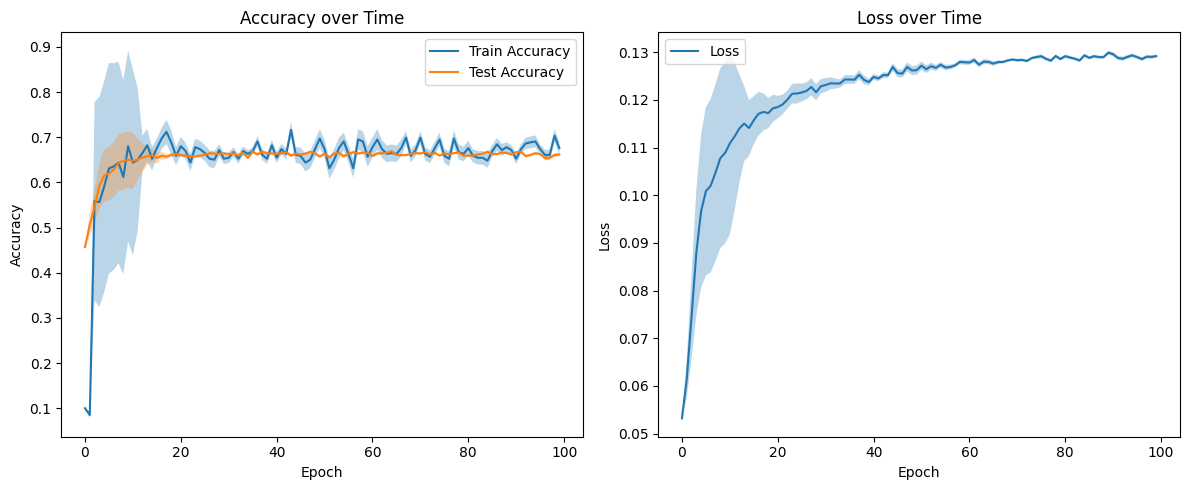

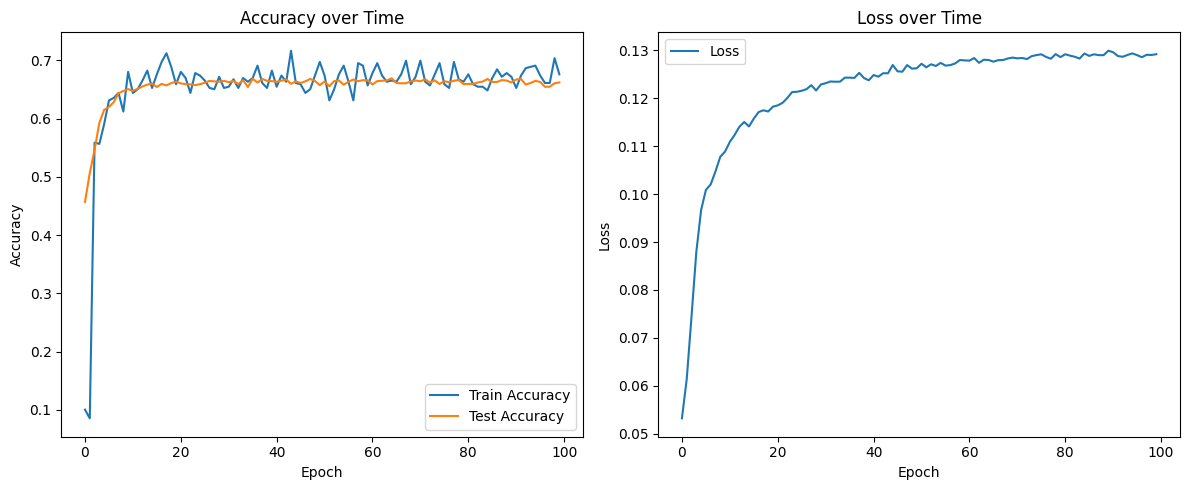

Final Train Accuracy: 0.68 ± 0.01
Final Test Accuracy: 0.66 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730650729:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.06600827644311034
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730650729:   1%|          | 1/100 [00:04<07:46,  4.72s/it]

 Test accuracy:  0.1

correct: 40 total: 469
loss: 0.08637132864993519
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730650729:   2%|▏         | 2/100 [00:09<07:49,  4.79s/it]

 Test accuracy:  0.1695

correct: 91 total: 469
loss: 0.08982584997217284
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730650729:   3%|▎         | 3/100 [00:14<07:52,  4.87s/it]

 Test accuracy:  0.1981

correct: 86 total: 469
loss: 0.09680789002159765
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730650729:   4%|▍         | 4/100 [00:19<08:07,  5.07s/it]

 Test accuracy:  0.1947

correct: 83 total: 469
loss: 0.09813210428523611
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730650729:   5%|▌         | 5/100 [00:25<08:31,  5.38s/it]

 Test accuracy:  0.2021

correct: 109 total: 469
loss: 0.09973746925783056
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:   6%|▌         | 6/100 [00:31<08:40,  5.53s/it]

 Test accuracy:  0.2108

correct: 94 total: 469
loss: 0.10132583853468966
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730650729:   7%|▋         | 7/100 [00:37<08:41,  5.61s/it]

 Test accuracy:  0.2132

correct: 104 total: 469
loss: 0.10251200955305527
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730650729:   8%|▊         | 8/100 [00:43<08:46,  5.72s/it]

 Test accuracy:  0.2406

correct: 135 total: 469
loss: 0.10525173341223934
 Train accuracy:  0.2878464818763326 | 


MLP_MNIST_0_1730650729:   9%|▉         | 9/100 [00:49<08:44,  5.76s/it]

 Test accuracy:  0.2567

correct: 137 total: 469
loss: 0.10634307210633495
 Train accuracy:  0.2921108742004264 | 


MLP_MNIST_0_1730650729:  10%|█         | 10/100 [00:55<08:44,  5.82s/it]

 Test accuracy:  0.226

correct: 113 total: 469
loss: 0.10869774130234586
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  11%|█         | 11/100 [01:01<08:38,  5.82s/it]

 Test accuracy:  0.25

correct: 113 total: 469
loss: 0.10886664845859573
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  12%|█▏        | 12/100 [01:07<08:43,  5.95s/it]

 Test accuracy:  0.2459

correct: 118 total: 469
loss: 0.11002663888339041
 Train accuracy:  0.2515991471215352 | 


MLP_MNIST_0_1730650729:  13%|█▎        | 13/100 [01:13<08:47,  6.06s/it]

 Test accuracy:  0.236

correct: 113 total: 469
loss: 0.11037431655725691
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  14%|█▍        | 14/100 [01:19<08:47,  6.13s/it]

 Test accuracy:  0.2419

correct: 123 total: 469
loss: 0.11046106064878801
 Train accuracy:  0.2622601279317697 | 


MLP_MNIST_0_1730650729:  15%|█▌        | 15/100 [01:26<08:48,  6.22s/it]

 Test accuracy:  0.2334

correct: 110 total: 469
loss: 0.11152971148300272
 Train accuracy:  0.2345415778251599 | 


MLP_MNIST_0_1730650729:  16%|█▌        | 16/100 [01:32<08:47,  6.28s/it]

 Test accuracy:  0.2288

correct: 121 total: 469
loss: 0.11159586927085034
 Train accuracy:  0.2579957356076759 | 


MLP_MNIST_0_1730650729:  17%|█▋        | 17/100 [01:38<08:40,  6.27s/it]

 Test accuracy:  0.236

correct: 91 total: 469
loss: 0.11278310413363138
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730650729:  18%|█▊        | 18/100 [01:45<08:34,  6.27s/it]

 Test accuracy:  0.2378

correct: 105 total: 469
loss: 0.11127483388826029
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730650729:  19%|█▉        | 19/100 [01:51<08:30,  6.30s/it]

 Test accuracy:  0.239

correct: 100 total: 469
loss: 0.11235008175883975
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730650729:  20%|██        | 20/100 [01:57<08:26,  6.33s/it]

 Test accuracy:  0.2398

correct: 101 total: 469
loss: 0.11210354072834129
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650729:  21%|██        | 21/100 [02:04<08:20,  6.34s/it]

 Test accuracy:  0.2409

correct: 109 total: 469
loss: 0.11206772040202419
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  22%|██▏       | 22/100 [02:10<08:14,  6.34s/it]

 Test accuracy:  0.2407

correct: 125 total: 469
loss: 0.1132795144436456
 Train accuracy:  0.26652452025586354 | 


MLP_MNIST_0_1730650729:  23%|██▎       | 23/100 [02:17<08:08,  6.35s/it]

 Test accuracy:  0.2395

correct: 122 total: 469
loss: 0.11312595700849094
 Train accuracy:  0.2601279317697228 | 


MLP_MNIST_0_1730650729:  24%|██▍       | 24/100 [02:23<08:01,  6.33s/it]

 Test accuracy:  0.2389

correct: 109 total: 469
loss: 0.11303945668915441
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  25%|██▌       | 25/100 [02:29<07:58,  6.38s/it]

 Test accuracy:  0.2399

correct: 110 total: 469
loss: 0.11408428754061778
 Train accuracy:  0.2345415778251599 | 


MLP_MNIST_0_1730650729:  26%|██▌       | 26/100 [02:36<07:50,  6.36s/it]

 Test accuracy:  0.2351

correct: 95 total: 469
loss: 0.11385777181209024
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730650729:  27%|██▋       | 27/100 [02:42<07:42,  6.34s/it]

 Test accuracy:  0.241

correct: 114 total: 469
loss: 0.11414600184350125
 Train accuracy:  0.24307036247334754 | 


MLP_MNIST_0_1730650729:  28%|██▊       | 28/100 [02:48<07:35,  6.33s/it]

 Test accuracy:  0.2405

correct: 112 total: 469
loss: 0.11416772851494075
 Train accuracy:  0.23880597014925373 | 


MLP_MNIST_0_1730650729:  29%|██▉       | 29/100 [02:55<07:32,  6.37s/it]

 Test accuracy:  0.2388

correct: 111 total: 469
loss: 0.11470051349670903
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730650729:  30%|███       | 30/100 [03:02<07:35,  6.51s/it]

 Test accuracy:  0.2386

correct: 113 total: 469
loss: 0.11443388725775899
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  31%|███       | 31/100 [03:08<07:25,  6.45s/it]

 Test accuracy:  0.2386

correct: 115 total: 469
loss: 0.11505292004931456
 Train accuracy:  0.24520255863539445 | 


MLP_MNIST_0_1730650729:  32%|███▏      | 32/100 [03:14<07:17,  6.44s/it]

 Test accuracy:  0.2391

correct: 118 total: 469
loss: 0.1140972966673786
 Train accuracy:  0.2515991471215352 | 


MLP_MNIST_0_1730650729:  33%|███▎      | 33/100 [03:21<07:09,  6.42s/it]

 Test accuracy:  0.2402

correct: 107 total: 469
loss: 0.11491257975350565
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730650729:  34%|███▍      | 34/100 [03:27<07:04,  6.43s/it]

 Test accuracy:  0.2393

correct: 120 total: 469
loss: 0.1151378293758008
 Train accuracy:  0.255863539445629 | 


MLP_MNIST_0_1730650729:  35%|███▌      | 35/100 [03:34<06:59,  6.45s/it]

 Test accuracy:  0.239

correct: 101 total: 469
loss: 0.11582460789792319
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650729:  36%|███▌      | 36/100 [03:40<06:50,  6.42s/it]

 Test accuracy:  0.2386

correct: 103 total: 469
loss: 0.1145761280076336
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650729:  37%|███▋      | 37/100 [03:46<06:45,  6.43s/it]

 Test accuracy:  0.238

correct: 108 total: 469
loss: 0.11484429958278436
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  38%|███▊      | 38/100 [03:53<06:38,  6.43s/it]

 Test accuracy:  0.2384

correct: 109 total: 469
loss: 0.11432177282726841
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  39%|███▉      | 39/100 [03:59<06:31,  6.41s/it]

 Test accuracy:  0.2386

correct: 108 total: 469
loss: 0.11441995993034164
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  40%|████      | 40/100 [04:06<06:28,  6.47s/it]

 Test accuracy:  0.2363

correct: 101 total: 469
loss: 0.11501812933286878
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650729:  41%|████      | 41/100 [04:12<06:20,  6.45s/it]

 Test accuracy:  0.2368

correct: 119 total: 469
loss: 0.11470399611095376
 Train accuracy:  0.2537313432835821 | 


MLP_MNIST_0_1730650729:  42%|████▏     | 42/100 [04:19<06:14,  6.46s/it]

 Test accuracy:  0.2389

correct: 116 total: 469
loss: 0.11521054699476849
 Train accuracy:  0.24733475479744135 | 


MLP_MNIST_0_1730650729:  43%|████▎     | 43/100 [04:25<06:09,  6.48s/it]

 Test accuracy:  0.2394

correct: 109 total: 469
loss: 0.11488794770512754
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  44%|████▍     | 44/100 [04:32<06:02,  6.47s/it]

 Test accuracy:  0.2394

correct: 119 total: 469
loss: 0.1153753769359609
 Train accuracy:  0.2537313432835821 | 


MLP_MNIST_0_1730650729:  45%|████▌     | 45/100 [04:38<05:57,  6.50s/it]

 Test accuracy:  0.2377

correct: 126 total: 469
loss: 0.11485863157681056
 Train accuracy:  0.26865671641791045 | 


MLP_MNIST_0_1730650729:  46%|████▌     | 46/100 [04:45<05:51,  6.51s/it]

 Test accuracy:  0.2384

correct: 101 total: 469
loss: 0.11524442573790865
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650729:  47%|████▋     | 47/100 [04:51<05:45,  6.51s/it]

 Test accuracy:  0.237

correct: 108 total: 469
loss: 0.11631609791758726
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  48%|████▊     | 48/100 [04:58<05:38,  6.50s/it]

 Test accuracy:  0.2399

correct: 99 total: 469
loss: 0.11548073742308342
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650729:  49%|████▉     | 49/100 [05:04<05:32,  6.52s/it]

 Test accuracy:  0.239

correct: 124 total: 469
loss: 0.11567610408515056
 Train accuracy:  0.26439232409381663 | 


MLP_MNIST_0_1730650729:  50%|█████     | 50/100 [05:11<05:28,  6.58s/it]

 Test accuracy:  0.2392

correct: 116 total: 469
loss: 0.11568742431303077
 Train accuracy:  0.24733475479744135 | 


MLP_MNIST_0_1730650729:  51%|█████     | 51/100 [05:18<05:21,  6.57s/it]

 Test accuracy:  0.2388

correct: 107 total: 469
loss: 0.11519965218074286
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730650729:  52%|█████▏    | 52/100 [05:24<05:16,  6.59s/it]

 Test accuracy:  0.2364

correct: 103 total: 469
loss: 0.11551063663479108
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650729:  53%|█████▎    | 53/100 [05:31<05:09,  6.58s/it]

 Test accuracy:  0.2374

correct: 114 total: 469
loss: 0.11592622169617142
 Train accuracy:  0.24307036247334754 | 


MLP_MNIST_0_1730650729:  54%|█████▍    | 54/100 [05:37<05:02,  6.57s/it]

 Test accuracy:  0.2362

correct: 129 total: 469
loss: 0.11634247897784593
 Train accuracy:  0.27505330490405117 | 


MLP_MNIST_0_1730650729:  55%|█████▌    | 55/100 [05:44<04:58,  6.64s/it]

 Test accuracy:  0.2395

correct: 100 total: 469
loss: 0.11532309535406292
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730650729:  56%|█████▌    | 56/100 [05:51<04:50,  6.60s/it]

 Test accuracy:  0.2389

correct: 115 total: 469
loss: 0.11514581079040763
 Train accuracy:  0.24520255863539445 | 


MLP_MNIST_0_1730650729:  57%|█████▋    | 57/100 [05:57<04:43,  6.60s/it]

 Test accuracy:  0.2387

correct: 118 total: 469
loss: 0.11588636475966684
 Train accuracy:  0.2515991471215352 | 


MLP_MNIST_0_1730650729:  58%|█████▊    | 58/100 [06:04<04:37,  6.61s/it]

 Test accuracy:  0.2372

correct: 104 total: 469
loss: 0.11583507197625093
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730650729:  59%|█████▉    | 59/100 [06:10<04:30,  6.61s/it]

 Test accuracy:  0.2394

correct: 103 total: 469
loss: 0.11634926795006306
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650729:  60%|██████    | 60/100 [06:17<04:26,  6.66s/it]

 Test accuracy:  0.239

correct: 121 total: 469
loss: 0.11616911189451909
 Train accuracy:  0.2579957356076759 | 


MLP_MNIST_0_1730650729:  61%|██████    | 61/100 [06:24<04:18,  6.63s/it]

 Test accuracy:  0.238

correct: 119 total: 469
loss: 0.11604517127976997
 Train accuracy:  0.2537313432835821 | 


MLP_MNIST_0_1730650729:  62%|██████▏   | 62/100 [06:30<04:10,  6.59s/it]

 Test accuracy:  0.2368

correct: 105 total: 469
loss: 0.11584493260520862
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730650729:  63%|██████▎   | 63/100 [06:37<04:04,  6.60s/it]

 Test accuracy:  0.2384

correct: 108 total: 469
loss: 0.11675910824842291
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  64%|██████▍   | 64/100 [06:44<04:00,  6.67s/it]

 Test accuracy:  0.2392

correct: 114 total: 469
loss: 0.11608173731547683
 Train accuracy:  0.24307036247334754 | 


MLP_MNIST_0_1730650729:  65%|██████▌   | 65/100 [06:50<03:52,  6.66s/it]

 Test accuracy:  0.2415

correct: 108 total: 469
loss: 0.11612804505680162
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  66%|██████▌   | 66/100 [06:57<03:46,  6.66s/it]

 Test accuracy:  0.2369

correct: 120 total: 469
loss: 0.11635216474850803
 Train accuracy:  0.255863539445629 | 


MLP_MNIST_0_1730650729:  67%|██████▋   | 67/100 [07:04<03:39,  6.65s/it]

 Test accuracy:  0.2411

correct: 108 total: 469
loss: 0.11557227752800943
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  68%|██████▊   | 68/100 [07:10<03:32,  6.64s/it]

 Test accuracy:  0.2408

correct: 113 total: 469
loss: 0.11671832292827207
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  69%|██████▉   | 69/100 [07:17<03:27,  6.68s/it]

 Test accuracy:  0.2379

correct: 115 total: 469
loss: 0.11596321203370592
 Train accuracy:  0.24520255863539445 | 


MLP_MNIST_0_1730650729:  70%|███████   | 70/100 [07:24<03:19,  6.66s/it]

 Test accuracy:  0.2417

correct: 124 total: 469
loss: 0.11652844214935039
 Train accuracy:  0.26439232409381663 | 


MLP_MNIST_0_1730650729:  71%|███████   | 71/100 [07:30<03:12,  6.64s/it]

 Test accuracy:  0.2366

correct: 116 total: 469
loss: 0.11730175876795355
 Train accuracy:  0.24733475479744135 | 


MLP_MNIST_0_1730650729:  72%|███████▏  | 72/100 [07:37<03:05,  6.63s/it]

 Test accuracy:  0.2379

correct: 100 total: 469
loss: 0.11615936059369715
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730650729:  73%|███████▎  | 73/100 [07:44<02:59,  6.65s/it]

 Test accuracy:  0.2377

correct: 108 total: 469
loss: 0.11557378724757542
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729:  74%|███████▍  | 74/100 [07:50<02:54,  6.73s/it]

 Test accuracy:  0.2371

correct: 109 total: 469
loss: 0.11632260302109505
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  75%|███████▌  | 75/100 [07:57<02:47,  6.69s/it]

 Test accuracy:  0.24

correct: 119 total: 469
loss: 0.11672940740643788
 Train accuracy:  0.2537313432835821 | 


MLP_MNIST_0_1730650729:  76%|███████▌  | 76/100 [08:04<02:40,  6.69s/it]

 Test accuracy:  0.24

correct: 107 total: 469
loss: 0.1165162978618384
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730650729:  77%|███████▋  | 77/100 [08:10<02:33,  6.66s/it]

 Test accuracy:  0.2377

correct: 121 total: 469
loss: 0.11728949562064621
 Train accuracy:  0.2579957356076759 | 


MLP_MNIST_0_1730650729:  78%|███████▊  | 78/100 [08:17<02:27,  6.69s/it]

 Test accuracy:  0.2384

correct: 112 total: 469
loss: 0.11679375978675224
 Train accuracy:  0.23880597014925373 | 


MLP_MNIST_0_1730650729:  79%|███████▉  | 79/100 [08:24<02:21,  6.73s/it]

 Test accuracy:  0.2376

correct: 107 total: 469
loss: 0.11673947553962533
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730650729:  80%|████████  | 80/100 [08:31<02:13,  6.69s/it]

 Test accuracy:  0.2367

correct: 113 total: 469
loss: 0.11661285997580872
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  81%|████████  | 81/100 [08:37<02:06,  6.68s/it]

 Test accuracy:  0.2385

correct: 107 total: 469
loss: 0.11619393313045441
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730650729:  82%|████████▏ | 82/100 [08:44<02:00,  6.69s/it]

 Test accuracy:  0.2368

correct: 115 total: 469
loss: 0.11645734511903608
 Train accuracy:  0.24520255863539445 | 


MLP_MNIST_0_1730650729:  83%|████████▎ | 83/100 [08:51<01:53,  6.69s/it]

 Test accuracy:  0.2378

correct: 109 total: 469
loss: 0.11571147275377693
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  84%|████████▍ | 84/100 [08:57<01:47,  6.70s/it]

 Test accuracy:  0.2381

correct: 111 total: 469
loss: 0.11677006606671855
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730650729:  85%|████████▌ | 85/100 [09:04<01:40,  6.71s/it]

 Test accuracy:  0.2389

correct: 100 total: 469
loss: 0.11650526529944527
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730650729:  86%|████████▌ | 86/100 [09:11<01:34,  6.73s/it]

 Test accuracy:  0.2388

correct: 111 total: 469
loss: 0.11602650798841325
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730650729:  87%|████████▋ | 87/100 [09:18<01:27,  6.72s/it]

 Test accuracy:  0.237

correct: 116 total: 469
loss: 0.11647959854175795
 Train accuracy:  0.24733475479744135 | 


MLP_MNIST_0_1730650729:  88%|████████▊ | 88/100 [09:24<01:21,  6.77s/it]

 Test accuracy:  0.2391

correct: 127 total: 469
loss: 0.11602164987625598
 Train accuracy:  0.27078891257995735 | 


MLP_MNIST_0_1730650729:  89%|████████▉ | 89/100 [09:31<01:14,  6.76s/it]

 Test accuracy:  0.2379

correct: 109 total: 469
loss: 0.11725296426429423
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650729:  90%|█████████ | 90/100 [09:38<01:07,  6.76s/it]

 Test accuracy:  0.237

correct: 131 total: 469
loss: 0.11685016635320843
 Train accuracy:  0.279317697228145 | 


MLP_MNIST_0_1730650729:  91%|█████████ | 91/100 [09:45<01:02,  6.90s/it]

 Test accuracy:  0.2361

correct: 100 total: 469
loss: 0.11695566671743576
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730650729:  92%|█████████▏| 92/100 [09:52<00:55,  6.90s/it]

 Test accuracy:  0.2395

correct: 112 total: 469
loss: 0.11745890785953891
 Train accuracy:  0.23880597014925373 | 


MLP_MNIST_0_1730650729:  93%|█████████▎| 93/100 [09:59<00:48,  6.94s/it]

 Test accuracy:  0.2362

correct: 111 total: 469
loss: 0.11700812566763302
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730650729:  94%|█████████▍| 94/100 [10:06<00:41,  6.91s/it]

 Test accuracy:  0.2393

correct: 97 total: 469
loss: 0.11685117928267542
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730650729:  95%|█████████▌| 95/100 [10:13<00:34,  6.89s/it]

 Test accuracy:  0.2391

correct: 124 total: 469
loss: 0.11596792547115639
 Train accuracy:  0.26439232409381663 | 


MLP_MNIST_0_1730650729:  96%|█████████▌| 96/100 [10:20<00:27,  6.85s/it]

 Test accuracy:  0.2383

correct: 102 total: 469
loss: 0.11759023128478512
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730650729:  97%|█████████▋| 97/100 [10:26<00:20,  6.89s/it]

 Test accuracy:  0.2408

correct: 122 total: 469
loss: 0.11707260764674592
 Train accuracy:  0.2601279317697228 | 


MLP_MNIST_0_1730650729:  98%|█████████▊| 98/100 [10:33<00:13,  6.92s/it]

 Test accuracy:  0.236

correct: 113 total: 469
loss: 0.11636717933645127
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650729:  99%|█████████▉| 99/100 [10:40<00:06,  6.88s/it]

 Test accuracy:  0.24

correct: 108 total: 469
loss: 0.11712550991443174
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650729: 100%|██████████| 100/100 [10:47<00:00,  6.48s/it]

 Test accuracy:  0.2404


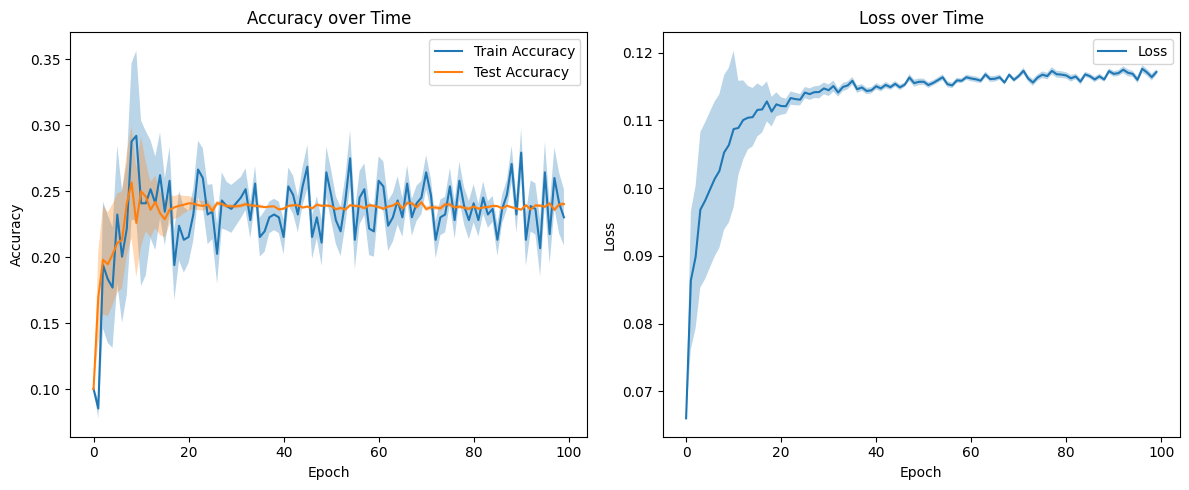

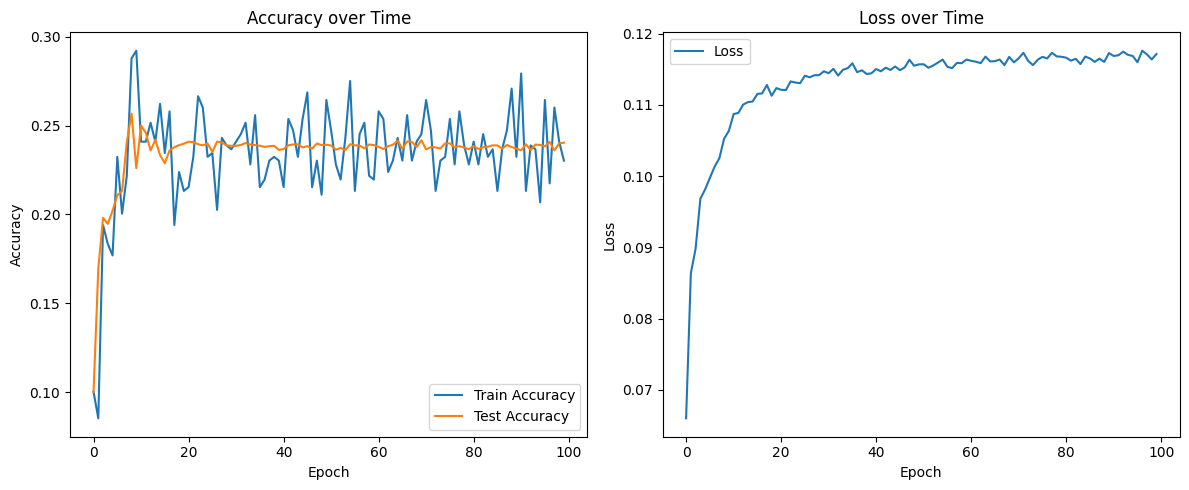

Final Train Accuracy: 0.23 ± 0.02
Final Test Accuracy: 0.24 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730651380:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.06220824857637572
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730651380:   1%|          | 1/100 [00:05<08:41,  5.27s/it]

 Test accuracy:  0.0988

correct: 40 total: 469
loss: 0.07701172265035511
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730651380:   2%|▏         | 2/100 [00:10<08:56,  5.47s/it]

 Test accuracy:  0.098

correct: 51 total: 469
loss: 0.07812875258261716
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651380:   3%|▎         | 3/100 [00:16<08:52,  5.49s/it]

 Test accuracy:  0.1188

correct: 48 total: 469
loss: 0.08277782666753096
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:   4%|▍         | 4/100 [00:22<08:51,  5.54s/it]

 Test accuracy:  0.0992

correct: 51 total: 469
loss: 0.08427049563542358
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651380:   5%|▌         | 5/100 [00:27<08:45,  5.53s/it]

 Test accuracy:  0.115

correct: 53 total: 469
loss: 0.08573829065730322
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651380:   6%|▌         | 6/100 [00:33<08:41,  5.54s/it]

 Test accuracy:  0.1102

correct: 43 total: 469
loss: 0.08518083875716877
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1730651380:   7%|▋         | 7/100 [00:38<08:38,  5.57s/it]

 Test accuracy:  0.1121

correct: 45 total: 469
loss: 0.08485037617401274
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730651380:   8%|▊         | 8/100 [00:44<08:42,  5.67s/it]

 Test accuracy:  0.1129

correct: 61 total: 469
loss: 0.08612907122669698
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651380:   9%|▉         | 9/100 [00:50<08:31,  5.62s/it]

 Test accuracy:  0.109

correct: 51 total: 469
loss: 0.0864820163498428
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651380:  10%|█         | 10/100 [00:55<08:29,  5.66s/it]

 Test accuracy:  0.1183

correct: 50 total: 469
loss: 0.08795325742410953
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730651380:  11%|█         | 11/100 [01:01<08:20,  5.63s/it]

 Test accuracy:  0.119

correct: 44 total: 469
loss: 0.08712779799662927
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651380:  12%|█▏        | 12/100 [01:07<08:14,  5.62s/it]

 Test accuracy:  0.1149

correct: 54 total: 469
loss: 0.08755304449116752
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651380:  13%|█▎        | 13/100 [01:12<08:17,  5.72s/it]

 Test accuracy:  0.1174

correct: 45 total: 469
loss: 0.08787016556270595
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730651380:  14%|█▍        | 14/100 [01:18<08:13,  5.74s/it]

 Test accuracy:  0.1177

correct: 61 total: 469
loss: 0.08716437613754384
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651380:  15%|█▌        | 15/100 [01:24<08:04,  5.70s/it]

 Test accuracy:  0.1227

correct: 47 total: 469
loss: 0.08819842823088042
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730651380:  16%|█▌        | 16/100 [01:30<07:58,  5.70s/it]

 Test accuracy:  0.1226

correct: 60 total: 469
loss: 0.0877116812285838
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651380:  17%|█▋        | 17/100 [01:35<07:53,  5.70s/it]

 Test accuracy:  0.1215

correct: 48 total: 469
loss: 0.08866907355151196
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  18%|█▊        | 18/100 [01:41<07:47,  5.71s/it]

 Test accuracy:  0.1233

correct: 55 total: 469
loss: 0.0879899509616498
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651380:  19%|█▉        | 19/100 [01:47<07:46,  5.76s/it]

 Test accuracy:  0.1126

correct: 47 total: 469
loss: 0.08911033300385038
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730651380:  20%|██        | 20/100 [01:53<07:39,  5.74s/it]

 Test accuracy:  0.1182

correct: 48 total: 469
loss: 0.08834605062725956
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  21%|██        | 21/100 [01:58<07:32,  5.73s/it]

 Test accuracy:  0.128

correct: 51 total: 469
loss: 0.0884272132489854
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651380:  22%|██▏       | 22/100 [02:04<07:28,  5.75s/it]

 Test accuracy:  0.1184

correct: 48 total: 469
loss: 0.08913434556584114
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  23%|██▎       | 23/100 [02:10<07:20,  5.71s/it]

 Test accuracy:  0.119

correct: 57 total: 469
loss: 0.08923137724907922
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651380:  24%|██▍       | 24/100 [02:16<07:17,  5.75s/it]

 Test accuracy:  0.1189

correct: 64 total: 469
loss: 0.09009547449791355
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730651380:  25%|██▌       | 25/100 [02:21<07:11,  5.76s/it]

 Test accuracy:  0.1204

correct: 64 total: 469
loss: 0.08939753248016717
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730651380:  26%|██▌       | 26/100 [02:27<07:04,  5.73s/it]

 Test accuracy:  0.1216

correct: 55 total: 469
loss: 0.0897905348238152
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651380:  27%|██▋       | 27/100 [02:33<06:58,  5.74s/it]

 Test accuracy:  0.1216

correct: 48 total: 469
loss: 0.09102771642492778
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  28%|██▊       | 28/100 [02:39<06:53,  5.74s/it]

 Test accuracy:  0.1204

correct: 63 total: 469
loss: 0.08946533766446083
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730651380:  29%|██▉       | 29/100 [02:44<06:47,  5.75s/it]

 Test accuracy:  0.1238

correct: 44 total: 469
loss: 0.0901071675407734
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651380:  30%|███       | 30/100 [02:50<06:45,  5.79s/it]

 Test accuracy:  0.1249

correct: 53 total: 469
loss: 0.09035699350683928
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651380:  31%|███       | 31/100 [02:56<06:40,  5.81s/it]

 Test accuracy:  0.1163

correct: 68 total: 469
loss: 0.09143144183003826
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730651380:  32%|███▏      | 32/100 [03:02<06:34,  5.79s/it]

 Test accuracy:  0.1197

correct: 58 total: 469
loss: 0.09041789498156322
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651380:  33%|███▎      | 33/100 [03:07<06:27,  5.78s/it]

 Test accuracy:  0.1242

correct: 57 total: 469
loss: 0.09087918789338456
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651380:  34%|███▍      | 34/100 [03:13<06:21,  5.79s/it]

 Test accuracy:  0.1168

correct: 66 total: 469
loss: 0.09212144229140108
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730651380:  35%|███▌      | 35/100 [03:19<06:17,  5.81s/it]

 Test accuracy:  0.1221

correct: 68 total: 469
loss: 0.09127365554700782
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730651380:  36%|███▌      | 36/100 [03:25<06:11,  5.81s/it]

 Test accuracy:  0.1231

correct: 67 total: 469
loss: 0.09122430722215283
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730651380:  37%|███▋      | 37/100 [03:31<06:05,  5.80s/it]

 Test accuracy:  0.1161

correct: 59 total: 469
loss: 0.09241253342519183
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651380:  38%|███▊      | 38/100 [03:36<05:57,  5.77s/it]

 Test accuracy:  0.1193

correct: 58 total: 469
loss: 0.0908761186513311
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651380:  39%|███▉      | 39/100 [03:42<05:51,  5.76s/it]

 Test accuracy:  0.1239

correct: 56 total: 469
loss: 0.09052368487789432
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  40%|████      | 40/100 [03:48<05:44,  5.75s/it]

 Test accuracy:  0.1168

correct: 65 total: 469
loss: 0.09264251153701658
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651380:  41%|████      | 41/100 [03:54<05:41,  5.80s/it]

 Test accuracy:  0.1219

correct: 56 total: 469
loss: 0.09293066170900616
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  42%|████▏     | 42/100 [04:00<05:36,  5.80s/it]

 Test accuracy:  0.1196

correct: 48 total: 469
loss: 0.09306531200912208
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  43%|████▎     | 43/100 [04:06<05:33,  5.84s/it]

 Test accuracy:  0.1184

correct: 58 total: 469
loss: 0.0926261682992678
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651380:  44%|████▍     | 44/100 [04:11<05:26,  5.83s/it]

 Test accuracy:  0.124

correct: 66 total: 469
loss: 0.09342882318346739
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730651380:  45%|████▌     | 45/100 [04:17<05:18,  5.80s/it]

 Test accuracy:  0.1209

correct: 70 total: 469
loss: 0.0920013064768777
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730651380:  46%|████▌     | 46/100 [04:23<05:16,  5.85s/it]

 Test accuracy:  0.1205

correct: 46 total: 469
loss: 0.09353800812192055
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730651380:  47%|████▋     | 47/100 [04:29<05:09,  5.84s/it]

 Test accuracy:  0.1201

correct: 62 total: 469
loss: 0.09398435113399523
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730651380:  48%|████▊     | 48/100 [04:35<05:05,  5.87s/it]

 Test accuracy:  0.1176

correct: 54 total: 469
loss: 0.09286389945507813
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651380:  49%|████▉     | 49/100 [04:41<04:58,  5.86s/it]

 Test accuracy:  0.1137

correct: 48 total: 469
loss: 0.0929465964436531
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  50%|█████     | 50/100 [04:46<04:52,  5.84s/it]

 Test accuracy:  0.115

correct: 41 total: 469
loss: 0.09385313660796009
 Train accuracy:  0.08742004264392324 | 


MLP_MNIST_0_1730651380:  51%|█████     | 51/100 [04:52<04:46,  5.84s/it]

 Test accuracy:  0.1209

correct: 48 total: 469
loss: 0.09214965014188274
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  52%|█████▏    | 52/100 [04:58<04:43,  5.91s/it]

 Test accuracy:  0.1191

correct: 55 total: 469
loss: 0.09294424495145456
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651380:  53%|█████▎    | 53/100 [05:04<04:36,  5.89s/it]

 Test accuracy:  0.1219

correct: 57 total: 469
loss: 0.0912321427864815
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651380:  54%|█████▍    | 54/100 [05:10<04:31,  5.91s/it]

 Test accuracy:  0.1191

correct: 62 total: 469
loss: 0.0927750869854681
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730651380:  55%|█████▌    | 55/100 [05:16<04:27,  5.94s/it]

 Test accuracy:  0.1186

correct: 48 total: 469
loss: 0.09208123629757844
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  56%|█████▌    | 56/100 [05:22<04:19,  5.90s/it]

 Test accuracy:  0.1177

correct: 67 total: 469
loss: 0.09368280245106357
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730651380:  57%|█████▋    | 57/100 [05:28<04:15,  5.94s/it]

 Test accuracy:  0.1181

correct: 61 total: 469
loss: 0.09265472851137617
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651380:  58%|█████▊    | 58/100 [05:34<04:09,  5.94s/it]

 Test accuracy:  0.1252

correct: 61 total: 469
loss: 0.09306130787012165
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651380:  59%|█████▉    | 59/100 [05:40<04:02,  5.92s/it]

 Test accuracy:  0.119

correct: 65 total: 469
loss: 0.09362594540248802
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651380:  60%|██████    | 60/100 [05:46<04:01,  6.03s/it]

 Test accuracy:  0.1223

correct: 45 total: 469
loss: 0.09228404840108936
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730651380:  61%|██████    | 61/100 [05:52<03:54,  6.01s/it]

 Test accuracy:  0.1182

correct: 56 total: 469
loss: 0.09371543693135796
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  62%|██████▏   | 62/100 [05:58<03:48,  6.02s/it]

 Test accuracy:  0.1199

correct: 61 total: 469
loss: 0.09251143829400606
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651380:  63%|██████▎   | 63/100 [06:04<03:42,  6.01s/it]

 Test accuracy:  0.122

correct: 61 total: 469
loss: 0.09284833461236852
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651380:  64%|██████▍   | 64/100 [06:10<03:35,  5.98s/it]

 Test accuracy:  0.1198

correct: 72 total: 469
loss: 0.09403566870766916
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730651380:  65%|██████▌   | 65/100 [06:16<03:29,  5.98s/it]

 Test accuracy:  0.1235

correct: 62 total: 469
loss: 0.09257643445055368
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730651380:  66%|██████▌   | 66/100 [06:22<03:23,  5.99s/it]

 Test accuracy:  0.1246

correct: 56 total: 469
loss: 0.09431860963704744
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  67%|██████▋   | 67/100 [06:28<03:17,  5.98s/it]

 Test accuracy:  0.1234

correct: 53 total: 469
loss: 0.09331110753675005
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651380:  68%|██████▊   | 68/100 [06:34<03:12,  6.01s/it]

 Test accuracy:  0.119

correct: 48 total: 469
loss: 0.09414069773132867
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  69%|██████▉   | 69/100 [06:40<03:05,  5.99s/it]

 Test accuracy:  0.1222

correct: 53 total: 469
loss: 0.09392795981819442
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651380:  70%|███████   | 70/100 [06:46<03:00,  6.01s/it]

 Test accuracy:  0.122

correct: 70 total: 469
loss: 0.09387627053362474
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730651380:  71%|███████   | 71/100 [06:52<02:53,  5.99s/it]

 Test accuracy:  0.1195

correct: 75 total: 469
loss: 0.09477424446834938
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730651380:  72%|███████▏  | 72/100 [06:58<02:46,  5.96s/it]

 Test accuracy:  0.1241

correct: 47 total: 469
loss: 0.09244647441006927
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730651380:  73%|███████▎  | 73/100 [07:04<02:42,  6.01s/it]

 Test accuracy:  0.1208

correct: 53 total: 469
loss: 0.09443503221087872
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651380:  74%|███████▍  | 74/100 [07:10<02:35,  5.99s/it]

 Test accuracy:  0.1192

correct: 65 total: 469
loss: 0.09388987659645487
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651380:  75%|███████▌  | 75/100 [07:16<02:29,  5.99s/it]

 Test accuracy:  0.1196

correct: 60 total: 469
loss: 0.09423164303686574
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651380:  76%|███████▌  | 76/100 [07:22<02:24,  6.01s/it]

 Test accuracy:  0.1209

correct: 48 total: 469
loss: 0.09426985450708536
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  77%|███████▋  | 77/100 [07:28<02:18,  6.01s/it]

 Test accuracy:  0.121

correct: 50 total: 469
loss: 0.09403570162366702
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730651380:  78%|███████▊  | 78/100 [07:34<02:13,  6.05s/it]

 Test accuracy:  0.1157

correct: 54 total: 469
loss: 0.09440751932958551
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651380:  79%|███████▉  | 79/100 [07:40<02:06,  6.01s/it]

 Test accuracy:  0.1212

correct: 55 total: 469
loss: 0.09392537152779891
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651380:  80%|████████  | 80/100 [07:46<02:00,  6.01s/it]

 Test accuracy:  0.1199

correct: 56 total: 469
loss: 0.09292195451412119
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  81%|████████  | 81/100 [07:52<01:53,  6.00s/it]

 Test accuracy:  0.1149

correct: 69 total: 469
loss: 0.0927726692402922
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730651380:  82%|████████▏ | 82/100 [07:58<01:48,  6.02s/it]

 Test accuracy:  0.1183

correct: 63 total: 469
loss: 0.09433357379456828
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730651380:  83%|████████▎ | 83/100 [08:04<01:42,  6.05s/it]

 Test accuracy:  0.1255

correct: 51 total: 469
loss: 0.09500984282000487
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651380:  84%|████████▍ | 84/100 [08:10<01:37,  6.06s/it]

 Test accuracy:  0.1158

correct: 42 total: 469
loss: 0.09406867149923402
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1730651380:  85%|████████▌ | 85/100 [08:16<01:30,  6.05s/it]

 Test accuracy:  0.1245

correct: 62 total: 469
loss: 0.09371466978367712
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730651380:  86%|████████▌ | 86/100 [08:23<01:25,  6.08s/it]

 Test accuracy:  0.1205

correct: 58 total: 469
loss: 0.09423980979459372
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651380:  87%|████████▋ | 87/100 [08:29<01:18,  6.07s/it]

 Test accuracy:  0.1209

correct: 56 total: 469
loss: 0.09413892488235603
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  88%|████████▊ | 88/100 [08:35<01:13,  6.09s/it]

 Test accuracy:  0.1185

correct: 52 total: 469
loss: 0.09355634624865264
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651380:  89%|████████▉ | 89/100 [08:41<01:07,  6.11s/it]

 Test accuracy:  0.1182

correct: 59 total: 469
loss: 0.09418406447113704
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651380:  90%|█████████ | 90/100 [08:47<01:00,  6.09s/it]

 Test accuracy:  0.1217

correct: 53 total: 469
loss: 0.0930064396499825
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651380:  91%|█████████ | 91/100 [08:53<00:55,  6.11s/it]

 Test accuracy:  0.1224

correct: 46 total: 469
loss: 0.09422640110066197
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730651380:  92%|█████████▏| 92/100 [08:59<00:48,  6.07s/it]

 Test accuracy:  0.1194

correct: 56 total: 469
loss: 0.09383958408128479
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  93%|█████████▎| 93/100 [09:05<00:42,  6.09s/it]

 Test accuracy:  0.1214

correct: 48 total: 469
loss: 0.09273195439882116
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651380:  94%|█████████▍| 94/100 [09:11<00:36,  6.14s/it]

 Test accuracy:  0.119

correct: 56 total: 469
loss: 0.09401598456762493
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  95%|█████████▌| 95/100 [09:18<00:30,  6.12s/it]

 Test accuracy:  0.1203

correct: 59 total: 469
loss: 0.09416176478809385
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651380:  96%|█████████▌| 96/100 [09:24<00:24,  6.12s/it]

 Test accuracy:  0.1181

correct: 60 total: 469
loss: 0.09329535190993027
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651380:  97%|█████████▋| 97/100 [09:30<00:18,  6.14s/it]

 Test accuracy:  0.12

correct: 56 total: 469
loss: 0.09369965646662183
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651380:  98%|█████████▊| 98/100 [09:36<00:12,  6.14s/it]

 Test accuracy:  0.1214

correct: 57 total: 469
loss: 0.09371448369390929
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651380:  99%|█████████▉| 99/100 [09:42<00:06,  6.20s/it]

 Test accuracy:  0.1246

correct: 45 total: 469
loss: 0.0941849971440301
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730651380: 100%|██████████| 100/100 [09:48<00:00,  5.89s/it]

 Test accuracy:  0.1197


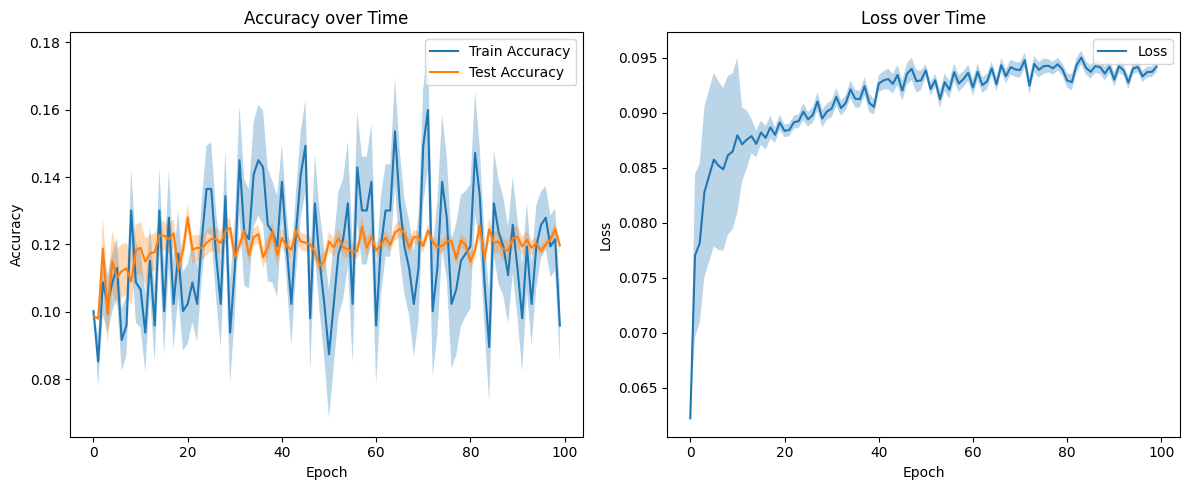

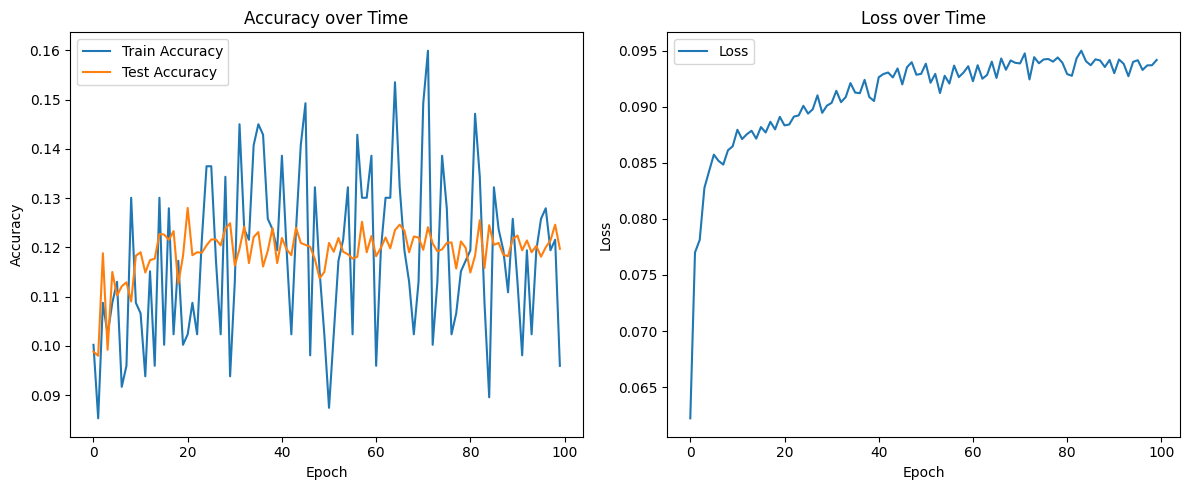

Final Train Accuracy: 0.10 ± 0.01
Final Test Accuracy: 0.12 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730651972:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.1958724572889205
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730651972:   1%|          | 1/100 [00:04<07:58,  4.83s/it]

 Test accuracy:  0.1066

correct: 40 total: 469
loss: 0.1774578637469298
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730651972:   2%|▏         | 2/100 [00:09<08:02,  4.93s/it]

 Test accuracy:  0.109

correct: 51 total: 469
loss: 0.1712589048262217
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972:   3%|▎         | 3/100 [00:14<07:55,  4.91s/it]

 Test accuracy:  0.1158

correct: 54 total: 469
loss: 0.14633434294446954
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651972:   4%|▍         | 4/100 [00:19<07:52,  4.92s/it]

 Test accuracy:  0.1118

correct: 53 total: 469
loss: 0.22505326618327262
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651972:   5%|▌         | 5/100 [00:24<07:53,  4.98s/it]

 Test accuracy:  0.1135

correct: 64 total: 469
loss: 0.17172533028256665
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730651972:   6%|▌         | 6/100 [00:29<07:45,  4.95s/it]

 Test accuracy:  0.1126

correct: 51 total: 469
loss: 0.15730343976699468
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972:   7%|▋         | 7/100 [00:34<07:42,  4.98s/it]

 Test accuracy:  0.1144

correct: 51 total: 469
loss: 0.13891096637923833
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972:   8%|▊         | 8/100 [00:39<07:40,  5.01s/it]

 Test accuracy:  0.1129

correct: 74 total: 469
loss: 0.11544589643507625
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730651972:   9%|▉         | 9/100 [00:44<07:34,  4.99s/it]

 Test accuracy:  0.1165

correct: 52 total: 469
loss: 0.10836233535428037
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651972:  10%|█         | 10/100 [00:49<07:29,  4.99s/it]

 Test accuracy:  0.1114

correct: 58 total: 469
loss: 0.10506943705430163
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651972:  11%|█         | 11/100 [00:54<07:25,  5.00s/it]

 Test accuracy:  0.113

correct: 57 total: 469
loss: 0.1031279971064535
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651972:  12%|█▏        | 12/100 [00:59<07:19,  4.99s/it]

 Test accuracy:  0.1156

correct: 50 total: 469
loss: 0.10122329269899234
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730651972:  13%|█▎        | 13/100 [01:04<07:13,  4.98s/it]

 Test accuracy:  0.1144

correct: 53 total: 469
loss: 0.09951535144499116
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651972:  14%|█▍        | 14/100 [01:09<07:10,  5.00s/it]

 Test accuracy:  0.1178

correct: 46 total: 469
loss: 0.10080755427320882
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730651972:  15%|█▌        | 15/100 [01:14<07:07,  5.03s/it]

 Test accuracy:  0.1223

correct: 55 total: 469
loss: 0.10164604286776423
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  16%|█▌        | 16/100 [01:19<07:06,  5.07s/it]

 Test accuracy:  0.1222

correct: 65 total: 469
loss: 0.10557270218441481
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651972:  17%|█▋        | 17/100 [01:25<07:01,  5.08s/it]

 Test accuracy:  0.1201

correct: 52 total: 469
loss: 0.11526355701786622
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651972:  18%|█▊        | 18/100 [01:30<06:56,  5.08s/it]

 Test accuracy:  0.1152

correct: 60 total: 469
loss: 0.10676037480454964
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651972:  19%|█▉        | 19/100 [01:35<06:50,  5.07s/it]

 Test accuracy:  0.1217

correct: 59 total: 469
loss: 0.10783546411597145
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651972:  20%|██        | 20/100 [01:40<06:43,  5.04s/it]

 Test accuracy:  0.1182

correct: 64 total: 469
loss: 0.10521058623851744
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730651972:  21%|██        | 21/100 [01:45<06:47,  5.16s/it]

 Test accuracy:  0.1147

correct: 55 total: 469
loss: 0.1039416762843315
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  22%|██▏       | 22/100 [01:50<06:39,  5.12s/it]

 Test accuracy:  0.1163

correct: 58 total: 469
loss: 0.10469233767310185
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651972:  23%|██▎       | 23/100 [01:55<06:35,  5.14s/it]

 Test accuracy:  0.1165

correct: 44 total: 469
loss: 0.1089716047874646
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651972:  24%|██▍       | 24/100 [02:00<06:31,  5.15s/it]

 Test accuracy:  0.119

correct: 58 total: 469
loss: 0.10808748799537037
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651972:  25%|██▌       | 25/100 [02:06<06:25,  5.14s/it]

 Test accuracy:  0.12

correct: 52 total: 469
loss: 0.10713524452404681
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651972:  26%|██▌       | 26/100 [02:11<06:19,  5.13s/it]

 Test accuracy:  0.1165

correct: 57 total: 469
loss: 0.1057168682183284
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651972:  27%|██▋       | 27/100 [02:16<06:11,  5.09s/it]

 Test accuracy:  0.1254

correct: 49 total: 469
loss: 0.10629453544995424
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730651972:  28%|██▊       | 28/100 [02:21<06:05,  5.08s/it]

 Test accuracy:  0.1184

correct: 52 total: 469
loss: 0.1084865833015076
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651972:  29%|██▉       | 29/100 [02:26<05:59,  5.06s/it]

 Test accuracy:  0.1162

correct: 64 total: 469
loss: 0.11026664397546224
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730651972:  30%|███       | 30/100 [02:31<05:56,  5.09s/it]

 Test accuracy:  0.1155

correct: 48 total: 469
loss: 0.10611634572812997
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  31%|███       | 31/100 [02:36<05:49,  5.06s/it]

 Test accuracy:  0.1178

correct: 48 total: 469
loss: 0.1061855197620036
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  32%|███▏      | 32/100 [02:41<05:45,  5.08s/it]

 Test accuracy:  0.1195

correct: 56 total: 469
loss: 0.10605522580365383
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651972:  33%|███▎      | 33/100 [02:46<05:39,  5.06s/it]

 Test accuracy:  0.1201

correct: 56 total: 469
loss: 0.10552103058107372
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651972:  34%|███▍      | 34/100 [02:51<05:34,  5.07s/it]

 Test accuracy:  0.1145

correct: 69 total: 469
loss: 0.10513102412541538
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730651972:  35%|███▌      | 35/100 [02:56<05:30,  5.08s/it]

 Test accuracy:  0.122

correct: 58 total: 469
loss: 0.10757258650399983
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651972:  36%|███▌      | 36/100 [03:01<05:27,  5.12s/it]

 Test accuracy:  0.1151

correct: 41 total: 469
loss: 0.10665014746791518
 Train accuracy:  0.08742004264392324 | 


MLP_MNIST_0_1730651972:  37%|███▋      | 37/100 [03:07<05:24,  5.15s/it]

 Test accuracy:  0.1202

correct: 46 total: 469
loss: 0.12417063309249085
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730651972:  38%|███▊      | 38/100 [03:12<05:19,  5.15s/it]

 Test accuracy:  0.1209

correct: 50 total: 469
loss: 0.13723632251657147
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730651972:  39%|███▉      | 39/100 [03:17<05:12,  5.12s/it]

 Test accuracy:  0.1133

correct: 52 total: 469
loss: 0.1407053745599952
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651972:  40%|████      | 40/100 [03:22<05:07,  5.12s/it]

 Test accuracy:  0.1148

correct: 57 total: 469
loss: 0.12757062050960719
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651972:  41%|████      | 41/100 [03:27<05:04,  5.15s/it]

 Test accuracy:  0.1185

correct: 50 total: 469
loss: 0.13505342550305668
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730651972:  42%|████▏     | 42/100 [03:33<05:01,  5.20s/it]

 Test accuracy:  0.122

correct: 64 total: 469
loss: 0.12865904094313763
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730651972:  43%|████▎     | 43/100 [03:38<04:57,  5.21s/it]

 Test accuracy:  0.1162

correct: 42 total: 469
loss: 0.11284207007778224
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1730651972:  44%|████▍     | 44/100 [03:43<04:51,  5.20s/it]

 Test accuracy:  0.1194

correct: 48 total: 469
loss: 0.12364931777913941
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  45%|████▌     | 45/100 [03:48<04:44,  5.18s/it]

 Test accuracy:  0.1252

correct: 55 total: 469
loss: 0.12898783711418668
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  46%|████▌     | 46/100 [03:53<04:40,  5.19s/it]

 Test accuracy:  0.1153

correct: 53 total: 469
loss: 0.1307848315598614
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651972:  47%|████▋     | 47/100 [03:58<04:34,  5.17s/it]

 Test accuracy:  0.1203

correct: 54 total: 469
loss: 0.12852468478209428
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651972:  48%|████▊     | 48/100 [04:04<04:31,  5.21s/it]

 Test accuracy:  0.1178

correct: 58 total: 469
loss: 0.1334196133082355
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651972:  49%|████▉     | 49/100 [04:09<04:25,  5.21s/it]

 Test accuracy:  0.1144

correct: 49 total: 469
loss: 0.12924020503883932
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730651972:  50%|█████     | 50/100 [04:14<04:19,  5.19s/it]

 Test accuracy:  0.1176

correct: 57 total: 469
loss: 0.12147456415490046
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651972:  51%|█████     | 51/100 [04:19<04:15,  5.21s/it]

 Test accuracy:  0.117

correct: 49 total: 469
loss: 0.12569931271805693
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730651972:  52%|█████▏    | 52/100 [04:25<04:11,  5.23s/it]

 Test accuracy:  0.1148

correct: 59 total: 469
loss: 0.12722324934214163
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651972:  53%|█████▎    | 53/100 [04:30<04:06,  5.25s/it]

 Test accuracy:  0.1139

correct: 51 total: 469
loss: 0.131725625331595
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972:  54%|█████▍    | 54/100 [04:35<04:03,  5.30s/it]

 Test accuracy:  0.116

correct: 48 total: 469
loss: 0.12496470667914286
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  55%|█████▌    | 55/100 [04:41<03:57,  5.28s/it]

 Test accuracy:  0.1215

correct: 62 total: 469
loss: 0.13161109530849496
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730651972:  56%|█████▌    | 56/100 [04:46<03:52,  5.28s/it]

 Test accuracy:  0.1062

correct: 65 total: 469
loss: 0.13963580012385016
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651972:  57%|█████▋    | 57/100 [04:51<03:47,  5.28s/it]

 Test accuracy:  0.1114

correct: 42 total: 469
loss: 0.1320479038332317
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1730651972:  58%|█████▊    | 58/100 [04:56<03:42,  5.30s/it]

 Test accuracy:  0.1237

correct: 61 total: 469
loss: 0.13543830125697895
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730651972:  59%|█████▉    | 59/100 [05:02<03:37,  5.31s/it]

 Test accuracy:  0.1205

correct: 54 total: 469
loss: 0.1314633841485357
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651972:  60%|██████    | 60/100 [05:07<03:32,  5.31s/it]

 Test accuracy:  0.1156

correct: 60 total: 469
loss: 0.13270029080892676
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651972:  61%|██████    | 61/100 [05:12<03:27,  5.31s/it]

 Test accuracy:  0.1186

correct: 63 total: 469
loss: 0.13395503166514927
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730651972:  62%|██████▏   | 62/100 [05:18<03:20,  5.29s/it]

 Test accuracy:  0.1168

correct: 55 total: 469
loss: 0.13603580762137737
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  63%|██████▎   | 63/100 [05:23<03:15,  5.28s/it]

 Test accuracy:  0.1225

correct: 60 total: 469
loss: 0.13862018371378182
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651972:  64%|██████▍   | 64/100 [05:28<03:10,  5.30s/it]

 Test accuracy:  0.1159

correct: 48 total: 469
loss: 0.1412413301212447
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  65%|██████▌   | 65/100 [05:34<03:05,  5.31s/it]

 Test accuracy:  0.1188

correct: 52 total: 469
loss: 0.14016428494504266
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730651972:  66%|██████▌   | 66/100 [05:39<03:01,  5.33s/it]

 Test accuracy:  0.1215

correct: 53 total: 469
loss: 0.13729192546880575
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651972:  67%|██████▋   | 67/100 [05:44<02:56,  5.33s/it]

 Test accuracy:  0.1217

correct: 65 total: 469
loss: 0.14212653496816977
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651972:  68%|██████▊   | 68/100 [05:50<02:49,  5.31s/it]

 Test accuracy:  0.1186

correct: 55 total: 469
loss: 0.1444692386270586
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  69%|██████▉   | 69/100 [05:55<02:43,  5.29s/it]

 Test accuracy:  0.1186

correct: 36 total: 469
loss: 0.13276873525780147
 Train accuracy:  0.0767590618336887 | 


MLP_MNIST_0_1730651972:  70%|███████   | 70/100 [06:00<02:39,  5.31s/it]

 Test accuracy:  0.1188

correct: 65 total: 469
loss: 0.13071642437977576
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651972:  71%|███████   | 71/100 [06:05<02:33,  5.30s/it]

 Test accuracy:  0.113

correct: 45 total: 469
loss: 0.14431155399917794
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730651972:  72%|███████▏  | 72/100 [06:11<02:29,  5.34s/it]

 Test accuracy:  0.1166

correct: 55 total: 469
loss: 0.13529627692343585
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  73%|███████▎  | 73/100 [06:16<02:24,  5.34s/it]

 Test accuracy:  0.1187

correct: 42 total: 469
loss: 0.1338231616309965
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1730651972:  74%|███████▍  | 74/100 [06:22<02:19,  5.35s/it]

 Test accuracy:  0.1166

correct: 60 total: 469
loss: 0.12928849476169169
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730651972:  75%|███████▌  | 75/100 [06:27<02:14,  5.37s/it]

 Test accuracy:  0.1192

correct: 54 total: 469
loss: 0.1368035524924681
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730651972:  76%|███████▌  | 76/100 [06:32<02:09,  5.39s/it]

 Test accuracy:  0.121

correct: 53 total: 469
loss: 0.14069991330030376
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651972:  77%|███████▋  | 77/100 [06:38<02:03,  5.37s/it]

 Test accuracy:  0.1197

correct: 55 total: 469
loss: 0.12540953966981566
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  78%|███████▊  | 78/100 [06:43<01:59,  5.42s/it]

 Test accuracy:  0.1193

correct: 65 total: 469
loss: 0.13136736989847378
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730651972:  79%|███████▉  | 79/100 [06:49<01:53,  5.42s/it]

 Test accuracy:  0.1163

correct: 50 total: 469
loss: 0.14332231553569277
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730651972:  80%|████████  | 80/100 [06:54<01:47,  5.39s/it]

 Test accuracy:  0.1187

correct: 48 total: 469
loss: 0.13016555550446643
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  81%|████████  | 81/100 [07:00<01:44,  5.52s/it]

 Test accuracy:  0.1175

correct: 51 total: 469
loss: 0.12713058116530052
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972:  82%|████████▏ | 82/100 [07:05<01:38,  5.49s/it]

 Test accuracy:  0.1184

correct: 72 total: 469
loss: 0.1389035100399304
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730651972:  83%|████████▎ | 83/100 [07:11<01:33,  5.48s/it]

 Test accuracy:  0.1196

correct: 48 total: 469
loss: 0.13137719264702757
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651972:  84%|████████▍ | 84/100 [07:16<01:27,  5.49s/it]

 Test accuracy:  0.1191

correct: 59 total: 469
loss: 0.1442402093045747
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651972:  85%|████████▌ | 85/100 [07:22<01:22,  5.51s/it]

 Test accuracy:  0.1204

correct: 44 total: 469
loss: 0.1351118639969368
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651972:  86%|████████▌ | 86/100 [07:27<01:17,  5.52s/it]

 Test accuracy:  0.1171

correct: 57 total: 469
loss: 0.12570259400776454
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730651972:  87%|████████▋ | 87/100 [07:33<01:11,  5.51s/it]

 Test accuracy:  0.1117

correct: 55 total: 469
loss: 0.13627153349075236
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  88%|████████▊ | 88/100 [07:38<01:06,  5.51s/it]

 Test accuracy:  0.1212

correct: 63 total: 469
loss: 0.13623113615680604
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730651972:  89%|████████▉ | 89/100 [07:44<01:00,  5.52s/it]

 Test accuracy:  0.1139

correct: 53 total: 469
loss: 0.13059231163914015
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730651972:  90%|█████████ | 90/100 [07:50<00:55,  5.60s/it]

 Test accuracy:  0.1182

correct: 59 total: 469
loss: 0.14333252834358703
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730651972:  91%|█████████ | 91/100 [07:55<00:50,  5.56s/it]

 Test accuracy:  0.1192

correct: 56 total: 469
loss: 0.13365757702065428
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730651972:  92%|█████████▏| 92/100 [08:01<00:44,  5.56s/it]

 Test accuracy:  0.1204

correct: 51 total: 469
loss: 0.13203291656937935
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972:  93%|█████████▎| 93/100 [08:06<00:38,  5.56s/it]

 Test accuracy:  0.112

correct: 58 total: 469
loss: 0.13674121966430627
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730651972:  94%|█████████▍| 94/100 [08:12<00:33,  5.57s/it]

 Test accuracy:  0.121

correct: 44 total: 469
loss: 0.14782095443147586
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651972:  95%|█████████▌| 95/100 [08:18<00:27,  5.60s/it]

 Test accuracy:  0.1116

correct: 55 total: 469
loss: 0.1449207756152031
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730651972:  96%|█████████▌| 96/100 [08:23<00:22,  5.60s/it]

 Test accuracy:  0.1211

correct: 46 total: 469
loss: 0.1362104384280217
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730651972:  97%|█████████▋| 97/100 [08:29<00:16,  5.64s/it]

 Test accuracy:  0.1167

correct: 46 total: 469
loss: 0.14179664672310674
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730651972:  98%|█████████▊| 98/100 [08:34<00:11,  5.62s/it]

 Test accuracy:  0.1183

correct: 67 total: 469
loss: 0.1365199727671487
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730651972:  99%|█████████▉| 99/100 [08:40<00:05,  5.61s/it]

 Test accuracy:  0.1137

correct: 51 total: 469
loss: 0.1355763861714904
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730651972: 100%|██████████| 100/100 [08:46<00:00,  5.26s/it]

 Test accuracy:  0.1246


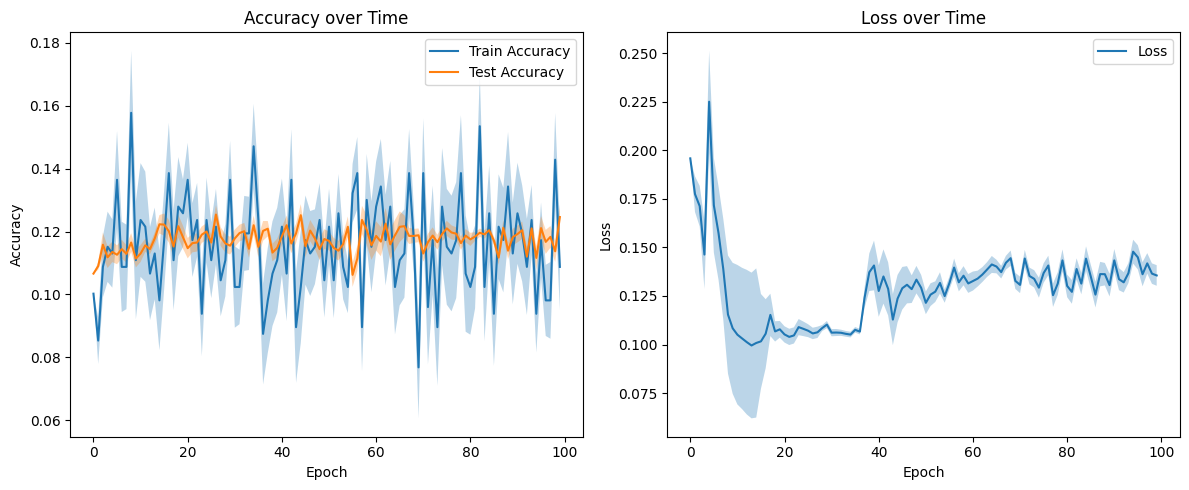

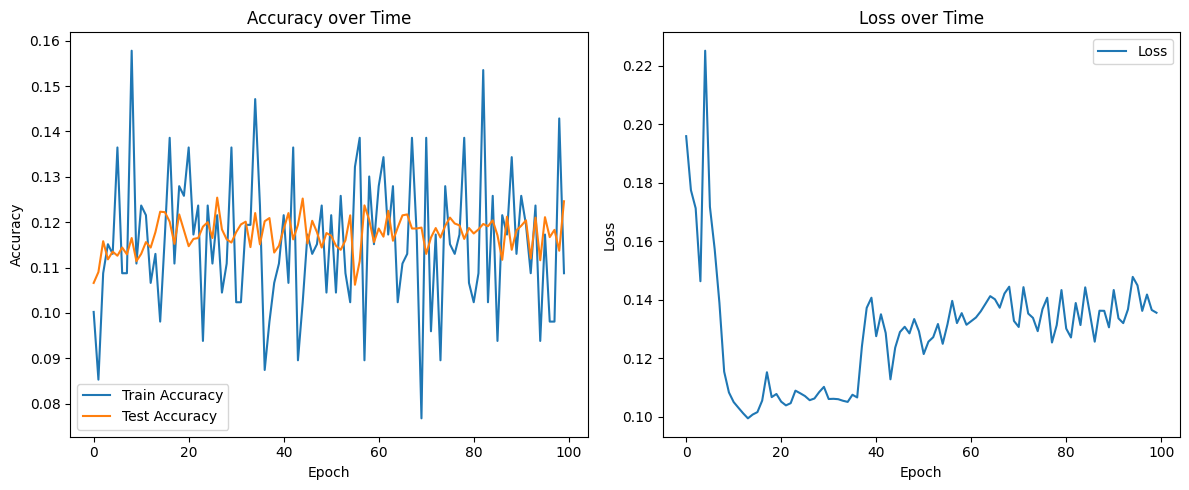

Final Train Accuracy: 0.11 ± 0.01
Final Test Accuracy: 0.12 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730652501:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.042325044301018785
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652501:   1%|          | 1/100 [00:04<07:56,  4.81s/it]

 Test accuracy:  0.1295

correct: 40 total: 469
loss: 0.052194496890756364
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730652501:   2%|▏         | 2/100 [00:09<08:06,  4.96s/it]

 Test accuracy:  0.1274

correct: 54 total: 469
loss: 0.05734225620688406
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652501:   3%|▎         | 3/100 [00:14<08:01,  4.97s/it]

 Test accuracy:  0.1442

correct: 64 total: 469
loss: 0.06293366309295077
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652501:   4%|▍         | 4/100 [00:19<08:00,  5.01s/it]

 Test accuracy:  0.1522

correct: 78 total: 469
loss: 0.06807396699116429
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730652501:   5%|▌         | 5/100 [00:24<07:55,  5.01s/it]

 Test accuracy:  0.1499

correct: 76 total: 469
loss: 0.07236620655128442
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730652501:   6%|▌         | 6/100 [00:29<07:51,  5.01s/it]

 Test accuracy:  0.1567

correct: 70 total: 469
loss: 0.07590965814650186
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730652501:   7%|▋         | 7/100 [00:35<07:51,  5.07s/it]

 Test accuracy:  0.1703

correct: 89 total: 469
loss: 0.07937305604915883
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:   8%|▊         | 8/100 [00:40<07:44,  5.05s/it]

 Test accuracy:  0.1666

correct: 83 total: 469
loss: 0.08192887748958969
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730652501:   9%|▉         | 9/100 [00:45<07:38,  5.04s/it]

 Test accuracy:  0.169

correct: 89 total: 469
loss: 0.08388056693427852
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  10%|█         | 10/100 [00:50<07:34,  5.05s/it]

 Test accuracy:  0.1746

correct: 78 total: 469
loss: 0.08593427658335233
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730652501:  11%|█         | 11/100 [00:55<07:28,  5.04s/it]

 Test accuracy:  0.1663

correct: 83 total: 469
loss: 0.08778159809646321
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730652501:  12%|█▏        | 12/100 [01:00<07:24,  5.05s/it]

 Test accuracy:  0.1781

correct: 91 total: 469
loss: 0.08910997653566698
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730652501:  13%|█▎        | 13/100 [01:05<07:24,  5.11s/it]

 Test accuracy:  0.186

correct: 105 total: 469
loss: 0.09203101457881012
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730652501:  14%|█▍        | 14/100 [01:10<07:18,  5.10s/it]

 Test accuracy:  0.1833

correct: 93 total: 469
loss: 0.0925404210048698
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730652501:  15%|█▌        | 15/100 [01:15<07:09,  5.06s/it]

 Test accuracy:  0.1787

correct: 90 total: 469
loss: 0.09512812699844587
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730652501:  16%|█▌        | 16/100 [01:20<07:05,  5.07s/it]

 Test accuracy:  0.1817

correct: 89 total: 469
loss: 0.09617472506725966
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  17%|█▋        | 17/100 [01:25<06:58,  5.04s/it]

 Test accuracy:  0.181

correct: 87 total: 469
loss: 0.09770630981558676
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730652501:  18%|█▊        | 18/100 [01:30<06:53,  5.05s/it]

 Test accuracy:  0.18

correct: 90 total: 469
loss: 0.09789624996086173
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730652501:  19%|█▉        | 19/100 [01:35<06:51,  5.08s/it]

 Test accuracy:  0.1808

correct: 85 total: 469
loss: 0.09943352472871098
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730652501:  20%|██        | 20/100 [01:41<06:50,  5.13s/it]

 Test accuracy:  0.1813

correct: 88 total: 469
loss: 0.10039654469439216
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730652501:  21%|██        | 21/100 [01:46<06:43,  5.11s/it]

 Test accuracy:  0.1793

correct: 78 total: 469
loss: 0.10071070018861848
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730652501:  22%|██▏       | 22/100 [01:51<06:40,  5.14s/it]

 Test accuracy:  0.1919

correct: 98 total: 469
loss: 0.10235769125317205
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730652501:  23%|██▎       | 23/100 [01:56<06:35,  5.14s/it]

 Test accuracy:  0.1879

correct: 82 total: 469
loss: 0.1027492635857576
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730652501:  24%|██▍       | 24/100 [02:01<06:31,  5.16s/it]

 Test accuracy:  0.1844

correct: 79 total: 469
loss: 0.10265689073150346
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730652501:  25%|██▌       | 25/100 [02:06<06:28,  5.18s/it]

 Test accuracy:  0.1902

correct: 95 total: 469
loss: 0.10377512624395936
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730652501:  26%|██▌       | 26/100 [02:12<06:25,  5.21s/it]

 Test accuracy:  0.1899

correct: 80 total: 469
loss: 0.10441394318649763
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730652501:  27%|██▋       | 27/100 [02:17<06:17,  5.18s/it]

 Test accuracy:  0.1844

correct: 99 total: 469
loss: 0.10630192625115929
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730652501:  28%|██▊       | 28/100 [02:22<06:12,  5.17s/it]

 Test accuracy:  0.1836

correct: 91 total: 469
loss: 0.1056415623725096
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730652501:  29%|██▉       | 29/100 [02:27<06:06,  5.17s/it]

 Test accuracy:  0.1769

correct: 74 total: 469
loss: 0.10605373038157725
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730652501:  30%|███       | 30/100 [02:32<06:01,  5.17s/it]

 Test accuracy:  0.1889

correct: 95 total: 469
loss: 0.10642845436199896
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730652501:  31%|███       | 31/100 [02:38<06:02,  5.26s/it]

 Test accuracy:  0.1866

correct: 81 total: 469
loss: 0.10716102731380381
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730652501:  32%|███▏      | 32/100 [02:43<05:58,  5.28s/it]

 Test accuracy:  0.1884

correct: 79 total: 469
loss: 0.10628366376608928
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730652501:  33%|███▎      | 33/100 [02:48<05:51,  5.24s/it]

 Test accuracy:  0.1809

correct: 95 total: 469
loss: 0.10817836072526253
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730652501:  34%|███▍      | 34/100 [02:53<05:45,  5.23s/it]

 Test accuracy:  0.1832

correct: 91 total: 469
loss: 0.10827707731202721
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730652501:  35%|███▌      | 35/100 [02:59<05:37,  5.19s/it]

 Test accuracy:  0.1884

correct: 83 total: 469
loss: 0.10792696142374579
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730652501:  36%|███▌      | 36/100 [03:04<05:32,  5.20s/it]

 Test accuracy:  0.1796

correct: 84 total: 469
loss: 0.10899375698396138
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730652501:  37%|███▋      | 37/100 [03:09<05:26,  5.18s/it]

 Test accuracy:  0.1869

correct: 88 total: 469
loss: 0.10893606000554079
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730652501:  38%|███▊      | 38/100 [03:14<05:24,  5.23s/it]

 Test accuracy:  0.19

correct: 93 total: 469
loss: 0.10838031026917988
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730652501:  39%|███▉      | 39/100 [03:20<05:18,  5.22s/it]

 Test accuracy:  0.1848

correct: 88 total: 469
loss: 0.1093181340710949
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730652501:  40%|████      | 40/100 [03:25<05:13,  5.22s/it]

 Test accuracy:  0.186

correct: 94 total: 469
loss: 0.10938503070553737
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730652501:  41%|████      | 41/100 [03:30<05:08,  5.23s/it]

 Test accuracy:  0.1932

correct: 93 total: 469
loss: 0.10996806651735103
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730652501:  42%|████▏     | 42/100 [03:35<05:02,  5.21s/it]

 Test accuracy:  0.1877

correct: 96 total: 469
loss: 0.10982220575435837
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730652501:  43%|████▎     | 43/100 [03:40<04:58,  5.23s/it]

 Test accuracy:  0.1937

correct: 95 total: 469
loss: 0.11033458890182886
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730652501:  44%|████▍     | 44/100 [03:46<04:55,  5.28s/it]

 Test accuracy:  0.1862

correct: 91 total: 469
loss: 0.11021131329508478
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730652501:  45%|████▌     | 45/100 [03:51<04:50,  5.28s/it]

 Test accuracy:  0.1939

correct: 84 total: 469
loss: 0.11126714935307817
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730652501:  46%|████▌     | 46/100 [03:56<04:44,  5.27s/it]

 Test accuracy:  0.1861

correct: 92 total: 469
loss: 0.11173532223269375
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730652501:  47%|████▋     | 47/100 [04:02<04:39,  5.27s/it]

 Test accuracy:  0.1936

correct: 89 total: 469
loss: 0.11206103562673272
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  48%|████▊     | 48/100 [04:07<04:38,  5.35s/it]

 Test accuracy:  0.1959

correct: 64 total: 469
loss: 0.11119558997372829
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652501:  49%|████▉     | 49/100 [04:12<04:31,  5.33s/it]

 Test accuracy:  0.186

correct: 84 total: 469
loss: 0.11118508270109641
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730652501:  50%|█████     | 50/100 [04:18<04:27,  5.36s/it]

 Test accuracy:  0.186

correct: 83 total: 469
loss: 0.1115669826550016
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730652501:  51%|█████     | 51/100 [04:23<04:21,  5.33s/it]

 Test accuracy:  0.1868

correct: 89 total: 469
loss: 0.11199044399678326
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  52%|█████▏    | 52/100 [04:28<04:13,  5.29s/it]

 Test accuracy:  0.1854

correct: 92 total: 469
loss: 0.11270278009143211
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730652501:  53%|█████▎    | 53/100 [04:34<04:08,  5.29s/it]

 Test accuracy:  0.184

correct: 89 total: 469
loss: 0.11212600549972897
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  54%|█████▍    | 54/100 [04:39<04:03,  5.29s/it]

 Test accuracy:  0.1823

correct: 89 total: 469
loss: 0.11298724286147017
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  55%|█████▌    | 55/100 [04:44<03:59,  5.32s/it]

 Test accuracy:  0.1839

correct: 90 total: 469
loss: 0.1121312923618217
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730652501:  56%|█████▌    | 56/100 [04:50<03:55,  5.36s/it]

 Test accuracy:  0.1891

correct: 81 total: 469
loss: 0.11315361357955282
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730652501:  57%|█████▋    | 57/100 [04:55<03:49,  5.33s/it]

 Test accuracy:  0.1824

correct: 94 total: 469
loss: 0.11270075914130281
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730652501:  58%|█████▊    | 58/100 [05:00<03:44,  5.34s/it]

 Test accuracy:  0.1934

correct: 98 total: 469
loss: 0.11404021054125035
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730652501:  59%|█████▉    | 59/100 [05:06<03:38,  5.33s/it]

 Test accuracy:  0.1811

correct: 69 total: 469
loss: 0.11319324887319923
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730652501:  60%|██████    | 60/100 [05:11<03:33,  5.33s/it]

 Test accuracy:  0.1896

correct: 84 total: 469
loss: 0.11315407092446711
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730652501:  61%|██████    | 61/100 [05:16<03:27,  5.31s/it]

 Test accuracy:  0.1879

correct: 78 total: 469
loss: 0.11472395545384015
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730652501:  62%|██████▏   | 62/100 [05:22<03:23,  5.36s/it]

 Test accuracy:  0.1901

correct: 85 total: 469
loss: 0.1128509950313741
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730652501:  63%|██████▎   | 63/100 [05:27<03:18,  5.37s/it]

 Test accuracy:  0.1925

correct: 85 total: 469
loss: 0.11426692033436761
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730652501:  64%|██████▍   | 64/100 [05:32<03:13,  5.36s/it]

 Test accuracy:  0.1878

correct: 88 total: 469
loss: 0.11428553809616357
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730652501:  65%|██████▌   | 65/100 [05:38<03:07,  5.35s/it]

 Test accuracy:  0.1835

correct: 90 total: 469
loss: 0.1145011172302242
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730652501:  66%|██████▌   | 66/100 [05:43<03:02,  5.36s/it]

 Test accuracy:  0.1873

correct: 109 total: 469
loss: 0.1149936614355553
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730652501:  67%|██████▋   | 67/100 [05:49<02:56,  5.35s/it]

 Test accuracy:  0.1906

correct: 85 total: 469
loss: 0.11449010199956548
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730652501:  68%|██████▊   | 68/100 [05:54<02:55,  5.48s/it]

 Test accuracy:  0.1888

correct: 82 total: 469
loss: 0.11519555853945869
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730652501:  69%|██████▉   | 69/100 [06:00<02:48,  5.44s/it]

 Test accuracy:  0.1901

correct: 78 total: 469
loss: 0.11398339943527412
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730652501:  70%|███████   | 70/100 [06:05<02:42,  5.43s/it]

 Test accuracy:  0.1884

correct: 71 total: 469
loss: 0.11443700825672413
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730652501:  71%|███████   | 71/100 [06:10<02:37,  5.41s/it]

 Test accuracy:  0.1853

correct: 86 total: 469
loss: 0.11472826241366645
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730652501:  72%|███████▏  | 72/100 [06:16<02:30,  5.38s/it]

 Test accuracy:  0.1882

correct: 83 total: 469
loss: 0.11468118522911946
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730652501:  73%|███████▎  | 73/100 [06:21<02:26,  5.43s/it]

 Test accuracy:  0.1878

correct: 84 total: 469
loss: 0.11526644485655116
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730652501:  74%|███████▍  | 74/100 [06:27<02:20,  5.42s/it]

 Test accuracy:  0.1845

correct: 74 total: 469
loss: 0.11462897805771086
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730652501:  75%|███████▌  | 75/100 [06:32<02:16,  5.45s/it]

 Test accuracy:  0.1916

correct: 94 total: 469
loss: 0.11380980560965122
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730652501:  76%|███████▌  | 76/100 [06:38<02:11,  5.47s/it]

 Test accuracy:  0.1927

correct: 91 total: 469
loss: 0.11403535571751564
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730652501:  77%|███████▋  | 77/100 [06:43<02:05,  5.48s/it]

 Test accuracy:  0.1867

correct: 76 total: 469
loss: 0.11460529002490075
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730652501:  78%|███████▊  | 78/100 [06:49<01:59,  5.45s/it]

 Test accuracy:  0.1868

correct: 73 total: 469
loss: 0.11400049497514392
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730652501:  79%|███████▉  | 79/100 [06:54<01:55,  5.50s/it]

 Test accuracy:  0.1895

correct: 92 total: 469
loss: 0.1143692063211378
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730652501:  80%|████████  | 80/100 [07:00<01:49,  5.49s/it]

 Test accuracy:  0.1903

correct: 77 total: 469
loss: 0.11508459434199181
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730652501:  81%|████████  | 81/100 [07:05<01:43,  5.47s/it]

 Test accuracy:  0.1862

correct: 78 total: 469
loss: 0.11475215254943254
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730652501:  82%|████████▏ | 82/100 [07:11<01:38,  5.50s/it]

 Test accuracy:  0.188

correct: 79 total: 469
loss: 0.11439770679356956
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730652501:  83%|████████▎ | 83/100 [07:16<01:33,  5.50s/it]

 Test accuracy:  0.1962

correct: 85 total: 469
loss: 0.11495233789435837
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730652501:  84%|████████▍ | 84/100 [07:22<01:27,  5.49s/it]

 Test accuracy:  0.1858

correct: 92 total: 469
loss: 0.11437849590836811
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730652501:  85%|████████▌ | 85/100 [07:27<01:23,  5.55s/it]

 Test accuracy:  0.1899

correct: 76 total: 469
loss: 0.11473564408036438
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730652501:  86%|████████▌ | 86/100 [07:33<01:17,  5.55s/it]

 Test accuracy:  0.1908

correct: 92 total: 469
loss: 0.11398454067676561
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730652501:  87%|████████▋ | 87/100 [07:38<01:12,  5.56s/it]

 Test accuracy:  0.1873

correct: 105 total: 469
loss: 0.11469578708031539
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730652501:  88%|████████▊ | 88/100 [07:44<01:07,  5.59s/it]

 Test accuracy:  0.1876

correct: 99 total: 469
loss: 0.11581129372628259
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730652501:  89%|████████▉ | 89/100 [07:50<01:01,  5.56s/it]

 Test accuracy:  0.1943

correct: 89 total: 469
loss: 0.11550444003933275
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730652501:  90%|█████████ | 90/100 [07:55<00:55,  5.55s/it]

 Test accuracy:  0.1867

correct: 84 total: 469
loss: 0.11495390111830697
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730652501:  91%|█████████ | 91/100 [08:01<00:50,  5.60s/it]

 Test accuracy:  0.1872

correct: 96 total: 469
loss: 0.11547926096900948
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730652501:  92%|█████████▏| 92/100 [08:06<00:44,  5.60s/it]

 Test accuracy:  0.1877

correct: 83 total: 469
loss: 0.11551337828958975
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730652501:  93%|█████████▎| 93/100 [08:12<00:39,  5.59s/it]

 Test accuracy:  0.1887

correct: 88 total: 469
loss: 0.11622721957626628
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730652501:  94%|█████████▍| 94/100 [08:18<00:33,  5.58s/it]

 Test accuracy:  0.1899

correct: 93 total: 469
loss: 0.11516856221057205
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730652501:  95%|█████████▌| 95/100 [08:23<00:27,  5.60s/it]

 Test accuracy:  0.1909

correct: 86 total: 469
loss: 0.11597531948135352
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730652501:  96%|█████████▌| 96/100 [08:29<00:22,  5.60s/it]

 Test accuracy:  0.1849

correct: 96 total: 469
loss: 0.1161519426908066
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730652501:  97%|█████████▋| 97/100 [08:35<00:16,  5.62s/it]

 Test accuracy:  0.1919

correct: 81 total: 469
loss: 0.11563353636053833
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730652501:  98%|█████████▊| 98/100 [08:40<00:11,  5.63s/it]

 Test accuracy:  0.1957

correct: 80 total: 469
loss: 0.11569618915062724
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730652501:  99%|█████████▉| 99/100 [08:46<00:05,  5.62s/it]

 Test accuracy:  0.1878

correct: 98 total: 469
loss: 0.11586096020204935
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730652501: 100%|██████████| 100/100 [08:51<00:00,  5.32s/it]

 Test accuracy:  0.1862


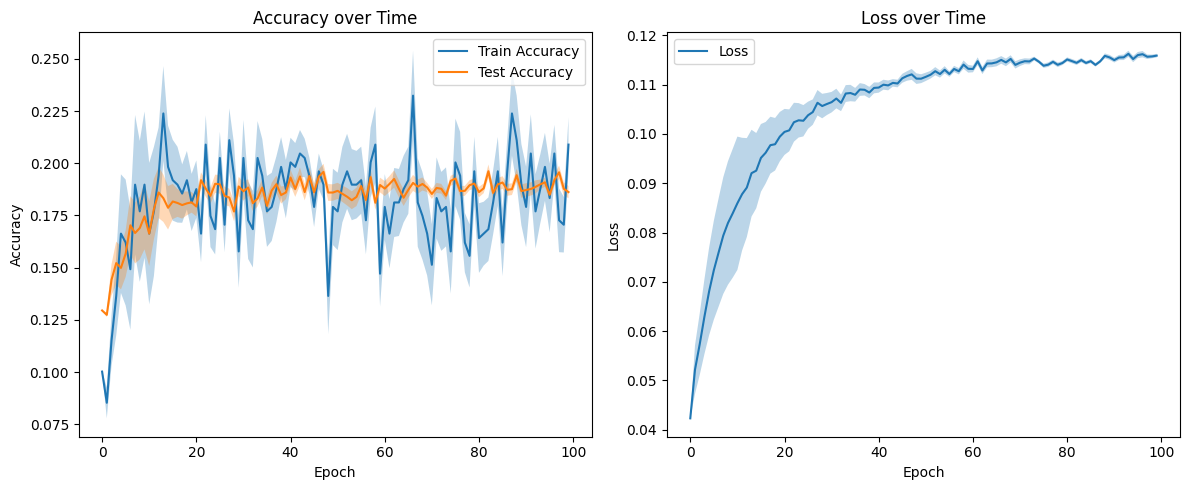

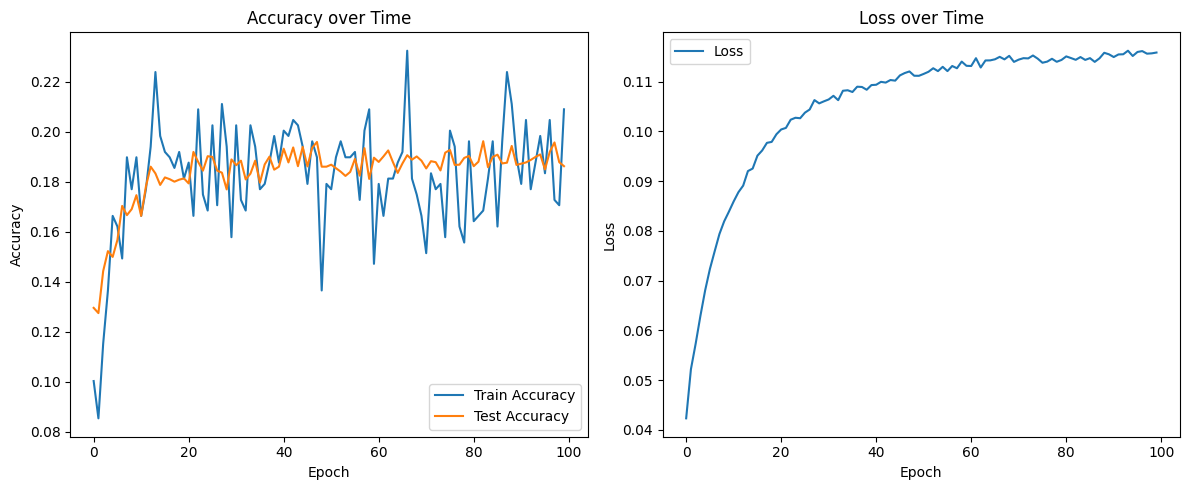

Final Train Accuracy: 0.21 ± 0.01
Final Test Accuracy: 0.19 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730653036:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.050042638471767084
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730653036:   1%|          | 1/100 [00:04<07:33,  4.58s/it]

 Test accuracy:  0.4417

correct: 40 total: 469
loss: 0.059839206304885685
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730653036:   2%|▏         | 2/100 [00:09<08:02,  4.92s/it]

 Test accuracy:  0.4787

correct: 235 total: 469
loss: 0.07385603158172768
 Train accuracy:  0.5010660980810234 | 


MLP_MNIST_0_1730653036:   3%|▎         | 3/100 [00:14<07:56,  4.91s/it]

 Test accuracy:  0.5216

correct: 244 total: 469
loss: 0.08725372182407867
 Train accuracy:  0.5202558635394456 | 


MLP_MNIST_0_1730653036:   4%|▍         | 4/100 [00:19<07:50,  4.91s/it]

 Test accuracy:  0.5609

correct: 261 total: 469
loss: 0.09431801620386303
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730653036:   5%|▌         | 5/100 [00:24<07:44,  4.89s/it]

 Test accuracy:  0.5834

correct: 286 total: 469
loss: 0.09921611283125399
 Train accuracy:  0.6098081023454158 | 


MLP_MNIST_0_1730653036:   6%|▌         | 6/100 [00:29<07:42,  4.92s/it]

 Test accuracy:  0.6036

correct: 313 total: 469
loss: 0.10100715852050639
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1730653036:   7%|▋         | 7/100 [00:34<07:38,  4.93s/it]

 Test accuracy:  0.6102

correct: 288 total: 469
loss: 0.10469372335400408
 Train accuracy:  0.6140724946695096 | 


MLP_MNIST_0_1730653036:   8%|▊         | 8/100 [00:39<07:45,  5.06s/it]

 Test accuracy:  0.6222

correct: 281 total: 469
loss: 0.10715243121835469
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1730653036:   9%|▉         | 9/100 [00:44<07:39,  5.05s/it]

 Test accuracy:  0.6261

correct: 312 total: 469
loss: 0.10860287825435971
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730653036:  10%|█         | 10/100 [00:49<07:33,  5.03s/it]

 Test accuracy:  0.6258

correct: 289 total: 469
loss: 0.10982808766207461
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1730653036:  11%|█         | 11/100 [00:54<07:26,  5.01s/it]

 Test accuracy:  0.6364

correct: 299 total: 469
loss: 0.11160272478993767
 Train accuracy:  0.6375266524520256 | 


MLP_MNIST_0_1730653036:  12%|█▏        | 12/100 [00:59<07:22,  5.03s/it]

 Test accuracy:  0.6414

correct: 287 total: 469
loss: 0.11306513272432377
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1730653036:  13%|█▎        | 13/100 [01:04<07:15,  5.01s/it]

 Test accuracy:  0.6328

correct: 300 total: 469
loss: 0.11370211283662426
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1730653036:  14%|█▍        | 14/100 [01:09<07:12,  5.03s/it]

 Test accuracy:  0.642

correct: 293 total: 469
loss: 0.11366311332056009
 Train accuracy:  0.6247334754797441 | 


MLP_MNIST_0_1730653036:  15%|█▌        | 15/100 [01:14<07:07,  5.03s/it]

 Test accuracy:  0.6386

correct: 311 total: 469
loss: 0.11534531845022113
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730653036:  16%|█▌        | 16/100 [01:19<07:01,  5.02s/it]

 Test accuracy:  0.6478

correct: 307 total: 469
loss: 0.11656072600754594
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730653036:  17%|█▋        | 17/100 [01:24<06:57,  5.03s/it]

 Test accuracy:  0.6463

correct: 308 total: 469
loss: 0.11723130927093502
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1730653036:  18%|█▊        | 18/100 [01:29<06:53,  5.05s/it]

 Test accuracy:  0.6475

correct: 303 total: 469
loss: 0.11748962453814712
 Train accuracy:  0.6460554371002132 | 


MLP_MNIST_0_1730653036:  19%|█▉        | 19/100 [01:35<06:50,  5.07s/it]

 Test accuracy:  0.6437

correct: 300 total: 469
loss: 0.11838054987413288
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1730653036:  20%|██        | 20/100 [01:40<06:44,  5.06s/it]

 Test accuracy:  0.6438

correct: 300 total: 469
loss: 0.11845533030310165
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1730653036:  21%|██        | 21/100 [01:45<06:44,  5.11s/it]

 Test accuracy:  0.6447

correct: 306 total: 469
loss: 0.11908158516960103
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730653036:  22%|██▏       | 22/100 [01:50<06:39,  5.12s/it]

 Test accuracy:  0.6458

correct: 311 total: 469
loss: 0.12006347129212767
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730653036:  23%|██▎       | 23/100 [01:55<06:34,  5.12s/it]

 Test accuracy:  0.6456

correct: 305 total: 469
loss: 0.1201687161125608
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  24%|██▍       | 24/100 [02:00<06:28,  5.11s/it]

 Test accuracy:  0.6451

correct: 312 total: 469
loss: 0.12038289342544226
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730653036:  25%|██▌       | 25/100 [02:05<06:25,  5.13s/it]

 Test accuracy:  0.6451

correct: 320 total: 469
loss: 0.1214498498324138
 Train accuracy:  0.6823027718550106 | 


MLP_MNIST_0_1730653036:  26%|██▌       | 26/100 [02:11<06:20,  5.14s/it]

 Test accuracy:  0.6458

correct: 299 total: 469
loss: 0.12105236070623784
 Train accuracy:  0.6375266524520256 | 


MLP_MNIST_0_1730653036:  27%|██▋       | 27/100 [02:16<06:19,  5.20s/it]

 Test accuracy:  0.6468

correct: 295 total: 469
loss: 0.12199831441013036
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1730653036:  28%|██▊       | 28/100 [02:21<06:11,  5.17s/it]

 Test accuracy:  0.6502

correct: 304 total: 469
loss: 0.1216273011365679
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1730653036:  29%|██▉       | 29/100 [02:26<06:07,  5.18s/it]

 Test accuracy:  0.6461

correct: 306 total: 469
loss: 0.12297754447216164
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730653036:  30%|███       | 30/100 [02:31<06:03,  5.19s/it]

 Test accuracy:  0.6486

correct: 295 total: 469
loss: 0.12292859930473604
 Train accuracy:  0.6289978678038379 | 


MLP_MNIST_0_1730653036:  31%|███       | 31/100 [02:37<05:58,  5.20s/it]

 Test accuracy:  0.6418

correct: 306 total: 469
loss: 0.12316371031852165
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730653036:  32%|███▏      | 32/100 [02:42<05:51,  5.17s/it]

 Test accuracy:  0.6486

correct: 290 total: 469
loss: 0.1232010830662398
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1730653036:  33%|███▎      | 33/100 [02:47<05:51,  5.24s/it]

 Test accuracy:  0.6479

correct: 311 total: 469
loss: 0.12342318674839382
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730653036:  34%|███▍      | 34/100 [02:52<05:45,  5.24s/it]

 Test accuracy:  0.65

correct: 301 total: 469
loss: 0.12363879314300094
 Train accuracy:  0.6417910447761194 | 


MLP_MNIST_0_1730653036:  35%|███▌      | 35/100 [02:58<05:40,  5.23s/it]

 Test accuracy:  0.6474

correct: 281 total: 469
loss: 0.12433336810198928
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1730653036:  36%|███▌      | 36/100 [03:03<05:33,  5.21s/it]

 Test accuracy:  0.6467

correct: 301 total: 469
loss: 0.12361994029870674
 Train accuracy:  0.6417910447761194 | 


MLP_MNIST_0_1730653036:  37%|███▋      | 37/100 [03:08<05:28,  5.22s/it]

 Test accuracy:  0.6428

correct: 308 total: 469
loss: 0.12443236831917183
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1730653036:  38%|███▊      | 38/100 [03:13<05:23,  5.22s/it]

 Test accuracy:  0.6442

correct: 302 total: 469
loss: 0.12346500172607426
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730653036:  39%|███▉      | 39/100 [03:19<05:20,  5.26s/it]

 Test accuracy:  0.6497

correct: 314 total: 469
loss: 0.12372810426932662
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730653036:  40%|████      | 40/100 [03:24<05:15,  5.26s/it]

 Test accuracy:  0.6478

correct: 304 total: 469
loss: 0.12375638441744644
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1730653036:  41%|████      | 41/100 [03:29<05:12,  5.29s/it]

 Test accuracy:  0.6464

correct: 325 total: 469
loss: 0.12437307605865414
 Train accuracy:  0.6929637526652452 | 


MLP_MNIST_0_1730653036:  42%|████▏     | 42/100 [03:34<05:07,  5.30s/it]

 Test accuracy:  0.6477

correct: 305 total: 469
loss: 0.1248413104651325
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  43%|████▎     | 43/100 [03:40<05:00,  5.27s/it]

 Test accuracy:  0.6436

correct: 305 total: 469
loss: 0.12446898342703959
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  44%|████▍     | 44/100 [03:45<04:55,  5.29s/it]

 Test accuracy:  0.6525

correct: 300 total: 469
loss: 0.12570795607465163
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1730653036:  45%|████▌     | 45/100 [03:50<04:53,  5.34s/it]

 Test accuracy:  0.6438

correct: 305 total: 469
loss: 0.12500215765001424
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  46%|████▌     | 46/100 [03:56<04:48,  5.35s/it]

 Test accuracy:  0.6482

correct: 309 total: 469
loss: 0.12475286675160373
 Train accuracy:  0.6588486140724946 | 


MLP_MNIST_0_1730653036:  47%|████▋     | 47/100 [04:01<04:41,  5.32s/it]

 Test accuracy:  0.6456

correct: 305 total: 469
loss: 0.12607913036971713
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  48%|████▊     | 48/100 [04:06<04:36,  5.32s/it]

 Test accuracy:  0.6536

correct: 297 total: 469
loss: 0.12504957625860852
 Train accuracy:  0.6332622601279317 | 


MLP_MNIST_0_1730653036:  49%|████▉     | 49/100 [04:12<04:30,  5.30s/it]

 Test accuracy:  0.6517

correct: 314 total: 469
loss: 0.12562723214755941
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730653036:  50%|█████     | 50/100 [04:17<04:26,  5.34s/it]

 Test accuracy:  0.6497

correct: 315 total: 469
loss: 0.1259411702564022
 Train accuracy:  0.6716417910447762 | 


MLP_MNIST_0_1730653036:  51%|█████     | 51/100 [04:23<04:23,  5.37s/it]

 Test accuracy:  0.6489

correct: 305 total: 469
loss: 0.1251436888472612
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  52%|█████▏    | 52/100 [04:28<04:17,  5.37s/it]

 Test accuracy:  0.6453

correct: 307 total: 469
loss: 0.1260571953838568
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730653036:  53%|█████▎    | 53/100 [04:33<04:12,  5.38s/it]

 Test accuracy:  0.6492

correct: 305 total: 469
loss: 0.12520349279903908
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  54%|█████▍    | 54/100 [04:39<04:07,  5.38s/it]

 Test accuracy:  0.6494

correct: 299 total: 469
loss: 0.12577288224498853
 Train accuracy:  0.6375266524520256 | 


MLP_MNIST_0_1730653036:  55%|█████▌    | 55/100 [04:44<04:02,  5.39s/it]

 Test accuracy:  0.6467

correct: 317 total: 469
loss: 0.12568357934766233
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730653036:  56%|█████▌    | 56/100 [04:50<03:57,  5.41s/it]

 Test accuracy:  0.6516

correct: 300 total: 469
loss: 0.12581001579570872
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1730653036:  57%|█████▋    | 57/100 [04:55<03:55,  5.47s/it]

 Test accuracy:  0.6446

correct: 305 total: 469
loss: 0.1257374906686069
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  58%|█████▊    | 58/100 [05:01<03:51,  5.50s/it]

 Test accuracy:  0.6457

correct: 312 total: 469
loss: 0.12654155152820068
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730653036:  59%|█████▉    | 59/100 [05:06<03:45,  5.50s/it]

 Test accuracy:  0.6457

correct: 289 total: 469
loss: 0.1269567285868913
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1730653036:  60%|██████    | 60/100 [05:12<03:39,  5.49s/it]

 Test accuracy:  0.6545

correct: 308 total: 469
loss: 0.12650997078876253
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1730653036:  61%|██████    | 61/100 [05:17<03:34,  5.51s/it]

 Test accuracy:  0.6452

correct: 307 total: 469
loss: 0.12724978349673977
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730653036:  62%|██████▏   | 62/100 [05:23<03:28,  5.49s/it]

 Test accuracy:  0.6418

correct: 300 total: 469
loss: 0.12616921424357366
 Train accuracy:  0.6396588486140725 | 


MLP_MNIST_0_1730653036:  63%|██████▎   | 63/100 [05:29<03:28,  5.64s/it]

 Test accuracy:  0.6507

correct: 307 total: 469
loss: 0.12675045486261596
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730653036:  64%|██████▍   | 64/100 [05:34<03:20,  5.58s/it]

 Test accuracy:  0.6451

correct: 308 total: 469
loss: 0.12713583650937213
 Train accuracy:  0.6567164179104478 | 


MLP_MNIST_0_1730653036:  65%|██████▌   | 65/100 [05:39<03:13,  5.52s/it]

 Test accuracy:  0.6481

correct: 290 total: 469
loss: 0.1269516156775865
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1730653036:  66%|██████▌   | 66/100 [05:45<03:07,  5.52s/it]

 Test accuracy:  0.6465

correct: 304 total: 469
loss: 0.12606124951641187
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1730653036:  67%|██████▋   | 67/100 [05:51<03:02,  5.52s/it]

 Test accuracy:  0.6446

correct: 291 total: 469
loss: 0.1269597010190553
 Train accuracy:  0.6204690831556503 | 


MLP_MNIST_0_1730653036:  68%|██████▊   | 68/100 [05:56<02:56,  5.52s/it]

 Test accuracy:  0.6531

correct: 305 total: 469
loss: 0.12686596340589176
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  69%|██████▉   | 69/100 [06:01<02:49,  5.48s/it]

 Test accuracy:  0.6421

correct: 312 total: 469
loss: 0.1272645326120767
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1730653036:  70%|███████   | 70/100 [06:07<02:44,  5.47s/it]

 Test accuracy:  0.6473

correct: 287 total: 469
loss: 0.12690867213552187
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1730653036:  71%|███████   | 71/100 [06:12<02:38,  5.46s/it]

 Test accuracy:  0.6488

correct: 293 total: 469
loss: 0.12706837682391026
 Train accuracy:  0.6247334754797441 | 


MLP_MNIST_0_1730653036:  72%|███████▏  | 72/100 [06:18<02:32,  5.46s/it]

 Test accuracy:  0.6522

correct: 271 total: 469
loss: 0.12754720215921972
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1730653036:  73%|███████▎  | 73/100 [06:23<02:27,  5.47s/it]

 Test accuracy:  0.6497

correct: 313 total: 469
loss: 0.12806127774817094
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1730653036:  74%|███████▍  | 74/100 [06:29<02:23,  5.50s/it]

 Test accuracy:  0.6496

correct: 289 total: 469
loss: 0.1273457820354494
 Train accuracy:  0.6162046908315565 | 


MLP_MNIST_0_1730653036:  75%|███████▌  | 75/100 [06:34<02:17,  5.51s/it]

 Test accuracy:  0.6477

correct: 305 total: 469
loss: 0.12785565128712767
 Train accuracy:  0.650319829424307 | 


MLP_MNIST_0_1730653036:  76%|███████▌  | 76/100 [06:40<02:12,  5.51s/it]

 Test accuracy:  0.6563

correct: 302 total: 469
loss: 0.1280270217101711
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730653036:  77%|███████▋  | 77/100 [06:46<02:07,  5.56s/it]

 Test accuracy:  0.6514

correct: 301 total: 469
loss: 0.128152676673332
 Train accuracy:  0.6417910447761194 | 


MLP_MNIST_0_1730653036:  78%|███████▊  | 78/100 [06:51<02:02,  5.55s/it]

 Test accuracy:  0.6516

correct: 311 total: 469
loss: 0.12761280340934866
 Train accuracy:  0.6631130063965884 | 


MLP_MNIST_0_1730653036:  79%|███████▉  | 79/100 [06:57<01:56,  5.55s/it]

 Test accuracy:  0.6469

correct: 284 total: 469
loss: 0.1278542783151049
 Train accuracy:  0.605543710021322 | 


MLP_MNIST_0_1730653036:  80%|████████  | 80/100 [07:02<01:51,  5.59s/it]

 Test accuracy:  0.6451

correct: 292 total: 469
loss: 0.1277641734874833
 Train accuracy:  0.6226012793176973 | 


MLP_MNIST_0_1730653036:  81%|████████  | 81/100 [07:08<01:46,  5.62s/it]

 Test accuracy:  0.6503

correct: 315 total: 469
loss: 0.12732443818723216
 Train accuracy:  0.6716417910447762 | 


MLP_MNIST_0_1730653036:  82%|████████▏ | 82/100 [07:14<01:41,  5.61s/it]

 Test accuracy:  0.6518

correct: 285 total: 469
loss: 0.12778553319002775
 Train accuracy:  0.6076759061833689 | 


MLP_MNIST_0_1730653036:  83%|████████▎ | 83/100 [07:19<01:35,  5.60s/it]

 Test accuracy:  0.647

correct: 319 total: 469
loss: 0.1282090311174962
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1730653036:  84%|████████▍ | 84/100 [07:25<01:29,  5.60s/it]

 Test accuracy:  0.6497

correct: 298 total: 469
loss: 0.12820829957850707
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1730653036:  85%|████████▌ | 85/100 [07:30<01:23,  5.58s/it]

 Test accuracy:  0.646

correct: 298 total: 469
loss: 0.12782040209785453
 Train accuracy:  0.6353944562899787 | 


MLP_MNIST_0_1730653036:  86%|████████▌ | 86/100 [07:36<01:18,  5.61s/it]

 Test accuracy:  0.6504

correct: 317 total: 469
loss: 0.12751809992134444
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1730653036:  87%|████████▋ | 87/100 [07:42<01:12,  5.61s/it]

 Test accuracy:  0.6504

correct: 306 total: 469
loss: 0.12802054791816517
 Train accuracy:  0.652452025586354 | 


MLP_MNIST_0_1730653036:  88%|████████▊ | 88/100 [07:47<01:07,  5.61s/it]

 Test accuracy:  0.6499

correct: 310 total: 469
loss: 0.1279001484261647
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1730653036:  89%|████████▉ | 89/100 [07:53<01:01,  5.59s/it]

 Test accuracy:  0.6469

correct: 304 total: 469
loss: 0.12919227661354454
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1730653036:  90%|█████████ | 90/100 [07:58<00:55,  5.59s/it]

 Test accuracy:  0.6546

correct: 321 total: 469
loss: 0.1286685233081836
 Train accuracy:  0.6844349680170576 | 


MLP_MNIST_0_1730653036:  91%|█████████ | 91/100 [08:04<00:50,  5.64s/it]

 Test accuracy:  0.6463

correct: 316 total: 469
loss: 0.12808940577100336
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1730653036:  92%|█████████▏| 92/100 [08:10<00:45,  5.64s/it]

 Test accuracy:  0.6502

correct: 314 total: 469
loss: 0.12856052474363017
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1730653036:  93%|█████████▎| 93/100 [08:15<00:39,  5.64s/it]

 Test accuracy:  0.6521

correct: 290 total: 469
loss: 0.12845797021823652
 Train accuracy:  0.6183368869936035 | 


MLP_MNIST_0_1730653036:  94%|█████████▍| 94/100 [08:21<00:33,  5.63s/it]

 Test accuracy:  0.645

correct: 287 total: 469
loss: 0.1287607814965726
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1730653036:  95%|█████████▌| 95/100 [08:27<00:28,  5.66s/it]

 Test accuracy:  0.6473

correct: 313 total: 469
loss: 0.12859964550240463
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1730653036:  96%|█████████▌| 96/100 [08:32<00:22,  5.63s/it]

 Test accuracy:  0.6488

correct: 302 total: 469
loss: 0.12831483585938716
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1730653036:  97%|█████████▋| 97/100 [08:38<00:17,  5.70s/it]

 Test accuracy:  0.6489

correct: 307 total: 469
loss: 0.1279571443351347
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730653036:  98%|█████████▊| 98/100 [08:44<00:11,  5.68s/it]

 Test accuracy:  0.6488

correct: 330 total: 469
loss: 0.12855159937699975
 Train accuracy:  0.7036247334754797 | 


MLP_MNIST_0_1730653036:  99%|█████████▉| 99/100 [08:49<00:05,  5.69s/it]

 Test accuracy:  0.6446

correct: 322 total: 469
loss: 0.12890280573479912
 Train accuracy:  0.6865671641791045 | 


MLP_MNIST_0_1730653036: 100%|██████████| 100/100 [08:55<00:00,  5.36s/it]

 Test accuracy:  0.6469


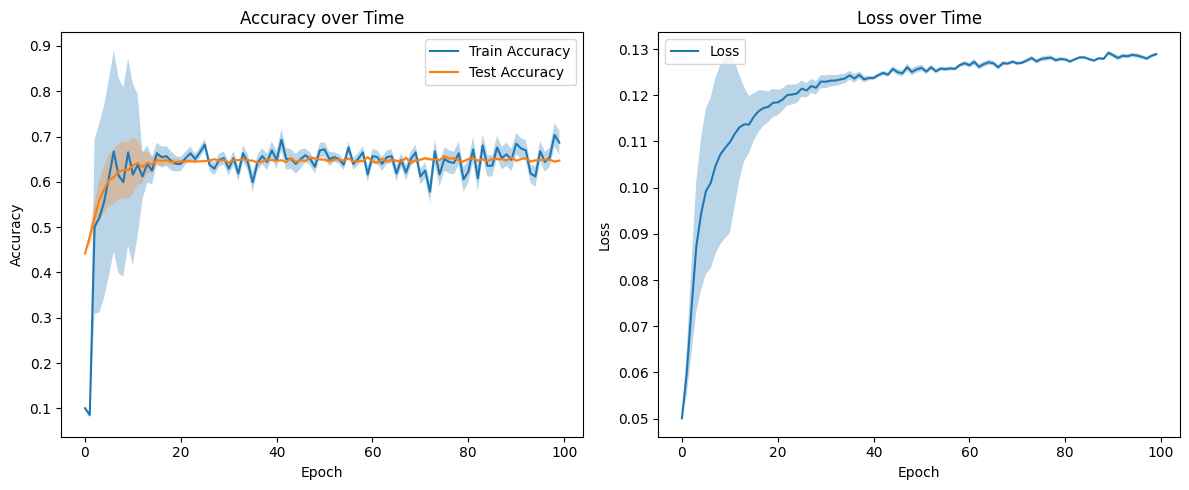

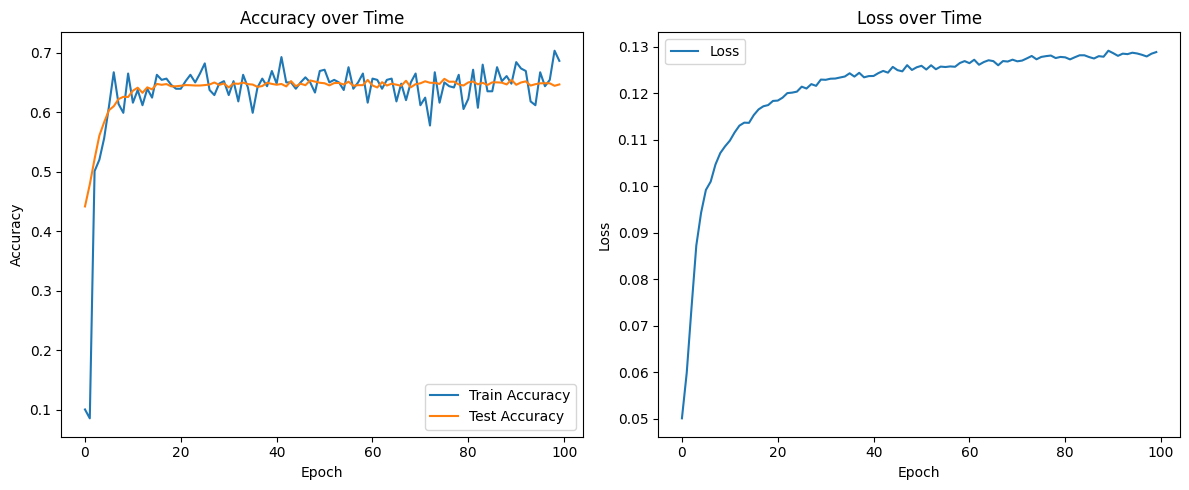

Final Train Accuracy: 0.69 ± 0.03
Final Test Accuracy: 0.65 ± 0.00
bernoulli - Final Train Accuracy: 0.55 ± 0.02
bernoulli - Final Test Accuracy: 0.54 ± 0.00
gumbel_softmax - Final Train Accuracy: 0.10 ± 0.02
gumbel_softmax - Final Test Accuracy: 0.24 ± 0.00
gaussian - Final Train Accuracy: 0.22 ± 0.01
gaussian - Final Test Accuracy: 0.21 ± 0.01
beta - Final Train Accuracy: 0.68 ± 0.01
beta - Final Test Accuracy: 0.66 ± 0.00
dirichlet - Final Train Accuracy: 0.23 ± 0.02
dirichlet - Final Test Accuracy: 0.24 ± 0.00
multinomial - Final Train Accuracy: 0.10 ± 0.01
multinomial - Final Test Accuracy: 0.12 ± 0.00
cauchy - Final Train Accuracy: 0.11 ± 0.01
cauchy - Final Test Accuracy: 0.12 ± 0.00
laplace - Final Train Accuracy: 0.21 ± 0.01
laplace - Final Test Accuracy: 0.19 ± 0.00
uniform - Final Train Accuracy: 0.69 ± 0.03
uniform - Final Test Accuracy: 0.65 ± 0.00


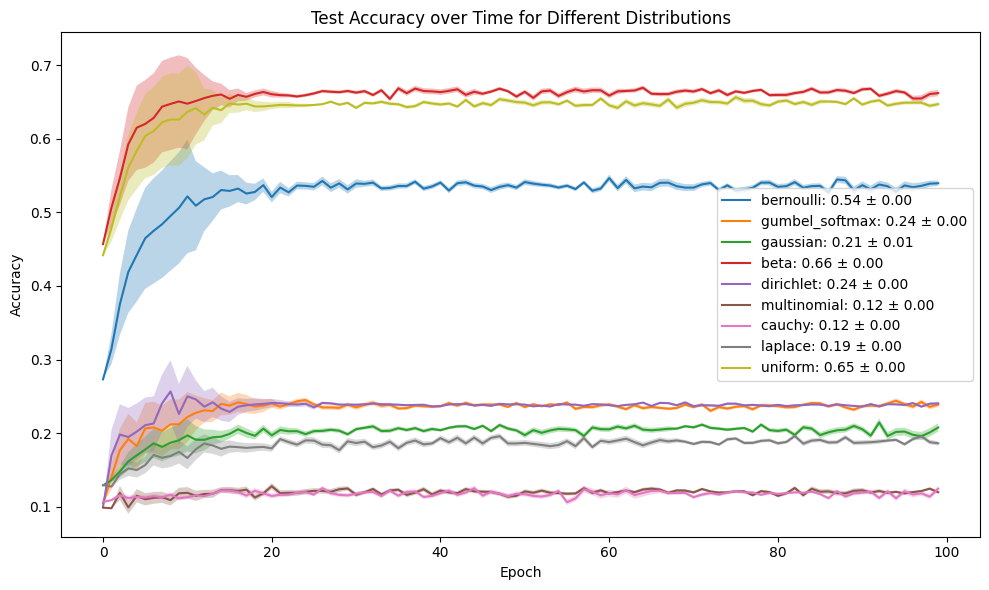

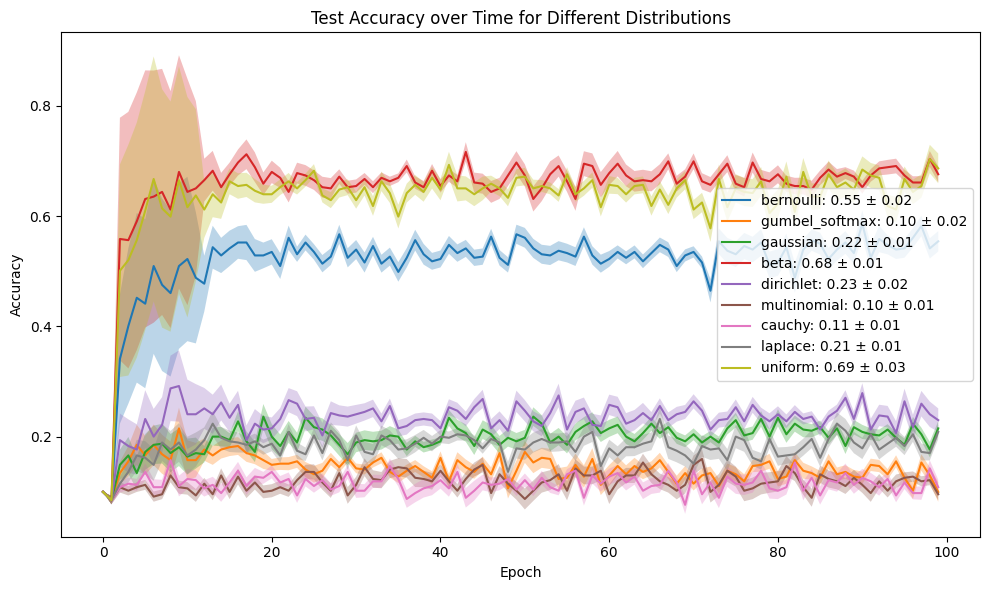

In [8]:


import csv
import numpy as np
import matplotlib.pyplot as plt

# List of distributions to iterate over
distributions = ["bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"]

# Configuration
config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.8,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "initial_tau": 1.0, # positive float value
}

# Function to run kanRL and collect results
def run_experiment(distribution):
    config["distribution"] = distribution
    q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

    return train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds

# Initialize results dictionary
results = {dist: {} for dist in distributions}

# Run experiments for each distribution
for distribution in distributions:
    train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds = run_experiment(distribution)

    results[distribution]['train_accuracies'] = train_accuracies
    results[distribution]['test_accuracies'] = test_accuracies
    results[distribution]['losses'] = losses
    results[distribution]['train_acc_stds'] = train_acc_stds
    results[distribution]['test_acc_stds'] = test_acc_stds
    results[distribution]['loss_stds'] = loss_stds

    # Save train accuracies and stds
    with open(f'MLP_{distribution}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Epoch', 'Train Accuracy', 'Train Accuracy Std', 'Test Accuracy', 'Test Accuracy Std', 'Loss', 'Loss Std'])
        for epoch, (train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std) in enumerate(zip(train_accuracies, train_acc_stds, test_accuracies, test_acc_stds, losses, loss_stds)):
            writer.writerow([epoch, train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std])


# Print final accuracies with +/- errors for each distribution
for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]

    print(f"{distribution} - Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
    print(f"{distribution} - Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")



# Plotting: Test accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['test_accuracies'], label=f'{distribution}: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['test_accuracies']) - np.array(results[distribution]['test_acc_stds']),
                     np.array(results[distribution]['test_accuracies']) + np.array(results[distribution]['test_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('MLP_test_comparison_plot.png', dpi=300)
plt.show()


# Plotting: Train accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['train_accuracies'], label=f'{distribution}: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['train_accuracies']) - np.array(results[distribution]['train_acc_stds']),
                     np.array(results[distribution]['train_accuracies']) + np.array(results[distribution]['train_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('MLP_train_comparison_plot.png', dpi=300)
plt.show()




## KAN

In [ ]:


import csv
import numpy as np
import matplotlib.pyplot as plt

# List of distributions to iterate over
distributions = ["bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"]

# Configuration
config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.8,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "initial_tau": 1.0, # positive float value
}

# Function to run kanRL and collect results
def run_experiment(distribution):
    config["distribution"] = distribution
    q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

    return train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds

# Initialize results dictionary
results = {dist: {} for dist in distributions}

# Run experiments for each distribution
for distribution in distributions:
    train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds = run_experiment(distribution)

    results[distribution]['train_accuracies'] = train_accuracies
    results[distribution]['test_accuracies'] = test_accuracies
    results[distribution]['losses'] = losses
    results[distribution]['train_acc_stds'] = train_acc_stds
    results[distribution]['test_acc_stds'] = test_acc_stds
    results[distribution]['loss_stds'] = loss_stds

    # Save train accuracies and stds
    with open(f'MLP_{distribution}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Epoch', 'Train Accuracy', 'Train Accuracy Std', 'Test Accuracy', 'Test Accuracy Std', 'Loss', 'Loss Std'])
        for epoch, (train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std) in enumerate(zip(train_accuracies, train_acc_stds, test_accuracies, test_acc_stds, losses, loss_stds)):
            writer.writerow([epoch, train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std])


# Print final accuracies with +/- errors for each distribution
for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]

    print(f"{distribution} - Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
    print(f"{distribution} - Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")



# Plotting: Test accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['test_accuracies'], label=f'{distribution}: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['test_accuracies']) - np.array(results[distribution]['test_acc_stds']),
                     np.array(results[distribution]['test_accuracies']) + np.array(results[distribution]['test_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('KAN_test_comparison_plot.png', dpi=300)
plt.show()


# Plotting: Train accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['train_accuracies'], label=f'{distribution}: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['train_accuracies']) - np.array(results[distribution]['train_acc_stds']),
                     np.array(results[distribution]['train_accuracies']) + np.array(results[distribution]['train_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('KAN_train_comparison_plot.png', dpi=300)
plt.show()


